In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
import zarr
import allel
pd.options.display.float_format = '{:10,.3g}'.format #

In [2]:
c_r_g_df = pd.read_csv("../steps/rfmix_stats_df/call_recomb_genes.txt")
c_r_g_df

chrom      start  callable_frac        end         cM     end_cM  \
0      chr1          0          0.795     100000          0       0.36   
1      chr1     100000           0.89     200000       0.36      0.477   
2      chr1     200000          0.919     300000      0.477      0.547   
3      chr1     300000          0.878     400000      0.547      0.626   
4      chr1     400000          0.485     500000      0.626       1.37   
...     ...        ...            ...        ...        ...        ...   
27377  chrX  143200000           0.67  143300000        127        127   
27378  chrX  143300000          0.905  143400000        127        127   
27379  chrX  143400000          0.789  143500000        127        127   
27380  chrX  143500000          0.836  143600000        127        127   
27381  chrX  143600000          0.604  143691566        127        127   

       average_cM_window                                              genes  \
0                3.6e-06  ['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...   
1               1.16e-06  ['TTLL10', 'TTLL10', 'TTLL10', 'TTLL10', 'TTLL...   
2               7.05e-07  ['B3GALT6', 'C1QTNF12', 'UBE2J2', 'UBE2J2', 'U...   
3               7.94e-07  ['DVL1', 'DVL1', 'DVL1', 'MXRA8', 'MXRA8', 'MX...   
4                7.4e-06                       ['VWA1', 'TMEM240', 'SSU72']   
...                  ...                                                ...   
27377           2.56e-07      ['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']   
27378           3.37e-07               ['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']   
27379            2.8e-07                                          ['SPRY3']   
27380           7.53e-07                                          ['VAMP7']   
27381           3.69e-06                                          ['VAMP7']   

       genic  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
27377   True  
27378   True  
27379   True  
27380   True  
27381   True  

[27382 rows x 9 columns]

In [3]:
zarr_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset_f = zarr.open_group(zarr_chrX_dir, mode="r")
gt_f = allel.GenotypeArray(callset_f["calldata/GT"])
pos_f = callset_f["variants/POS"][:]

zarr_all_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/all_chrX"
#Opening the zarr data
callset_all_chrX = zarr.open_group(zarr_all_chrX_dir, mode="r")
gt_all_chrX = allel.GenotypeArray(callset_all_chrX["calldata/GT"])
pos_all_chrX = callset_all_chrX["variants/POS"][:]

zarr_dipmale_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/dipmale_chrX"
#Opening the zarr data
callset_dipmale_chrX = zarr.open_group(zarr_dipmale_chrX, mode="r")

hap_starter = pd.read_csv("../data/haploid_metadata.txt", sep =" ")
meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

#Generate a mapping between metadata and callset - repeat for chrX females to be sure of no errors.
ID_to_callset = dict(zip(callset_all_chrX["samples"][:], range(len(callset_all_chrX["samples"][:]))))
hap_meta_data_samples = hap_starter.loc[hap_starter.PGDP_ID.isin(callset_all_chrX["samples"][:])].copy()
hap_meta_data_samples["callset_index"] = hap_meta_data_samples.PGDP_ID.map(ID_to_callset)

ID_to_callset_f = dict(zip(callset_f["samples"][:], range(len(callset_f["samples"][:]))))
meta_data_samples_f = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_f["samples"][:])].copy()
meta_data_samples_f["callset_index"] = meta_data_samples_f.PGDP_ID.map(ID_to_callset_f)

ID_to_callset_dip = dict(zip(callset_dipmale_chrX["samples"][:], range(len(callset_dipmale_chrX["samples"][:]))))
meta_data_samples_dip = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_dipmale_chrX["samples"][:])].copy()
meta_data_samples_dip["callset_index"] = meta_data_samples_dip.PGDP_ID.map(ID_to_callset_dip)

In [4]:
meta_data_samples.groupby("Species")[["Sex"]].value_counts()

Species             Sex
anubis              F      52
                    M      42
cynocephalus        M      38
                    F      24
gelada              M       2
hamadryas           M      20
                    F       6
kindae              M      18
                    F       9
papio               M       7
                    F       5
ursinus (grayfoot)  F       3
                    M       1
Name: count, dtype: int64

In [5]:
focus_pop_tag = "Anubis, Tanzania"
window_size = 100000
all_chroms = []#["chr{}".format(x) for x in (range(1, 21))]+["all_chrX"]

c_all_df_l = []
for c in all_chroms:
    print(c)
    zarr_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/" + c
    #Opening the zarr data
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    # Loading in the IDs and gt
    if c == "all_chrX":
        metadata = hap_meta_data_samples
    else:
        metadata = meta_data_samples
    focus_pop_IDs = metadata.loc[metadata.C_origin == focus_pop_tag].PGDP_ID
    focus_pop_gt = gt.take(metadata.loc[metadata.C_origin == focus_pop_tag].callset_index,
                       axis=1)
    df_l = []
    for ind in focus_pop_IDs:
        if ind[-1:] == "b":
            continue
        elif ind[-1:] == "a":
            focus_ind_gt = focus_pop_gt = gt.take(metadata.loc[metadata.PGDP_ID.isin([ind, ind[:-1]+"b"])].callset_index,
                           axis=1)
            rest_pop_gt = focus_pop_gt = gt.take(metadata.loc[(~metadata.PGDP_ID.isin([ind, ind[:-1]+"b"])) &
                                                                                   metadata.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                           axis=1)
            ID = ind[:-2]
        else:
            focus_ind_gt = focus_pop_gt = gt.take(metadata.loc[metadata.PGDP_ID.isin([ind])].callset_index,
                           axis=1)
            rest_pop_gt = focus_pop_gt = gt.take(metadata.loc[(~metadata.PGDP_ID.isin([ind])) &
                                                                               metadata.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                           axis=1)
            ID = ind
        if ID[0] != "P" and ID[0] != "S":
            ID = "Sci_" + ID
        pi, windows, n_bases, counts = allel.windowed_diversity(pos, focus_ind_gt.count_alleles(),
                          size=window_size, start=0)
        df_l.append(pd.DataFrame({"chrom": c, "individual": ID, "start": windows[:,0], "heterozygosity": pi}))
    focus_df = pd.concat(df_l)
    if c == "chrX":
        rf_c = "female_chrX"
    elif c == "dipmale_chrX":
        rf_c = "all_chrX"
    else:
        rf_c = c
    print(c, rf_c)
    c_rfmix = mean_window_df_tanz_olive.loc[mean_window_df_tanz_olive.chrom == rf_c]
    c_rfmix["chrom"] = c
    per_ind_df = c_rfmix.merge(focus_df, on=["chrom", "individual", "start"])
    c_all_df_l.append(per_ind_df)

Section on outgroup diversity

In [6]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
import zarr
import allel

In [7]:
zarr_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset_f = zarr.open_group(zarr_chrX_dir, mode="r")
gt_f = allel.GenotypeArray(callset_f["calldata/GT"])
pos_f = callset_f["variants/POS"][:]

zarr_all_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/all_chrX"
#Opening the zarr data
callset_all_chrX = zarr.open_group(zarr_all_chrX_dir, mode="r")
gt_all_chrX = allel.GenotypeArray(callset_all_chrX["calldata/GT"])
pos_all_chrX = callset_all_chrX["variants/POS"][:]

zarr_dipmale_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/dipmale_chrX"
#Opening the zarr data
callset_dipmale_chrX = zarr.open_group(zarr_dipmale_chrX, mode="r")

hap_starter = pd.read_csv("../data/haploid_metadata.txt", sep =" ")
meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

#Generate a mapping between metadata and callset - repeat for chrX females to be sure of no errors.
ID_to_callset = dict(zip(callset_all_chrX["samples"][:], range(len(callset_all_chrX["samples"][:]))))
hap_meta_data_samples = hap_starter.loc[hap_starter.PGDP_ID.isin(callset_all_chrX["samples"][:])].copy()
hap_meta_data_samples["callset_index"] = hap_meta_data_samples.PGDP_ID.map(ID_to_callset)

ID_to_callset_f = dict(zip(callset_f["samples"][:], range(len(callset_f["samples"][:]))))
meta_data_samples_f = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_f["samples"][:])].copy()
meta_data_samples_f["callset_index"] = meta_data_samples_f.PGDP_ID.map(ID_to_callset_f)

ID_to_callset_dip = dict(zip(callset_dipmale_chrX["samples"][:], range(len(callset_dipmale_chrX["samples"][:]))))
meta_data_samples_dip = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_dipmale_chrX["samples"][:])].copy()
meta_data_samples_dip["callset_index"] = meta_data_samples_dip.PGDP_ID.map(ID_to_callset_dip)

In [8]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_eth = pd.concat(df_l)
mean_window_df_eth = window_df_eth.groupby(["chrom", "individual", "start", "end"]).mean().reset_index()

In [9]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"

df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_tanz = pd.concat(df_l)
mean_window_df_tanz = window_df_tanz.groupby(["chrom", "individual", "start", "end"]).mean().reset_index()
tanz_olives = meta_data_samples_sci.loc[meta_data_samples_sci.C_origin == "Anubis, Tanzania"].PGDP_ID
mean_window_df_tanz_olive = mean_window_df_tanz.loc[mean_window_df_tanz.individual.isin(tanz_olives)]

In [10]:
meta_data_samples.Origin.unique()

array(['Mikumi, Tanzania', 'Aberdare, Kenya', 'Chunga, Zambia', 'captive',
       'Awash, Ethiopia', 'Serengeti, Tanzania', 'Arusha, Tanzania',
       'Ngorongoro, Tanzania', 'Ruaha, Tanzania', 'Gombe, Tanzania',
       'Udzungwa, Tanzania', 'Mahale, Tanzania', 'Katavi, Tanzania',
       'Selous, Tanzania', 'Lake Manyara, Tanzania',
       'Tarangire, Tanzania', 'Niokolo-Koba, Senegal',
       'Issa Valley, Tanzania', 'Dendro Park, Zambia', 'Filoha, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia'], dtype=object)

In [11]:
focus_pop_tags = ["Chunga, Zambia", "Dendro Park, Zambia", "Niokolo-Koba, Senegal", "Filoha, Ethiopia"]
window_size = 100000
all_chroms = ["chr{}".format(x) for x in (range(1, 21))]+["chrX"]

c_df_l = []
for c in all_chroms:
    print(c)
    zarr_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/" + c
    #Opening the zarr data
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    # Loading in the IDs and gt
    df_l = []
    for p in focus_pop_tags:
        if c == "chrX":
            metadata = meta_data_samples_f
            focus_pop_gt = gt.take(metadata.loc[(metadata.Origin == p) &
                                            (metadata.Sex == "F")].callset_index,
                       axis=1)
        else:
            metadata = meta_data_samples
            focus_pop_gt = gt.take(metadata.loc[metadata.Origin == p].callset_index,
                       axis=1)
        pi, windows, n_bases, counts = allel.windowed_diversity(pos, focus_pop_gt.count_alleles(),
                          size=window_size, start=0)
        df_l.append(pd.DataFrame({"chrom": c, "population": p, "start": windows[:,0], "diversity": pi}))
    focus_df = pd.concat(df_l)
    if c == "chrX":
        rf_c = "female_chrX"
    elif c == "dipmale_chrX":
        rf_c = "all_chrX"
    else:
        rf_c = c
    print(c, rf_c)
    c_df_l.append(focus_df)

chr1
chr1 chr1
chr2
chr2 chr2
chr3
chr3 chr3
chr4
chr4 chr4
chr5
chr5 chr5
chr6
chr6 chr6
chr7
chr7 chr7
chr8
chr8 chr8
chr9
chr9 chr9
chr10
chr10 chr10
chr11
chr11 chr11
chr12
chr12 chr12
chr13
chr13 chr13
chr14
chr14 chr14
chr15
chr15 chr15
chr16
chr16 chr16
chr17
chr17 chr17
chr18
chr18 chr18
chr19
chr19 chr19
chr20
chr20 chr20
chrX
chrX female_chrX


In [12]:
diversity_df = pd.concat(c_df_l)
diversity_df

chrom        population      start  diversity
0     chr1    Chunga, Zambia          0    0.00421
1     chr1    Chunga, Zambia     100000    0.00252
2     chr1    Chunga, Zambia     200000    0.00148
3     chr1    Chunga, Zambia     300000    0.00142
4     chr1    Chunga, Zambia     400000     0.0048
...    ...               ...        ...        ...
1432  chrX  Filoha, Ethiopia  143200000   0.000139
1433  chrX  Filoha, Ethiopia  143300000   0.000242
1434  chrX  Filoha, Ethiopia  143400000    0.00024
1435  chrX  Filoha, Ethiopia  143500000   0.000148
1436  chrX  Filoha, Ethiopia  143600000    0.00076

[109528 rows x 4 columns]

In [13]:
diversity_df.population.unique()

array(['Chunga, Zambia', 'Dendro Park, Zambia', 'Niokolo-Koba, Senegal',
       'Filoha, Ethiopia'], dtype=object)

In [14]:
from scipy import stats
for i in range(len(focus_pop_tags)):
    i_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[i]) & (diversity_df.chrom != "chrX")]
    for j in range(i):
        print(focus_pop_tags[i], focus_pop_tags[j])
        j_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[j]) & (diversity_df.chrom != "chrX")]
        res = stats.pearsonr(i_diversity.diversity, j_diversity.diversity)
        print(res)

Dendro Park, Zambia Chunga, Zambia
PearsonRResult(statistic=0.766232821252832, pvalue=0.0)
Niokolo-Koba, Senegal Chunga, Zambia
PearsonRResult(statistic=0.5152447782453077, pvalue=0.0)
Niokolo-Koba, Senegal Dendro Park, Zambia
PearsonRResult(statistic=0.4931934721919093, pvalue=0.0)
Filoha, Ethiopia Chunga, Zambia
PearsonRResult(statistic=0.7513060864896748, pvalue=0.0)
Filoha, Ethiopia Dendro Park, Zambia
PearsonRResult(statistic=0.6429305305312559, pvalue=0.0)
Filoha, Ethiopia Niokolo-Koba, Senegal
PearsonRResult(statistic=0.5421523698382049, pvalue=0.0)


In [15]:
from scipy import stats
for i in range(len(focus_pop_tags)):
    i_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[i]) & (diversity_df.chrom == "chrX")]
    for j in range(i):
        print(focus_pop_tags[i], focus_pop_tags[j])
        j_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[j]) & (diversity_df.chrom == "chrX")]
        res = stats.pearsonr(i_diversity.diversity, j_diversity.diversity)
        print(res)

Dendro Park, Zambia Chunga, Zambia
PearsonRResult(statistic=0.5277940958627185, pvalue=7.177895048210402e-104)
Niokolo-Koba, Senegal Chunga, Zambia
PearsonRResult(statistic=0.44334749412642427, pvalue=3.025038696781591e-70)
Niokolo-Koba, Senegal Dendro Park, Zambia
PearsonRResult(statistic=0.40180690509057815, pvalue=7.08510705008052e-57)
Filoha, Ethiopia Chunga, Zambia
PearsonRResult(statistic=0.6410464633985709, pvalue=4.029778488605378e-167)
Filoha, Ethiopia Dendro Park, Zambia
PearsonRResult(statistic=0.44794550522850946, pvalue=7.634534621028102e-72)
Filoha, Ethiopia Niokolo-Koba, Senegal
PearsonRResult(statistic=0.4931991375646032, pvalue=6.022096758525937e-89)


<Axes: xlabel='diversity', ylabel='Count'>

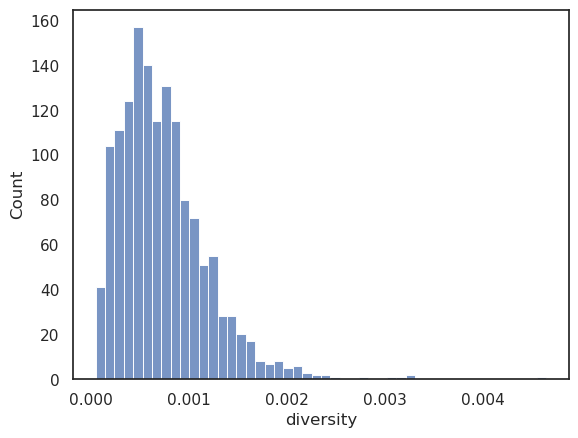

In [16]:
sns.histplot(i_diversity.diversity)

In [17]:
mean_diversity = diversity_df.groupby(["chrom", "start"])[["diversity"]].mean().reset_index()

<Axes: xlabel='diversity', ylabel='Count'>

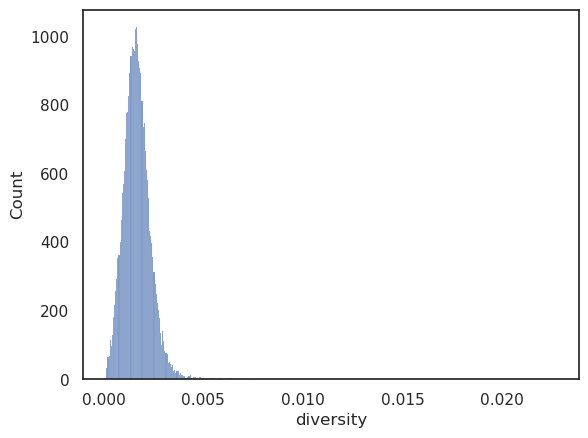

In [18]:
sns.histplot(mean_diversity.diversity)

[Text(0.5, 0, 'Background Diversity')]

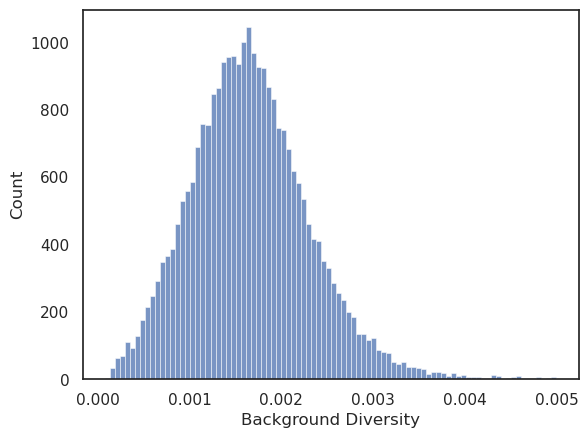

In [19]:
g = sns.histplot(mean_diversity.loc[mean_diversity.diversity <= 0.005].diversity)
g.set(xlabel = "Background Diversity")

In [20]:
metadata.Origin.unique()

array(['Mikumi, Tanzania', 'Chunga, Zambia', 'Awash, Ethiopia',
       'Serengeti, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania',
       'Ruaha, Tanzania', 'Gombe, Tanzania', 'Udzungwa, Tanzania',
       'Mahale, Tanzania', 'Selous, Tanzania', 'Lake Manyara, Tanzania',
       'Tarangire, Tanzania', 'Niokolo-Koba, Senegal',
       'Issa Valley, Tanzania', 'Dendro Park, Zambia', 'Filoha, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia'], dtype=object)

In [21]:
focus_pop_tags = ["Chunga, Zambia", "Dendro Park, Zambia", "Mikumi, Tanzania", "Mahale, Tanzania",
                  "Filoha, Ethiopia", "Serengeti, Tanzania", 'Gog Woreda, Gambella region, Ethiopia', "Niokolo-Koba, Senegal"]
window_size = 100000
all_chroms = ["chr{}".format(x) for x in (range(1, 21))]+["chrX"]

c_df_l = []
for c in all_chroms:
    print(c)
    zarr_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/" + c
    #Opening the zarr data
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    # Loading in the IDs and gt
    df_l = []
    for p in focus_pop_tags:
        if c == "chrX":
            metadata = meta_data_samples_f
            focus_pop_gt = gt.take(metadata.loc[(metadata.Origin == p) &
                                            (metadata.Sex == "F")].callset_index,
                       axis=1)
        else:
            metadata = meta_data_samples
            focus_pop_gt = gt.take(metadata.loc[metadata.Origin == p].callset_index,
                       axis=1)
        pi, windows, n_bases, counts = allel.windowed_diversity(pos, focus_pop_gt.count_alleles(),
                          size=window_size, start=0)
        df_l.append(pd.DataFrame({"chrom": c, "population": p, "start": windows[:,0], "diversity": pi}))
    focus_df = pd.concat(df_l)
    if c == "chrX":
        rf_c = "female_chrX"
    elif c == "dipmale_chrX":
        rf_c = "all_chrX"
    else:
        rf_c = c
    print(c, rf_c)
    c_df_l.append(focus_df)

chr1
chr1 chr1
chr2
chr2 chr2
chr3
chr3 chr3
chr4
chr4 chr4
chr5
chr5 chr5
chr6
chr6 chr6
chr7
chr7 chr7
chr8
chr8 chr8
chr9
chr9 chr9
chr10
chr10 chr10
chr11
chr11 chr11
chr12
chr12 chr12
chr13
chr13 chr13
chr14
chr14 chr14
chr15
chr15 chr15
chr16
chr16 chr16
chr17
chr17 chr17
chr18
chr18 chr18
chr19
chr19 chr19
chr20
chr20 chr20
chrX
chrX female_chrX


In [22]:
diversity_df_large = pd.concat(c_df_l)

In [23]:
div_heatmap = np.array(np.zeros((len(focus_pop_tags), len(focus_pop_tags))))
for i in range(len(focus_pop_tags)):
    i_diversity = diversity_df_large.loc[(diversity_df_large.population == focus_pop_tags[i]) & (diversity_df_large.chrom != "chrX")]
    ix_diversity = diversity_df_large.loc[(diversity_df_large.population == focus_pop_tags[i]) & (diversity_df_large.chrom == "chrX")]
    for j in range(i):
        print(focus_pop_tags[i], focus_pop_tags[j])
        j_diversity = diversity_df_large.loc[(diversity_df_large.population == focus_pop_tags[j]) & (diversity_df_large.chrom != "chrX")]
        res = stats.spearmanr(i_diversity.diversity, j_diversity.diversity)
        div_heatmap[i][j] = res[0]
        print(res[1])
        jx_diversity = diversity_df_large.loc[(diversity_df_large.population == focus_pop_tags[j]) & (diversity_df_large.chrom == "chrX")]
        res = stats.spearmanr(ix_diversity.diversity, jx_diversity.diversity)
        div_heatmap[j][i] = res[0]
        print(res[1])

Dendro Park, Zambia Chunga, Zambia
0.0
1.1143770585473368e-75
Mikumi, Tanzania Chunga, Zambia
0.0
4.257045679768852e-225
Mikumi, Tanzania Dendro Park, Zambia
0.0
8.511345491385742e-69
Mahale, Tanzania Chunga, Zambia
0.0
5.57288235177727e-165
Mahale, Tanzania Dendro Park, Zambia
0.0
1.1302747202073556e-67
Mahale, Tanzania Mikumi, Tanzania
0.0
2.2746245644894826e-180
Filoha, Ethiopia Chunga, Zambia
0.0
2.2347572413170712e-139
Filoha, Ethiopia Dendro Park, Zambia
0.0
4.0976643589472404e-51
Filoha, Ethiopia Mikumi, Tanzania
0.0
2.425337235012867e-149
Filoha, Ethiopia Mahale, Tanzania
0.0
9.20788070379494e-109
Serengeti, Tanzania Chunga, Zambia
0.0
7.713625634611786e-129
Serengeti, Tanzania Dendro Park, Zambia
0.0
1.9767403240906492e-78
Serengeti, Tanzania Mikumi, Tanzania
0.0
3.320574976649038e-130
Serengeti, Tanzania Mahale, Tanzania
0.0
1.5879991069492964e-77
Serengeti, Tanzania Filoha, Ethiopia
0.0
4.671342125619374e-113
Gog Woreda, Gambella region, Ethiopia Chunga, Zambia
0.0
3.2265874

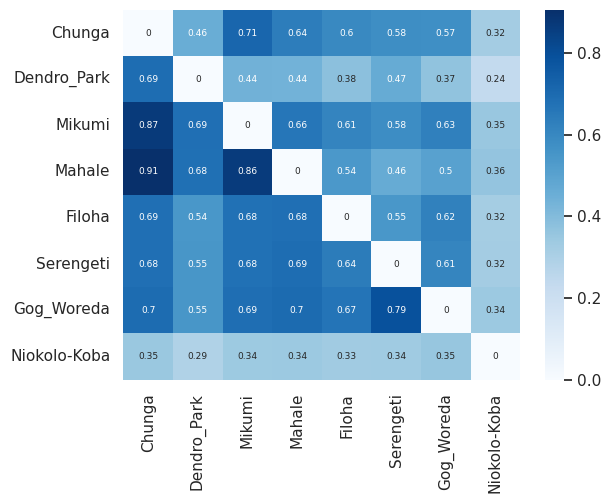

In [24]:
heatmap_df = pd.DataFrame(np.nan_to_num(div_heatmap), index = [x.replace(" ", "_").split(",")[0] for x in focus_pop_tags],
                         columns = [x.replace(" ", "_").split(",")[0] for x in focus_pop_tags])
g = sns.heatmap(heatmap_df, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, annot_kws={"fontsize":6.5})


Second version, wherein I split based on origin.

In [25]:
window_df_tanz["Origin"] = window_df_tanz.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Origin)))

In [26]:
window_df_eth["Origin"] = window_df_eth.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Origin+"_eth_case")))

In [27]:
window_df_tanz_eth = pd.concat([window_df_tanz, window_df_eth])

In [28]:
mean_window_df_tanz_eth = window_df_tanz_eth.groupby(["chrom", "Origin", "start", "end"])[["north_sum"]].mean().reset_index()
mean_window_df_tanz = window_df_tanz.groupby(["chrom", "Origin", "start", "end"])[["north_sum"]].mean().reset_index()
admix_div_mean = mean_diversity.merge(mean_window_df_tanz_eth, on=["chrom", "start"])
admix_div_mean["Species"] = admix_div_mean.Origin.map(dict(zip(meta_data_samples_sci.Origin, meta_data_samples_sci.Species)))
admix_div_mean = admix_div_mean.merge(c_r_g_df, on=["chrom", "start"])
admix_div_mean = admix_div_mean.loc[admix_div_mean.chrom != "all_chrX"]
admix_div_mean["North Percentage"] = admix_div_mean.north_sum/100000
admix_div_mean["logdiv"] = np.log10(admix_div_mean.diversity)
admix_div_mean["logrecomb"] = np.log10(admix_div_mean.average_cM_window)
admix_div_mean["norm_diversity"] = (admix_div_mean.diversity-admix_div_mean.diversity.mean())/admix_div_mean.diversity.std()
admix_div_mean["norm_recomb"] = (admix_div_mean.average_cM_window-admix_div_mean.average_cM_window.mean())/admix_div_mean.average_cM_window.std()

In [29]:
#Selecting the cases of interest and setting Minor Parent Ancestry
origins_interest = ['Arusha, Tanzania',
       'Gog Woreda, Gambella region, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia_eth_case',
       'Gombe, Tanzania', 'Issa Valley, Tanzania',
       'Katavi, Tanzania','Lake Manyara, Tanzania',
       'Mahale, Tanzania',
       'Mikumi, Tanzania', 'Ngorongoro, Tanzania', 'Ruaha, Tanzania',
       'Selous, Tanzania', 'Serengeti, Tanzania', 'Tarangire, Tanzania',
       'Udzungwa, Tanzania']
admix_div_mean = admix_div_mean.loc[admix_div_mean.Origin.isin(origins_interest)]
admix_div_mean["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Gambella region, Ethiopia_eth_case"
                                             else 1-x for x, y, z in zip(admix_div_mean["North Percentage"],
                                                                         admix_div_mean["Species"],
                                                                        admix_div_mean["Origin"])]
admix_div_mean["local_minor_ancestry"] = [min(x, 1-x) for x in admix_div_mean["North Percentage"]]

In [30]:
#Kasper prep
#kasper_div = window_df_tanz
#kasper_div["Origin"] = window_df_tanz.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Origin)))
#kasper_div = mean_diversity.merge(kasper_div, on=["chrom", "start"])
#kasper_div.to_csv("../data/autosome_diversity_admixture.txt", index=False)

<Axes: xlabel='diversity', ylabel='minor_parent_percentage'>

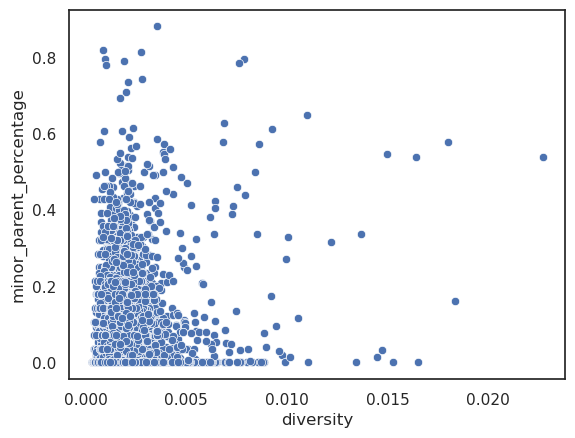

In [31]:
sns.scatterplot(admix_div_mean.loc[admix_div_mean.Origin == "Serengeti, Tanzania"], x="diversity", y="minor_parent_percentage")

<Axes: xlabel='diversity', ylabel='Count'>

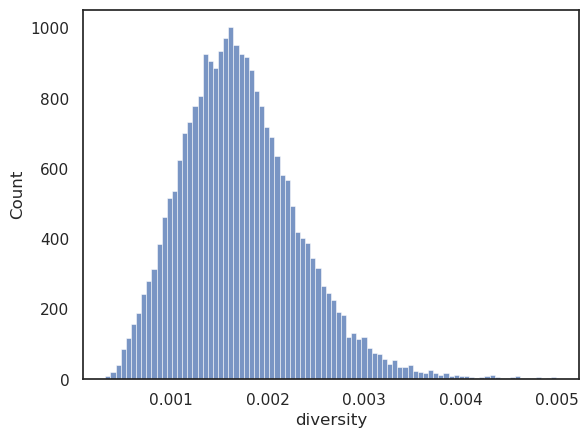

In [32]:
sns.histplot(admix_div_mean.loc[(admix_div_mean.Origin == "Serengeti, Tanzania") &
                               (admix_div_mean.diversity <= 0.005)], x="diversity")

<Axes: xlabel='diversity', ylabel='minor_parent_percentage'>

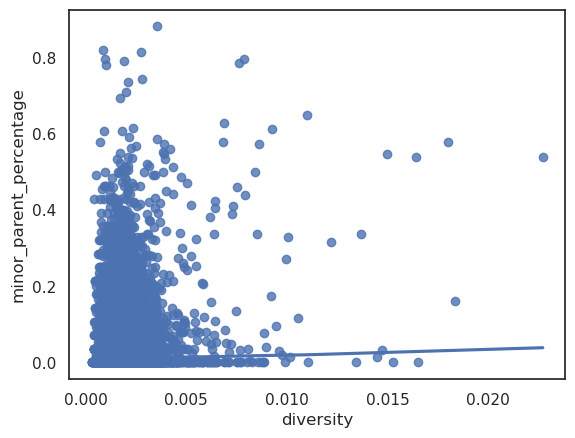

In [33]:
sns.regplot(admix_div_mean.loc[admix_div_mean.Origin == "Serengeti, Tanzania"], x="diversity", y="minor_parent_percentage", lowess=True)

<Axes: xlabel='diversity', ylabel='minor_parent_percentage'>

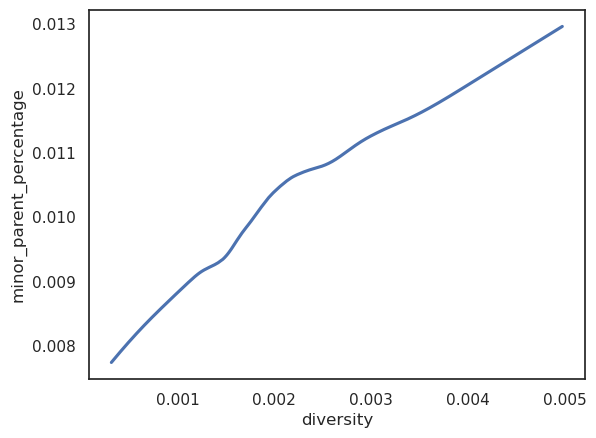

In [34]:
sns.regplot(admix_div_mean.loc[(admix_div_mean.Origin == "Serengeti, Tanzania") &
                              (admix_div_mean["minor_parent_percentage"] < 0.5) &
                               (admix_div_mean["diversity"] < 0.005) & 
                              (admix_div_mean.callable_frac > 0.9)], x="diversity", y="minor_parent_percentage",
                            lowess=True, ci=95, scatter=False)

<Axes: xlabel='average_cM_window', ylabel='diversity'>

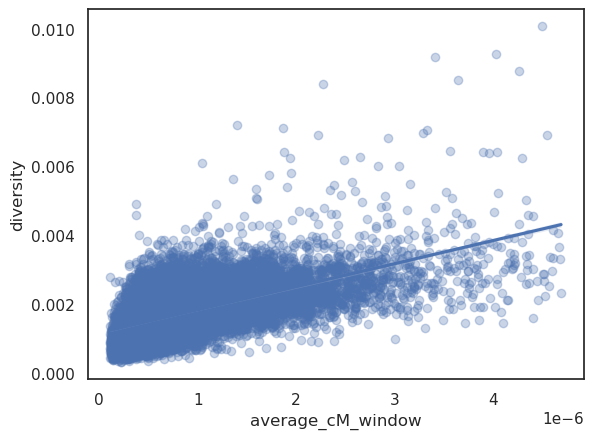

In [35]:
sns.regplot(admix_div_mean.loc[(admix_div_mean.Origin == "Serengeti, Tanzania") &
                              #(admix_div_mean["minor_parent_percentage"] < 0.5) &
                               (admix_div_mean["average_cM_window"] < 4.710987e-06) & 
                               (admix_div_mean["average_cM_window"] > 0.110987e-06) & 
                              (admix_div_mean.callable_frac > 0.75)], x="average_cM_window", y="diversity",
                            ci=95, scatter_kws={'alpha':0.3})

[Text(0, 0.5, 'Background Diversity'),
 Text(0.5, 0, 'Recombination across window (cM)')]

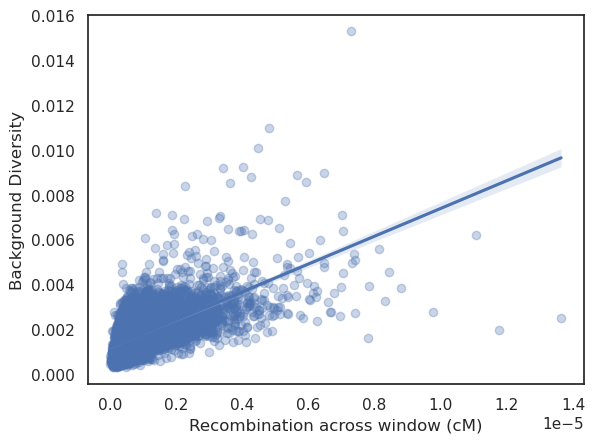

In [36]:
g = sns.regplot(admix_div_mean.loc[(admix_div_mean.Origin == "Serengeti, Tanzania") &
                              (admix_div_mean.callable_frac > 0.75)], x="average_cM_window", y="diversity",
                            ci=95, 
                scatter_kws={'alpha':0.3})
g.set(ylabel = "Background Diversity", xlabel="Recombination across window (cM)")

In [37]:
admix_div_mean.loc[(admix_div_mean.Origin == "Serengeti, Tanzania")]

chrom      start  diversity               Origin      end_x  north_sum  \
19      chr1          0    0.00306  Serengeti, Tanzania     100000   9.98e+04   
41      chr1     100000    0.00191  Serengeti, Tanzania     200000      1e+05   
63      chr1     200000    0.00115  Serengeti, Tanzania     300000      1e+05   
85      chr1     300000   0.000888  Serengeti, Tanzania     400000      1e+05   
107     chr1     400000    0.00453  Serengeti, Tanzania     500000      1e+05   
...      ...        ...        ...                  ...        ...        ...   
524487  chr9  125300000    0.00246  Serengeti, Tanzania  125400000      1e+05   
524509  chr9  125400000    0.00204  Serengeti, Tanzania  125500000      1e+05   
524531  chr9  125500000    0.00197  Serengeti, Tanzania  125600000      1e+05   
524553  chr9  125600000     0.0023  Serengeti, Tanzania  125700000      1e+05   
524575  chr9  125700000    0.00207  Serengeti, Tanzania  125800000   8.41e+04   

       Species  callable_frac      end_y         cM  ...  average_cM_window  \
19      anubis          0.795     100000          0  ...            3.6e-06   
41      anubis           0.89     200000       0.36  ...           1.16e-06   
63      anubis          0.919     300000      0.477  ...           7.05e-07   
85      anubis          0.878     400000      0.547  ...           7.94e-07   
107     anubis          0.485     500000      0.626  ...            7.4e-06   
...        ...            ...        ...        ...  ...                ...   
524487  anubis          0.878  125400000        114  ...           1.51e-06   
524509  anubis           0.87  125500000        115  ...            1.8e-06   
524531  anubis          0.864  125600000        115  ...           2.12e-06   
524553  anubis          0.869  125700000        115  ...           2.63e-06   
524575  anubis          0.343  125784620        115  ...           5.24e-06   

                                                    genes  genic  \
19      ['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...   True   
41      ['TTLL10', 'TTLL10', 'TTLL10', 'TTLL10', 'TTLL...   True   
63      ['B3GALT6', 'C1QTNF12', 'UBE2J2', 'UBE2J2', 'U...   True   
85      ['DVL1', 'DVL1', 'DVL1', 'MXRA8', 'MXRA8', 'MX...   True   
107                          ['VWA1', 'TMEM240', 'SSU72']   True   
...                                                   ...    ...   
524487  ['UTF1', 'VENTX', 'ADAM8', 'ADAM8', 'ADAM8', '...   True   
524509  ['CALY', 'CALY', 'CALY', 'PRAP1', 'PRAP1', 'FU...   True   
524531                                                 []  False   
524553                                 ['SYCE1', 'SYCE1']   True   
524575                                                 []  False   

        North Percentage     logdiv  logrecomb  norm_diversity  norm_recomb  \
19                 0.998      -2.51      -5.44            1.69          2.9   
41                     1      -2.72      -5.93           0.205        0.296   
63                     1      -2.94      -6.15          -0.769       -0.191   
85                     1      -3.05       -6.1           -1.11      -0.0965   
107                    1      -2.34      -5.13            3.58         6.95   
...                  ...        ...        ...             ...          ...   
524487                 1      -2.61      -5.82            0.92        0.664   
524509                 1      -2.69      -5.74           0.376        0.978   
524531                 1      -2.71      -5.67           0.287         1.31   
524553                 1      -2.64      -5.58           0.709         1.86   
524575             0.841      -2.68      -5.28           0.417         4.64   

        minor_parent_percentage  local_minor_ancestry  
19                       0.0016                0.0016  
41                            0                     0  
63                            0                     0  
85                            0                     0  
107                           0        

In [38]:
stats.pearsonr(admix_div_mean.loc[(admix_div_mean.callable_frac > 0.75)].average_cM_window,
               admix_div_mean.loc[(admix_div_mean.callable_frac > 0.75)].diversity)

PearsonRResult(statistic=0.6024658177187425, pvalue=0.0)

In [39]:
stats.spearmanr(admix_div_mean.loc[(admix_div_mean.callable_frac > 0.75)].average_cM_window,
                admix_div_mean.loc[(admix_div_mean.callable_frac > 0.75)].diversity)

SignificanceResult(statistic=0.6165114567403792, pvalue=0.0)

In [40]:
admix_div_mean.loc[(admix_div_mean.callable_frac > 0.75)
                   & (admix_div_mean.Origin == "Serengeti, Tanzania")].diversity.mean(), admix_div_mean.loc[(admix_div_mean.callable_frac > 0.75)
                   & (admix_div_mean.Origin == "Serengeti, Tanzania")].diversity.median()

(0.0017245076605363653, 0.001658228842197082)

<Axes: xlabel='average_cM_window', ylabel='Count'>

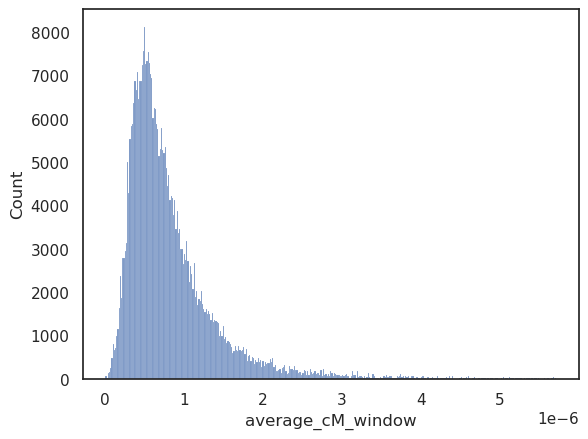

In [41]:
sns.histplot(admix_div_mean.loc[(admix_div_mean["average_cM_window"] < 5.710987e-06)], x="average_cM_window")

<Axes: xlabel='diversity', ylabel='minor_parent_percentage'>

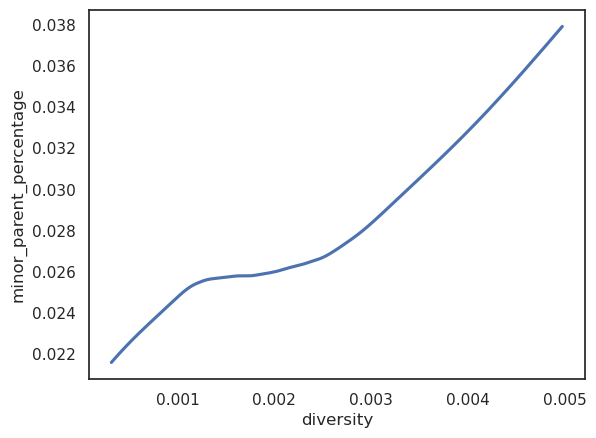

In [42]:
sns.regplot(admix_div_mean.loc[(admix_div_mean.Origin == "Lake Manyara, Tanzania") &
                              (admix_div_mean["minor_parent_percentage"] < 0.5) &
                               (admix_div_mean["diversity"] < 0.005) & 
                              (admix_div_mean.callable_frac > 0.9)], x="diversity", y="minor_parent_percentage",
                            lowess=True, ci=95, scatter=False)

In [43]:
yellows = ['Mikumi, Tanzania', 'Ruaha, Tanzania', 'Selous, Tanzania', 'Udzungwa, Tanzania']
olives = ['Serengeti, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania',
          'Lake Manyara, Tanzania','Arusha, Tanzania']
olives_with_tarangire = ['Serengeti, Tanzania', 'Tarangire, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania',
          'Lake Manyara, Tanzania','Arusha, Tanzania']
gog = ['Gog Woreda, Ethiopia']
result_order = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Tarangire, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania', 'Gog Woreda, Ethiopia']
result_order_no_gog = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania']

In [44]:
import copy
from textwrap import dedent
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    import statsmodels
    assert statsmodels
    _has_statsmodels = True
except ImportError:
    _has_statsmodels = False

from seaborn import utils
from seaborn import algorithms as algo
from seaborn.axisgrid import FacetGrid, _facet_docs


__all__ = ["lmplot", "regplot", "residplot"]


class _LinearPlotter:
    """Base class for plotting relational data in tidy format.

    To get anything useful done you'll have to inherit from this, but setup
    code that can be abstracted out should be put here.

    """
    def establish_variables(self, data, **kws):
        """Extract variables from data or use directly."""
        self.data = data

        # Validate the inputs
        any_strings = any([isinstance(v, str) for v in kws.values()])
        if any_strings and data is None:
            raise ValueError("Must pass `data` if using named variables.")

        # Set the variables
        for var, val in kws.items():
            if isinstance(val, str):
                vector = data[val]
            elif isinstance(val, list):
                vector = np.asarray(val)
            else:
                vector = val
            if vector is not None and vector.shape != (1,):
                vector = np.squeeze(vector)
            if np.ndim(vector) > 1:
                err = "regplot inputs must be 1d"
                raise ValueError(err)
            setattr(self, var, vector)

    def dropna(self, *vars):
        """Remove observations with missing data."""
        vals = [getattr(self, var) for var in vars]
        vals = [v for v in vals if v is not None]
        not_na = np.all(np.column_stack([pd.notnull(v) for v in vals]), axis=1)
        for var in vars:
            val = getattr(self, var)
            if val is not None:
                setattr(self, var, val[not_na])

    def plot(self, ax):
        raise NotImplementedError


class _RegressionPlotter(_LinearPlotter):
    """Plotter for numeric independent variables with regression model.

    This does the computations and drawing for the `regplot` function, and
    is thus also used indirectly by `lmplot`.
    """
    def __init__(self, x, y, data=None, x_estimator=None, x_bins=None,
                 x_ci="ci", scatter=True, fit_reg=True, ci=95, n_boot=1000,
                 units=None, seed=None, order=1, logistic=False, lowess=False,
                 robust=False, weighted=False, logx=False, x_partial=None, y_partial=None,
                 truncate=False, dropna=True, x_jitter=None, y_jitter=None,
                 color=None, label=None):

        # Set member attributes
        self.x_estimator = x_estimator
        self.ci = ci
        self.x_ci = ci if x_ci == "ci" else x_ci
        self.n_boot = n_boot
        self.seed = seed
        self.scatter = scatter
        self.fit_reg = fit_reg
        self.order = order
        self.logistic = logistic
        self.weighted = weighted
        self.lowess = lowess
        self.robust = robust
        self.logx = logx
        self.truncate = truncate
        self.x_jitter = x_jitter
        self.y_jitter = y_jitter
        self.color = color
        self.label = label

        # Validate the regression options:
        #if sum((order > 1, logistic, robust, weighted, lowess, logx)) > 1:
        #    raise ValueError("Mutually exclusive regression options.")

        # Extract the data vals from the arguments or passed dataframe
        self.establish_variables(data, x=x, y=y, units=units,
                                 x_partial=x_partial, y_partial=y_partial)

        # Drop null observations
        if dropna:
            self.dropna("x", "y", "units", "x_partial", "y_partial")

        # Regress nuisance variables out of the data
        if self.x_partial is not None:
            self.x = self.regress_out(self.x, self.x_partial)
        if self.y_partial is not None:
            self.y = self.regress_out(self.y, self.y_partial)

        # Possibly bin the predictor variable, which implies a point estimate
        if x_bins is not None:
            self.x_estimator = np.mean if x_estimator is None else x_estimator
            x_discrete, x_bins = self.bin_predictor(x_bins)
            self.x_discrete = x_discrete
        else:
            self.x_discrete = self.x

        # Disable regression in case of singleton inputs
        if len(self.x) <= 1:
            self.fit_reg = False

        # Save the range of the x variable for the grid later
        if self.fit_reg:
            self.x_range = self.x.min(), self.x.max()

    @property
    def scatter_data(self):
        """Data where each observation is a point."""
        x_j = self.x_jitter
        if x_j is None:
            x = self.x
        else:
            x = self.x + np.random.uniform(-x_j, x_j, len(self.x))

        y_j = self.y_jitter
        if y_j is None:
            y = self.y
        else:
            y = self.y + np.random.uniform(-y_j, y_j, len(self.y))

        return x, y

    @property
    def estimate_data(self):
        """Data with a point estimate and CI for each discrete x value."""
        x, y = self.x_discrete, self.y
        vals = sorted(np.unique(x))
        points, cis = [], []

        for val in vals:

            # Get the point estimate of the y variable
            _y = y[x == val]
            est = self.x_estimator(_y)
            points.append(est)

            # Compute the confidence interval for this estimate
            if self.x_ci is None:
                cis.append(None)
            else:
                units = None
                if self.x_ci == "sd":
                    sd = np.std(_y)
                    _ci = est - sd, est + sd
                else:
                    if self.units is not None:
                        units = self.units[x == val]
                    boots = algo.bootstrap(_y,
                                           func=self.x_estimator,
                                           n_boot=self.n_boot,
                                           units=units,
                                           seed=self.seed)
                    _ci = utils.ci(boots, self.x_ci)
                cis.append(_ci)

        return vals, points, cis

    def _check_statsmodels(self):
        """Check whether statsmodels is installed if any boolean options require it."""
        options = "logistic", "robust", "lowess"
        err = "`{}=True` requires statsmodels, an optional dependency, to be installed."
        for option in options:
            if getattr(self, option) and not _has_statsmodels:
                raise RuntimeError(err.format(option))

    def fit_regression(self, ax=None, x_range=None, grid=None):
        """Fit the regression model."""
        self._check_statsmodels()

        # Create the grid for the regression
        if grid is None:
            if self.truncate:
                x_min, x_max = self.x_range
            else:
                if ax is None:
                    x_min, x_max = x_range
                else:
                    x_min, x_max = ax.get_xlim()
            grid = np.linspace(x_min, x_max, 100)
        ci = self.ci

        # Fit the regression
        if self.order > 1:
            yhat, yhat_boots = self.fit_poly(grid, self.order)
        elif self.logistic: 
            from statsmodels.genmod.generalized_linear_model import GLM
            from statsmodels.genmod.families import Binomial
            yhat, yhat_boots = self.fit_statsmodels(grid, GLM,
                                                    family=Binomial())
        elif self.weighted: 
            from statsmodels.genmod.generalized_linear_model import GLM
            from statsmodels.genmod.families import Binomial
            yhat, yhat_boots = self.fit_statsmodels(grid, GLM,
                                                   var_weights=np.asarray(self.x))
        elif self.lowess:
            ci = None
            grid, yhat = self.fit_lowess()
        elif self.robust:
            from statsmodels.robust.robust_linear_model import RLM
            yhat, yhat_boots = self.fit_statsmodels(grid, RLM)
        elif self.logx:
            yhat, yhat_boots = self.fit_logx(grid)
        else:
            yhat, yhat_boots = self.fit_fast(grid)

        # Compute the confidence interval at each grid point
        if ci is None:
            err_bands = None
        else:
            err_bands = utils.ci(yhat_boots, ci, axis=0)

        return grid, yhat, err_bands

    def fit_fast(self, grid):
        """Low-level regression and prediction using linear algebra."""
        def reg_func(_x, _y):
            return np.linalg.pinv(_x).dot(_y)

        X, y = np.c_[np.ones(len(self.x)), self.x], self.y
        grid = np.c_[np.ones(len(grid)), grid]
        yhat = grid.dot(reg_func(X, y))
        if self.ci is None:
            return yhat, None

        beta_boots = algo.bootstrap(X, y,
                                    func=reg_func,
                                    n_boot=self.n_boot,
                                    units=self.units,
                                    seed=self.seed).T
        yhat_boots = grid.dot(beta_boots).T
        return yhat, yhat_boots

    def fit_poly(self, grid, order):
        """Regression using numpy polyfit for higher-order trends."""
        def reg_func(_x, _y):
            return np.polyval(np.polyfit(_x, _y, order), grid)

        x, y = self.x, self.y
        yhat = reg_func(x, y)
        if self.ci is None:
            return yhat, None

        yhat_boots = algo.bootstrap(x, y,
                                    func=reg_func,
                                    n_boot=self.n_boot,
                                    units=self.units,
                                    seed=self.seed)
        return yhat, yhat_boots

    def fit_statsmodels(self, grid, model, **kwargs):
        """More general regression function using statsmodels objects."""
        import statsmodels.tools.sm_exceptions as sme
        X, y = np.c_[np.ones(len(self.x)), self.x], self.y
        grid = np.c_[np.ones(len(grid)), grid]
        def reg_func(_x, _y, **kwargs):
            err_classes = (sme.PerfectSeparationError,)
            try:
                with warnings.catch_warnings():
                    if hasattr(sme, "PerfectSeparationWarning"):
                        # statsmodels>=0.14.0
                        warnings.simplefilter("error", sme.PerfectSeparationWarning)
                        err_classes = (*err_classes, sme.PerfectSeparationWarning)
                    m = model(_y, _x, var_weights=np.asarray(_x[:, 1])).fit()
                    yhat = m.predict(grid)
                    #print(m.summary(), self.x, len(_x), _x[:, 1])
            except err_classes:
                yhat = np.empty(len(grid))
                yhat.fill(np.nan)
            return yhat

        yhat = reg_func(X, y, **kwargs)
        if self.ci is None:
            return yhat, None

        yhat_boots = bootstrap(X, y,
                                    func=reg_func,
                                    n_boot=self.n_boot,
                                    units=self.units,
                                    seed=self.seed,
                                   var_weights=np.asarray(self.x))
        return yhat, yhat_boots

    def fit_lowess(self):
        """Fit a locally-weighted regression, which returns its own grid."""
        from statsmodels.nonparametric.smoothers_lowess import lowess
        grid, yhat = lowess(self.y, self.x).T
        return grid, yhat

    def fit_logx(self, grid):
        """Fit the model in log-space."""
        X, y = np.c_[np.ones(len(self.x)), self.x], self.y
        grid = np.c_[np.ones(len(grid)), np.log(grid)]

        def reg_func(_x, _y):
            _x = np.c_[_x[:, 0], np.log(_x[:, 1])]
            return np.linalg.pinv(_x).dot(_y)

        yhat = grid.dot(reg_func(X, y))
        if self.ci is None:
            return yhat, None

        beta_boots = algo.bootstrap(X, y,
                                    func=reg_func,
                                    n_boot=self.n_boot,
                                    units=self.units,
                                    seed=self.seed).T
        yhat_boots = grid.dot(beta_boots).T
        return yhat, yhat_boots

    def bin_predictor(self, bins):
        """Discretize a predictor by assigning value to closest bin."""
        x = np.asarray(self.x)
        if np.isscalar(bins):
            percentiles = np.linspace(0, 100, bins + 2)[1:-1]
            bins = np.percentile(x, percentiles)
        else:
            bins = np.ravel(bins)

        dist = np.abs(np.subtract.outer(x, bins))
        x_binned = bins[np.argmin(dist, axis=1)].ravel()

        return x_binned, bins

    def regress_out(self, a, b):
        """Regress b from a keeping a's original mean."""
        a_mean = a.mean()
        a = a - a_mean
        b = b - b.mean()
        b = np.c_[b]
        a_prime = a - b.dot(np.linalg.pinv(b).dot(a))
        return np.asarray(a_prime + a_mean).reshape(a.shape)

    def plot(self, ax, scatter_kws, line_kws):
        """Draw the full plot."""
        # Insert the plot label into the correct set of keyword arguments
        if self.scatter:
            scatter_kws["label"] = self.label
        else:
            line_kws["label"] = self.label

        # Use the current color cycle state as a default
        if self.color is None:
            lines, = ax.plot([], [])
            color = lines.get_color()
            lines.remove()
        else:
            color = self.color

        # Ensure that color is hex to avoid matplotlib weirdness
        color = mpl.colors.rgb2hex(mpl.colors.colorConverter.to_rgb(color))

        # Let color in keyword arguments override overall plot color
        scatter_kws.setdefault("color", color)
        line_kws.setdefault("color", color)

        # Draw the constituent plots
        if self.scatter:
            self.scatterplot(ax, scatter_kws)

        if self.fit_reg:
            self.lineplot(ax, line_kws)

        # Label the axes
        if hasattr(self.x, "name"):
            ax.set_xlabel(self.x.name)
        if hasattr(self.y, "name"):
            ax.set_ylabel(self.y.name)

    def scatterplot(self, ax, kws):
        """Draw the data."""
        # Treat the line-based markers specially, explicitly setting larger
        # linewidth than is provided by the seaborn style defaults.
        # This would ideally be handled better in matplotlib (i.e., distinguish
        # between edgewidth for solid glyphs and linewidth for line glyphs
        # but this should do for now.
        line_markers = ["1", "2", "3", "4", "+", "x", "|", "_"]
        if self.x_estimator is None:
            if "marker" in kws and kws["marker"] in line_markers:
                lw = mpl.rcParams["lines.linewidth"]
            else:
                lw = mpl.rcParams["lines.markeredgewidth"]
            kws.setdefault("linewidths", lw)

            if not hasattr(kws['color'], 'shape') or kws['color'].shape[1] < 4:
                kws.setdefault("alpha", .8)

            x, y = self.scatter_data
            ax.scatter(x, y, **kws)
        else:
            # TODO abstraction
            ci_kws = {"color": kws["color"]}
            if "alpha" in kws:
                ci_kws["alpha"] = kws["alpha"]
            ci_kws["linewidth"] = mpl.rcParams["lines.linewidth"] * 1.75
            kws.setdefault("s", 50)

            xs, ys, cis = self.estimate_data
            if [ci for ci in cis if ci is not None]:
                for x, ci in zip(xs, cis):
                    ax.plot([x, x], ci, **ci_kws)
            ax.scatter(xs, ys, **kws)

    def lineplot(self, ax, kws):
        """Draw the model."""
        # Fit the regression model
        grid, yhat, err_bands = self.fit_regression(ax)
        edges = grid[0], grid[-1]

        # Get set default aesthetics
        fill_color = kws["color"]
        lw = kws.pop("lw", mpl.rcParams["lines.linewidth"] * 1.5)
        kws.setdefault("linewidth", lw)

        # Draw the regression line and confidence interval
        line, = ax.plot(grid, yhat, **kws)
        if not self.truncate:
            line.sticky_edges.x[:] = edges  # Prevent mpl from adding margin
        if err_bands is not None:
            ax.fill_between(grid, *err_bands, facecolor=fill_color, alpha=.15)


_regression_docs = dict(

    model_api=dedent("""\
    There are a number of mutually exclusive options for estimating the
    regression model. See the :ref:`tutorial <regression_tutorial>` for more
    information.\
    """),
    regplot_vs_lmplot=dedent("""\
    The :func:`regplot` and :func:`lmplot` functions are closely related, but
    the former is an axes-level function while the latter is a figure-level
    function that combines :func:`regplot` and :class:`FacetGrid`.\
    """),
    x_estimator=dedent("""\
    x_estimator : callable that maps vector -> scalar, optional
        Apply this function to each unique value of ``x`` and plot the
        resulting estimate. This is useful when ``x`` is a discrete variable.
        If ``x_ci`` is given, this estimate will be bootstrapped and a
        confidence interval will be drawn.\
    """),
    x_bins=dedent("""\
    x_bins : int or vector, optional
        Bin the ``x`` variable into discrete bins and then estimate the central
        tendency and a confidence interval. This binning only influences how
        the scatterplot is drawn; the regression is still fit to the original
        data.  This parameter is interpreted either as the number of
        evenly-sized (not necessary spaced) bins or the positions of the bin
        centers. When this parameter is used, it implies that the default of
        ``x_estimator`` is ``numpy.mean``.\
    """),
    x_ci=dedent("""\
    x_ci : "ci", "sd", int in [0, 100] or None, optional
        Size of the confidence interval used when plotting a central tendency
        for discrete values of ``x``. If ``"ci"``, defer to the value of the
        ``ci`` parameter. If ``"sd"``, skip bootstrapping and show the
        standard deviation of the observations in each bin.\
    """),
    scatter=dedent("""\
    scatter : bool, optional
        If ``True``, draw a scatterplot with the underlying observations (or
        the ``x_estimator`` values).\
    """),
    fit_reg=dedent("""\
    fit_reg : bool, optional
        If ``True``, estimate and plot a regression model relating the ``x``
        and ``y`` variables.\
    """),
    ci=dedent("""\
    ci : int in [0, 100] or None, optional
        Size of the confidence interval for the regression estimate. This will
        be drawn using translucent bands around the regression line. The
        confidence interval is estimated using a bootstrap; for large
        datasets, it may be advisable to avoid that computation by setting
        this parameter to None.\
    """),
    n_boot=dedent("""\
    n_boot : int, optional
        Number of bootstrap resamples used to estimate the ``ci``. The default
        value attempts to balance time and stability; you may want to increase
        this value for "final" versions of plots.\
    """),
    units=dedent("""\
    units : variable name in ``data``, optional
        If the ``x`` and ``y`` observations are nested within sampling units,
        those can be specified here. This will be taken into account when
        computing the confidence intervals by performing a multilevel bootstrap
        that resamples both units and observations (within unit). This does not
        otherwise influence how the regression is estimated or drawn.\
    """),
    seed=dedent("""\
    seed : int, numpy.random.Generator, or numpy.random.RandomState, optional
        Seed or random number generator for reproducible bootstrapping.\
    """),
    order=dedent("""\
    order : int, optional
        If ``order`` is greater than 1, use ``numpy.polyfit`` to estimate a
        polynomial regression.\
    """),
    logistic=dedent("""\
    logistic : bool, optional
        If ``True``, assume that ``y`` is a binary variable and use
        ``statsmodels`` to estimate a logistic regression model. Note that this
        is substantially more computationally intensive than linear regression,
        so you may wish to decrease the number of bootstrap resamples
        (``n_boot``) or set ``ci`` to None.\
    """),
    lowess=dedent("""\
    lowess : bool, optional
        If ``True``, use ``statsmodels`` to estimate a nonparametric lowess
        model (locally weighted linear regression). Note that confidence
        intervals cannot currently be drawn for this kind of model.\
    """),
    robust=dedent("""\
    robust : bool, optional
        If ``True``, use ``statsmodels`` to estimate a robust regression. This
        will de-weight outliers. Note that this is substantially more
        computationally intensive than standard linear regression, so you may
        wish to decrease the number of bootstrap resamples (``n_boot``) or set
        ``ci`` to None.\
    """),
    logx=dedent("""\
    logx : bool, optional
        If ``True``, estimate a linear regression of the form y ~ log(x), but
        plot the scatterplot and regression model in the input space. Note that
        ``x`` must be positive for this to work.\
    """),
    xy_partial=dedent("""\
    {x,y}_partial : strings in ``data`` or matrices
        Confounding variables to regress out of the ``x`` or ``y`` variables
        before plotting.\
    """),
    truncate=dedent("""\
    truncate : bool, optional
        If ``True``, the regression line is bounded by the data limits. If
        ``False``, it extends to the ``x`` axis limits.
    """),
    dropna=dedent("""\
    dropna : bool, optional
        If ``True``, remove observations with missing data from the plot.
    """),
    xy_jitter=dedent("""\
    {x,y}_jitter : floats, optional
        Add uniform random noise of this size to either the ``x`` or ``y``
        variables. The noise is added to a copy of the data after fitting the
        regression, and only influences the look of the scatterplot. This can
        be helpful when plotting variables that take discrete values.\
    """),
    scatter_line_kws=dedent("""\
    {scatter,line}_kws : dictionaries
        Additional keyword arguments to pass to ``plt.scatter`` and
        ``plt.plot``.\
    """),
)
_regression_docs.update(_facet_docs)


def lmplot(
    data, *,
    x=None, y=None, hue=None, col=None, row=None,
    palette=None, col_wrap=None, height=5, aspect=1, markers="o",
    sharex=None, sharey=None, hue_order=None, col_order=None, row_order=None,
    legend=True, legend_out=None, x_estimator=None, x_bins=None,
    x_ci="ci", scatter=True, fit_reg=True, ci=95, n_boot=1000,
    units=None, seed=None, order=1, logistic=False, lowess=False,
    robust=False, weighted=False, logx=False, x_partial=None, y_partial=None,
    truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None,
    line_kws=None, facet_kws=None,
):

    if facet_kws is None:
        facet_kws = {}

    def facet_kw_deprecation(key, val):
        msg = (
            f"{key} is deprecated from the `lmplot` function signature. "
            "Please update your code to pass it using `facet_kws`."
        )
        if val is not None:
            warnings.warn(msg, UserWarning)
            facet_kws[key] = val

    facet_kw_deprecation("sharex", sharex)
    facet_kw_deprecation("sharey", sharey)
    facet_kw_deprecation("legend_out", legend_out)

    if data is None:
        raise TypeError("Missing required keyword argument `data`.")

    # Reduce the dataframe to only needed columns
    need_cols = [x, y, hue, col, row, units, x_partial, y_partial]
    cols = np.unique([a for a in need_cols if a is not None]).tolist()
    data = data[cols]

    # Initialize the grid
    facets = FacetGrid(
        data, row=row, col=col, hue=hue,
        palette=palette,
        row_order=row_order, col_order=col_order, hue_order=hue_order,
        height=height, aspect=aspect, col_wrap=col_wrap,
        **facet_kws,
    )

    # Add the markers here as FacetGrid has figured out how many levels of the
    # hue variable are needed and we don't want to duplicate that process
    if facets.hue_names is None:
        n_markers = 1
    else:
        n_markers = len(facets.hue_names)
    if not isinstance(markers, list):
        markers = [markers] * n_markers
    if len(markers) != n_markers:
        raise ValueError("markers must be a singleton or a list of markers "
                         "for each level of the hue variable")
    facets.hue_kws = {"marker": markers}

    #def update_datalim(data, x, y, ax, **kws):
    #    xys = data[[x, y]].to_numpy().astype(float)
    #    ax.update_datalim(xys, updatey=False)
    #    ax.autoscale_view(scaley=False)

    #facets.map_dataframe(update_datalim, x=x, y=y)

    # Draw the regression plot on each facet
    regplot_kws = dict(
        x_estimator=x_estimator, x_bins=x_bins, x_ci=x_ci,
        scatter=scatter, fit_reg=fit_reg, ci=ci, n_boot=n_boot, units=units,
        seed=seed, order=order, logistic=logistic, lowess=lowess,
        robust=robust, weighted=weighted, logx=logx, x_partial=x_partial, y_partial=y_partial,
        truncate=truncate, x_jitter=x_jitter, y_jitter=y_jitter,
        scatter_kws=scatter_kws, line_kws=line_kws,
    )
    facets.map_dataframe(regplot, x=x, y=y, **regplot_kws)
    facets.set_axis_labels(x, y)

    # Add a legend
    if legend and (hue is not None) and (hue not in [col, row]):
        facets.add_legend()
    return facets


lmplot.__doc__ = dedent("""\
    Plot data and regression model fits across a FacetGrid.

    This function combines :func:`regplot` and :class:`FacetGrid`. It is
    intended as a convenient interface to fit regression models across
    conditional subsets of a dataset.

    When thinking about how to assign variables to different facets, a general
    rule is that it makes sense to use ``hue`` for the most important
    comparison, followed by ``col`` and ``row``. However, always think about
    your particular dataset and the goals of the visualization you are
    creating.

    {model_api}

    The parameters to this function span most of the options in
    :class:`FacetGrid`, although there may be occasional cases where you will
    want to use that class and :func:`regplot` directly.

    Parameters
    ----------
    {data}
    x, y : strings, optional
        Input variables; these should be column names in ``data``.
    hue, col, row : strings
        Variables that define subsets of the data, which will be drawn on
        separate facets in the grid. See the ``*_order`` parameters to control
        the order of levels of this variable.
    {palette}
    {col_wrap}
    {height}
    {aspect}
    markers : matplotlib marker code or list of marker codes, optional
        Markers for the scatterplot. If a list, each marker in the list will be
        used for each level of the ``hue`` variable.
    {share_xy}

        .. deprecated:: 0.12.0
            Pass using the `facet_kws` dictionary.

    {{hue,col,row}}_order : lists, optional
        Order for the levels of the faceting variables. By default, this will
        be the order that the levels appear in ``data`` or, if the variables
        are pandas categoricals, the category order.
    legend : bool, optional
        If ``True`` and there is a ``hue`` variable, add a legend.
    {legend_out}

        .. deprecated:: 0.12.0
            Pass using the `facet_kws` dictionary.

    {x_estimator}
    {x_bins}
    {x_ci}
    {scatter}
    {fit_reg}
    {ci}
    {n_boot}
    {units}
    {seed}
    {order}
    {logistic}
    {lowess}
    {robust}
    {logx}
    {xy_partial}
    {truncate}
    {xy_jitter}
    {scatter_line_kws}
    facet_kws : dict
        Dictionary of keyword arguments for :class:`FacetGrid`.

    Returns
    -------
    :class:`FacetGrid`
        The :class:`FacetGrid` object with the plot on it for further tweaking.

    See Also
    --------
    regplot : Plot data and a conditional model fit.
    FacetGrid : Subplot grid for plotting conditional relationships.
    pairplot : Combine :func:`regplot` and :class:`PairGrid` (when used with
               ``kind="reg"``).

    Notes
    -----

    {regplot_vs_lmplot}

    Examples
    --------

    .. include:: ../docstrings/lmplot.rst

    """).format(**_regression_docs)


def regplot(
    data=None, *, x=None, y=None,
    x_estimator=None, x_bins=None, x_ci="ci",
    scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None,
    seed=None, order=1, logistic=False, lowess=False, robust=False, weighted=False,
    logx=False, x_partial=None, y_partial=None,
    truncate=True, dropna=True, x_jitter=None, y_jitter=None,
    label=None, color=None, marker="o",
    scatter_kws=None, line_kws=None, ax=None
):

    plotter = _RegressionPlotter(x, y, data, x_estimator, x_bins, x_ci,
                                 scatter, fit_reg, ci, n_boot, units, seed,
                                 order, logistic, lowess, robust, weighted, logx,
                                 x_partial, y_partial, truncate, dropna,
                                 x_jitter, y_jitter, color, label)

    if ax is None:
        ax = plt.gca()

    scatter_kws = {} if scatter_kws is None else copy.copy(scatter_kws)
    scatter_kws["marker"] = marker
    line_kws = {} if line_kws is None else copy.copy(line_kws)
    plotter.plot(ax, scatter_kws, line_kws)
    return ax


regplot.__doc__ = dedent("""\
    Plot data and a linear regression model fit.

    {model_api}

    Parameters
    ----------
    x, y : string, series, or vector array
        Input variables. If strings, these should correspond with column names
        in ``data``. When pandas objects are used, axes will be labeled with
        the series name.
    {data}
    {x_estimator}
    {x_bins}
    {x_ci}
    {scatter}
    {fit_reg}
    {ci}
    {n_boot}
    {units}
    {seed}
    {order}
    {logistic}
    {lowess}
    {robust}
    {logx}
    {xy_partial}
    {truncate}
    {dropna}
    {xy_jitter}
    label : string
        Label to apply to either the scatterplot or regression line (if
        ``scatter`` is ``False``) for use in a legend.
    color : matplotlib color
        Color to apply to all plot elements; will be superseded by colors
        passed in ``scatter_kws`` or ``line_kws``.
    marker : matplotlib marker code
        Marker to use for the scatterplot glyphs.
    {scatter_line_kws}
    ax : matplotlib Axes, optional
        Axes object to draw the plot onto, otherwise uses the current Axes.

    Returns
    -------
    ax : matplotlib Axes
        The Axes object containing the plot.

    See Also
    --------
    lmplot : Combine :func:`regplot` and :class:`FacetGrid` to plot multiple
             linear relationships in a dataset.
    jointplot : Combine :func:`regplot` and :class:`JointGrid` (when used with
                ``kind="reg"``).
    pairplot : Combine :func:`regplot` and :class:`PairGrid` (when used with
               ``kind="reg"``).
    residplot : Plot the residuals of a linear regression model.

    Notes
    -----

    {regplot_vs_lmplot}


    It's also easy to combine :func:`regplot` and :class:`JointGrid` or
    :class:`PairGrid` through the :func:`jointplot` and :func:`pairplot`
    functions, although these do not directly accept all of :func:`regplot`'s
    parameters.

    Examples
    --------

    .. include:: ../docstrings/regplot.rst

    """).format(**_regression_docs)


def bootstrap(*args, **kwargs):
    """Resample one or more arrays with replacement and store aggregate values.

    Positional arguments are a sequence of arrays to bootstrap along the first
    axis and pass to a summary function.

    Keyword arguments:
        n_boot : int, default=10000
            Number of iterations
        axis : int, default=None
            Will pass axis to ``func`` as a keyword argument.
        units : array, default=None
            Array of sampling unit IDs. When used the bootstrap resamples units
            and then observations within units instead of individual
            datapoints.
        func : string or callable, default="mean"
            Function to call on the args that are passed in. If string, uses as
            name of function in the numpy namespace. If nans are present in the
            data, will try to use nan-aware version of named function.
        seed : Generator | SeedSequence | RandomState | int | None
            Seed for the random number generator; useful if you want
            reproducible resamples.

    Returns
    -------
    boot_dist: array
        array of bootstrapped statistic values

    """
    # Ensure list of arrays are same length
    if len(np.unique(list(map(len, args)))) > 1:
        raise ValueError("All input arrays must have the same length")
    n = len(args[0])

    # Default keyword arguments
    n_boot = kwargs.get("n_boot", 10000)
    func = kwargs.get("func", "mean")
    axis = kwargs.get("axis", None)
    units = kwargs.get("units", None)
    var_weights = kwargs.get("var_weights", None)
    random_seed = kwargs.get("random_seed", None)
    if random_seed is not None:
        msg = "`random_seed` has been renamed to `seed` and will be removed"
        warnings.warn(msg)
    seed = kwargs.get("seed", random_seed)
    if axis is None:
        func_kwargs = dict()
    else:
        func_kwargs = dict(axis=axis)

    # Initialize the resampler
    if isinstance(seed, np.random.RandomState):
        rng = seed
    else:
        rng = np.random.default_rng(seed)

    # Coerce to arrays
    args = list(map(np.asarray, args))
    if units is not None:
        units = np.asarray(units)

    if isinstance(func, str):

        # Allow named numpy functions
        f = getattr(np, func)

        # Try to use nan-aware version of function if necessary
        missing_data = np.isnan(np.sum(np.column_stack(args)))

        if missing_data and not func.startswith("nan"):
            nanf = getattr(np, f"nan{func}", None)
            if nanf is None:
                msg = f"Data contain nans but no nan-aware version of `{func}` found"
                warnings.warn(msg, UserWarning)
            else:
                f = nanf

    else:
        f = func

    # Handle numpy changes
    try:
        integers = rng.integers
    except AttributeError:
        integers = rng.randint


    boot_dist = []
    for i in range(int(n_boot)):
        resampler = integers(0, n, n, dtype=np.intp)  # intp is indexing dtype
        sample = [a.take(resampler, axis=0) for a in args]
        boot_dist.append(f(*sample, **func_kwargs))
    return np.array(boot_dist)

In [45]:
filter_callable = admix_div_mean.loc[admix_div_mean.callable_frac > 0.75]
filter_callable.loc[filter_callable['Origin'] == 'Gog Woreda, Gambella region, Ethiopia_eth_case', ['Origin']] = 'Gog Woreda, Ethiopia'
filter_callable["diversity"].quantile([0.005, 0.995])

0.005     0.000513
0.995      0.00408
Name: diversity, dtype: float64

In [85]:
len(filter_callable)/len(admix_div_mean)

0.9890009716548431

In [46]:
filter_callable = admix_div_mean.loc[admix_div_mean.callable_frac > 0.75]
filter_callable.loc[filter_callable['Origin'] == 'Gog Woreda, Gambella region, Ethiopia_eth_case', ['Origin']] = 'Gog Woreda, Ethiopia'
filter_qcut = filter_callable.loc[(filter_callable.diversity >= 0.000513) &
                                 (filter_callable.diversity <= 0.00408)]

In [47]:
o_l, stat_l, pval_l = [], [], []
for o in result_order:
    o_div = filter_callable.loc[filter_callable.Origin == o]
    o_div = o_div.loc[(o_div.minor_parent_percentage < 0.5)]
    st, pval = stats.spearmanr(o_div.diversity, o_div["minor_parent_percentage"])
    print(o, stats.spearmanr(o_div.diversity, o_div["minor_parent_percentage"]))
    o_l.append(o), stat_l.append(st), pval_l.append(pval)

Selous, Tanzania SignificanceResult(statistic=0.011386713283668116, pvalue=0.07422081249788705)
Mikumi, Tanzania SignificanceResult(statistic=0.09516017098517873, pvalue=3.1065743368308484e-49)
Udzungwa, Tanzania SignificanceResult(statistic=0.07945719119649192, pvalue=3.341162518972703e-37)
Ruaha, Tanzania SignificanceResult(statistic=0.04393746687897156, pvalue=2.13109552256829e-12)
Tarangire, Tanzania SignificanceResult(statistic=-0.021279674660443736, pvalue=0.0011302740057965264)
Arusha, Tanzania SignificanceResult(statistic=0.038923474964758495, pvalue=5.987863384608585e-10)
Ngorongoro, Tanzania SignificanceResult(statistic=0.06629825439884168, pvalue=3.322733092966956e-26)
Gombe, Tanzania SignificanceResult(statistic=0.09643590977588747, pvalue=7.172185911253756e-54)
Lake Manyara, Tanzania SignificanceResult(statistic=0.04732560255553599, pvalue=3.552331823060985e-14)
Serengeti, Tanzania SignificanceResult(statistic=0.06861417552738415, pvalue=3.9923327379053042e-28)
Gog Woreda,

In [48]:
pd.DataFrame({"Origin": o_l, "Statistic": stat_l, "P-Value": pval_l})

Origin  Statistic    P-Value
0         Selous, Tanzania     0.0114     0.0742
1         Mikumi, Tanzania     0.0952   3.11e-49
2       Udzungwa, Tanzania     0.0795   3.34e-37
3          Ruaha, Tanzania     0.0439   2.13e-12
4      Tarangire, Tanzania    -0.0213    0.00113
5         Arusha, Tanzania     0.0389   5.99e-10
6     Ngorongoro, Tanzania     0.0663   3.32e-26
7          Gombe, Tanzania     0.0964   7.17e-54
8   Lake Manyara, Tanzania     0.0473   3.55e-14
9      Serengeti, Tanzania     0.0686   3.99e-28
10    Gog Woreda, Ethiopia      0.165  2.03e-150

In [49]:
import statsmodels.formula.api as smf

o_l, slope_l, intercept_l, rval_l, pval_l, stderr_l = [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut.loc[filter_qcut.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity", data=o_div).fit()
    print(o, glm_results.summary())

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24375
Model:                                 GLM   Df Residuals:                    24373
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                       0.0011407
Method:                               IRLS   Log-Likelihood:                 47999.
Date:                     Fri, 22 Aug 2025   Deviance:                       27.801
Time:                             09:27:50   Pearson chi2:                     27.8
No. Iterations:                          3   Pseudo R-squ. (CS):          8.800e-06
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

Lake Manyara, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25406
Model:                                 GLM   Df Residuals:                    25404
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                       0.0060002
Method:                               IRLS   Log-Likelihood:                 28940.
Date:                     Fri, 22 Aug 2025   Deviance:                       152.43
Time:                             09:27:51   Pearson chi2:                     152.
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0006388
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

In [50]:
import statsmodels.api as sm
import numpy as np

df_l = []
for o in result_order:
    o_div = filter_qcut.loc[filter_qcut.Origin == o]
    o_div = o_div.loc[(o_div.callable_frac > 0.75)]
    Y = o_div["minor_parent_percentage"]
    X = o_div.diversity
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print(o)
    #print(results.t_test([1, 0]))
    het_test = sm.stats.het_breuschpagan(resid=results.resid, exog_het=X)
    print(het_test)
    #print(sm.stats.diagnostic.linear_harvey_collier(results))
    df_l.append(list(het_test))
bp_df = pd.DataFrame(df_l, columns=["Lagrange Multiplier", "Lagrange Multiplier P-value", "F-statistic", "F-statistic P-value"])
bp_df["Origin"] = result_order
bp_df

Selous, Tanzania
(0.0008471037046819951, 0.9767808113505161, 0.0008470342286850619, 0.9767820015685807)
Mikumi, Tanzania
(6.370721328316152, 0.011601842696208769, 6.37189746701205, 0.011600636896210628)
Udzungwa, Tanzania
(0.024472428941038293, 0.8756888414982676, 0.024470526005437667, 0.8756948784486508)
Ruaha, Tanzania
(12.467552798248427, 0.00041408222776113815, 12.47269208981697, 0.00041367609138902214)
Tarangire, Tanzania
(0.06954805084123539, 0.7919959572111174, 0.06954276628135153, 0.7920058173187106)
Arusha, Tanzania
(0.0010982234211487363, 0.9735633801572152, 0.001098137014981956, 0.9735646801326385)
Ngorongoro, Tanzania
(1.382392667626547, 0.23969400912470726, 1.3823590605126719, 0.23971074024877728)
Gombe, Tanzania
(17.90060386382081, 2.3274724764649742e-05, 17.91181503825733, 2.3219182206162843e-05)
Lake Manyara, Tanzania
(4.060711874140508, 0.04389199241313845, 4.061041296122692, 0.04389394340484066)
Serengeti, Tanzania
(10.113589253993988, 0.0014718004961629455, 10.116820

Lagrange Multiplier  Lagrange Multiplier P-value  F-statistic  \
0              0.000847                        0.977     0.000847   
1                  6.37                       0.0116         6.37   
2                0.0245                        0.876       0.0245   
3                  12.5                     0.000414         12.5   
4                0.0695                        0.792       0.0695   
5                0.0011                        0.974       0.0011   
6                  1.38                         0.24         1.38   
7                  17.9                     2.33e-05         17.9   
8                  4.06                       0.0439         4.06   
9                  10.1                      0.00147         10.1   
10                  111                     6.73e-26          111   

    F-statistic P-value                  Origin  
0                 0.977        Selous, Tanzania  
1                0.0116        Mikumi, Tanzania  
2                 0.876      Udzungwa, Tanzania  
3              0.000414         Ruaha, Tanzania  
4                 0.792     Tarangire, Tanzania  
5                 0.974        Arusha, Tanzania  
6                  0.24    Ngorongoro, Tanzania  
7              2.32e-05         Gombe, Tanzania  
8                0.0439  Lake Manyara, Tanzania  
9               0.00147     Serengeti, Tanzania  
10             5.99e-26    Gog Woreda, Ethiopia

/tmp/3137777/ipykernel_1554377/2401538422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut["Diversity Quantile"] = pd.qcut(filter_qcut.diversity, 5,


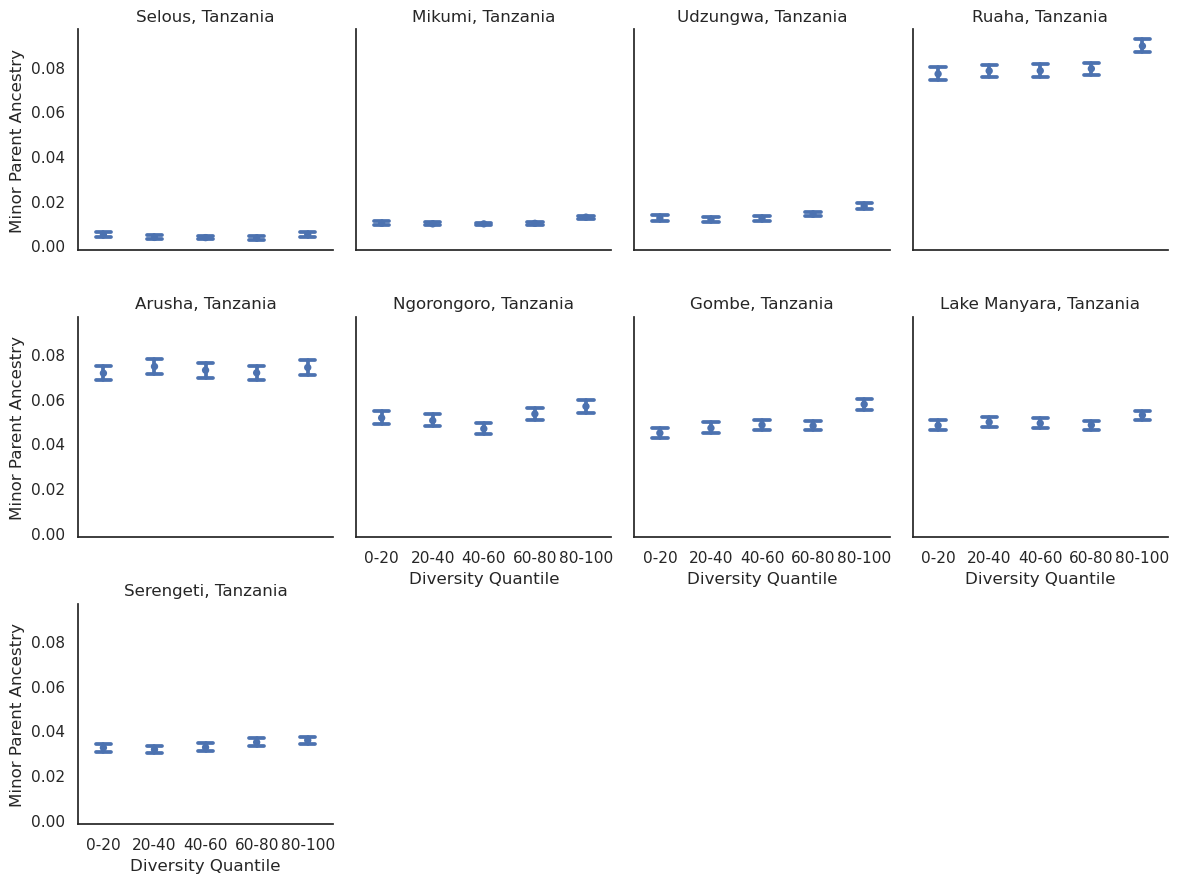

In [51]:
filter_qcut["Diversity Quantile"] = pd.qcut(filter_qcut.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
g = sns.FacetGrid(filter_qcut.loc[filter_qcut.Origin.isin(result_order_no_gog)], col="Origin",
                  col_wrap = 4, col_order=result_order_no_gog)
g.map_dataframe(sns.pointplot, y="minor_parent_percentage", x="Diversity Quantile", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
#g.set(xlim=(0, 0.25))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Diversity Quantile", ylabel="Minor Parent Ancestry")

In [52]:
o_l, low_l, high_l, effect_l, effect_hl_l = [], [], [], [], []
filter_qcut["Diversity Quantile"] = pd.qcut(filter_qcut.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
for o in result_order:
    s_df = filter_qcut.loc[filter_qcut.Origin == o]
    #print(o, s_df.groupby(["Diversity Quantile"])[["minor_parent_percentage"]].mean())
    low_mean = s_df.loc[s_df["Diversity Quantile"] == "0-20"][["minor_parent_percentage"]].mean()[0]*100
    high_mean = s_df.loc[s_df["Diversity Quantile"] == "80-100"][["minor_parent_percentage"]].mean()[0]*100
    o_l.append(o)
    low_l.append(low_mean)
    high_l.append(high_mean)
    effect_l.append(high_mean/low_mean-1)

/tmp/3137777/ipykernel_1554377/4242712310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut["Diversity Quantile"] = pd.qcut(filter_qcut.diversity, 5,


In [53]:
mean_quantile_df = pd.DataFrame({"Origin": o_l, "0-20 Minor Parent Percentage": low_l, 
                        "80-100 Minor Parent Percentage": high_l, "Relative Increase": effect_l})
mean_quantile_df["Absolute Increase"] = mean_quantile_df["80-100 Minor Parent Percentage"]-mean_quantile_df["0-20 Minor Parent Percentage"]
mean_quantile_df

Origin  0-20 Minor Parent Percentage  \
0         Selous, Tanzania                         0.474   
1         Mikumi, Tanzania                         0.988   
2       Udzungwa, Tanzania                          1.22   
3          Ruaha, Tanzania                          7.68   
4      Tarangire, Tanzania                          22.4   
5         Arusha, Tanzania                          7.13   
6     Ngorongoro, Tanzania                          5.14   
7          Gombe, Tanzania                          4.46   
8   Lake Manyara, Tanzania                          4.79   
9      Serengeti, Tanzania                          3.23   
10    Gog Woreda, Ethiopia                          7.05   

    80-100 Minor Parent Percentage  Relative Increase  Absolute Increase  
0                            0.489             0.0323             0.0153  
1                             1.26              0.279              0.276  
2                             1.76              0.443              0.541  
3                             8.92              0.162               1.25  
4                               21            -0.0609              -1.36  
5                             7.39              0.036              0.257  
6                             5.65                0.1              0.515  
7                             5.74              0.288               1.28  
8                             5.26             0.0966              0.463  
9                             3.56              0.103              0.333  
10                            12.6              0.783               5.52

In [54]:
o_l, low_l, high_l, effect_l, effect_hl_l = [], [], [], [], []
filter_qcut["Diversity Quantile"] = pd.qcut(filter_qcut.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
for o in result_order:
    s_df = filter_qcut.loc[filter_qcut.Origin == o]
    #print(o, s_df.groupby(["Diversity Quantile"])[["minor_parent_percentage"]].mean())
    low_mean = s_df.loc[s_df["Diversity Quantile"] == "0-20"][["minor_parent_percentage"]].mean()[0]*100
    high_mean = s_df.loc[s_df["Diversity Quantile"] == "80-100"][["minor_parent_percentage"]].mean()[0]*100
    o_l.append(o)
    low_l.append(low_mean)
    high_l.append(high_mean)
    effect_l.append(high_mean/low_mean-1)

/tmp/3137777/ipykernel_1554377/4242712310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut["Diversity Quantile"] = pd.qcut(filter_qcut.diversity, 5,


In [55]:
filter_qcut

chrom      start  diversity                                 Origin  \
2       chr1          0    0.00306                       Arusha, Tanzania   
5       chr1          0    0.00306  Gog Woreda, Gambella region, Ethiopia   
6       chr1          0    0.00306                   Gog Woreda, Ethiopia   
7       chr1          0    0.00306                        Gombe, Tanzania   
8       chr1          0    0.00306                  Issa Valley, Tanzania   
...      ...        ...        ...                                    ...   
524551  chr9  125600000     0.0023                        Ruaha, Tanzania   
524552  chr9  125600000     0.0023                       Selous, Tanzania   
524553  chr9  125600000     0.0023                    Serengeti, Tanzania   
524554  chr9  125600000     0.0023                    Tarangire, Tanzania   
524555  chr9  125600000     0.0023                     Udzungwa, Tanzania   

            end_x  north_sum       Species  callable_frac      end_y  \
2          100000   9.98e+04        anubis          0.795     100000   
5          100000   9.98e+04        anubis          0.795     100000   
6          100000   9.86e+04           NaN          0.795     100000   
7          100000   9.98e+04        anubis          0.795     100000   
8          100000   9.98e+04  cynocephalus          0.795     100000   
...           ...        ...           ...            ...        ...   
524551  125700000   2.19e+04  cynocephalus          0.869  125700000   
524552  125700000          0  cynocephalus          0.869  125700000   
524553  125700000      1e+05        anubis          0.869  125700000   
524554  125700000   6.61e+04        anubis          0.869  125700000   
524555  125700000          0  cynocephalus          0.869  125700000   

               cM  ...                                              genes  \
2               0  ...  ['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...   
5               0  ...  ['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...   
6               0  ...  ['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...   
7               0  ...  ['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...   
8               0  ...  ['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...   
...           ...  ...                                                ...   
524551        115  ...                                 ['SYCE1', 'SYCE1']   
524552        115  ...                                 ['SYCE1', 'SYCE1']   
524553        115  ...                                 ['SYCE1', 'SYCE1']   
524554        115  ...                                 ['SYCE1', 'SYCE1']   
524555        115  ...                                 ['SYCE1', 'SYCE1']   

        genic North Percentage     logdiv  logrecomb  norm_diversity  \
2        True            0.998      -2.51      -5.44            1.69   
5        True            0.998      -2.51      -5.44            1.69   
6        True            0.986      -2.51      -5.44            1.69   
7        True            0.998      -2.51      -5.44            1.69   
8        True            0.998      -2.51      -5.44            1.69   
...       ...              ...        ...        ...             ...   
524551   True            0.219      -2.64      -5.58           0.709   
524552   True                0      -2.64      -5.58           0.709   
524553   True                1      -2.64      -5.58           0.709   
524554   True            0.661      -2.64      -5.58           0.709   
524555   True                0      -2.64      -5.58           0.709   

        norm_recomb  minor_parent_percentage  local_minor_ancestry  \
2               2.9                   0.0016                0.0016   
5               2.9                   0.0016                0.0016   
6               2.9                    0.986                0.0143   
7               2.9                   0.0016                0.0016   
8               2.9                    0.998                0.0016   
...    

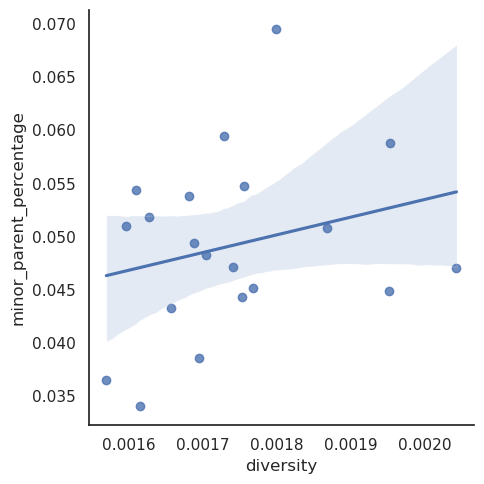

In [56]:
sns.lmplot(filter_qcut.loc[filter_qcut.Origin == "Gombe, Tanzania"].groupby(["chrom"])[["diversity", "minor_parent_percentage"]].mean(),
               x="diversity", y="minor_parent_percentage")

In [57]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_callable.loc[filter_callable.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity", data=o_div).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24618
Model:                                 GLM   Df Residuals:                    24616
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                       0.0011502
Method:                               IRLS   Log-Likelihood:                 48374.
Date:                     Fri, 22 Aug 2025   Deviance:                       28.314
Time:                             09:27:59   Pearson chi2:                     28.3
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0004793
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

Gombe, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25660
Model:                                 GLM   Df Residuals:                    25658
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                       0.0068427
Method:                               IRLS   Log-Likelihood:                 27543.
Date:                     Fri, 22 Aug 2025   Deviance:                       175.57
Time:                             09:27:59   Pearson chi2:                     176.
No. Iterations:                          3   Pseudo R-squ. (CS):           0.008043
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [58]:
filter_callable.Origin.unique()

array(['Arusha, Tanzania', 'Gog Woreda, Gambella region, Ethiopia',
       'Gog Woreda, Ethiopia', 'Gombe, Tanzania', 'Issa Valley, Tanzania',
       'Katavi, Tanzania', 'Lake Manyara, Tanzania', 'Mahale, Tanzania',
       'Mikumi, Tanzania', 'Ngorongoro, Tanzania', 'Ruaha, Tanzania',
       'Selous, Tanzania', 'Serengeti, Tanzania', 'Tarangire, Tanzania',
       'Udzungwa, Tanzania'], dtype=object)

In [59]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_diversity_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania    0.00209       1.13           0.000581   
1         Mikumi, Tanzania    0.00599       2.54            1.5e-35   
2       Udzungwa, Tanzania    0.00782       3.27           1.67e-25   
3          Ruaha, Tanzania     0.0681       7.08                  0   
4      Tarangire, Tanzania      0.218       -4.1                  0   
5         Arusha, Tanzania     0.0657       4.31          1.22e-211   
6     Ngorongoro, Tanzania     0.0408       6.34          2.03e-125   
7          Gombe, Tanzania     0.0298       11.3           1.89e-94   
8   Lake Manyara, Tanzania     0.0409       4.99          9.55e-199   
9      Serengeti, Tanzania     0.0225       6.41           1.32e-93   
10    Gog Woreda, Ethiopia     0.0322       31.9           4.38e-35   

    Slope P-value  Intercept stderr  Slope stderr  
0        0.000591          0.000607         0.329  
1        1.67e-22          0.000481          0.26  
2        7.92e-16           0.00075         0.406  
3        4.01e-14           0.00173         0.936  
4          0.0132           0.00305          1.65  
5        0.000169           0.00212          1.15  
6        8.39e-12           0.00171         0.928  
7        5.58e-47           0.00145         0.784  
8        1.28e-11           0.00136         0.737  
9        4.55e-27            0.0011         0.595  
10      9.06e-114            0.0026          1.41

In [60]:
filter_callable["diversity"].quantile([0.05, 0.95])

0.05     0.000819
0.95       0.0028
Name: diversity, dtype: float64

In [61]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_callable.loc[(filter_callable.Origin == o) #& (filter_callable.diversity <= 0.0028)
                               #& (filter_callable.diversity >= 0.000819)
                               ]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity",
                          data=o_div, var_weights=np.asarray(o_div["diversity"])
                         ).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24618
Model:                                 GLM   Df Residuals:                    24616
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      2.0616e-06
Method:                               IRLS   Log-Likelihood:                 47060.
Date:                     Fri, 22 Aug 2025   Deviance:                     0.050747
Time:                             09:27:59   Pearson chi2:                   0.0507
No. Iterations:                          3   Pseudo R-squ. (CS):           0.006860
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

Gog Woreda, Ethiopia                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25651
Model:                                 GLM   Df Residuals:                    25649
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      4.1528e-05
Method:                               IRLS   Log-Likelihood:                 10513.
Date:                     Fri, 22 Aug 2025   Deviance:                       1.0652
Time:                             09:28:00   Pearson chi2:                     1.07
No. Iterations:                          3   Pseudo R-squ. (CS):            0.02389
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [62]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_diversity_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania   -0.00242       3.41           1.66e-05   
1         Mikumi, Tanzania    0.00207       4.52           3.64e-06   
2       Udzungwa, Tanzania    0.00756        3.4           9.73e-28   
3          Ruaha, Tanzania     0.0656       8.39                  0   
4      Tarangire, Tanzania      0.207       1.53                  0   
5         Arusha, Tanzania     0.0527       10.9          1.64e-162   
6     Ngorongoro, Tanzania     0.0341       9.74          4.29e-103   
7          Gombe, Tanzania     0.0187       16.9           4.93e-42   
8   Lake Manyara, Tanzania     0.0342       8.38          2.41e-162   
9      Serengeti, Tanzania     0.0115         12           1.07e-27   
10    Gog Woreda, Ethiopia     0.0385       28.7           2.54e-54   

    Slope P-value  Intercept stderr  Slope stderr  
0        9.74e-39          0.000563         0.262  
1       9.61e-105          0.000448         0.208  
2        5.25e-26          0.000693         0.323  
3        1.89e-29            0.0016         0.744  
4           0.238           0.00279           1.3  
5        3.12e-33           0.00194         0.904  
6        5.99e-40           0.00158         0.736  
7       6.67e-153           0.00138         0.642  
8        3.17e-46           0.00126         0.587  
9       1.17e-130           0.00106         0.492  
10      6.25e-137           0.00248          1.15

In [63]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut.loc[filter_qcut.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24375
Model:                                 GLM   Df Residuals:                    24373
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.9508e-06
Method:                               IRLS   Log-Likelihood:                 47272.
Date:                     Fri, 22 Aug 2025   Deviance:                     0.047548
Time:                             09:28:00   Pearson chi2:                   0.0475
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0001723
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

Lake Manyara, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25406
Model:                                 GLM   Df Residuals:                    25404
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.0435e-05
Method:                               IRLS   Log-Likelihood:                 27961.
Date:                     Fri, 22 Aug 2025   Deviance:                      0.26510
Time:                             09:28:00   Pearson chi2:                    0.265
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001425
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

In [64]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_diversity_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania    0.00263      0.729           0.000225   
1         Mikumi, Tanzania    0.00646       2.19           6.05e-34   
2       Udzungwa, Tanzania    0.00692       3.79           5.47e-15   
3          Ruaha, Tanzania     0.0641       9.25          2.24e-212   
4      Tarangire, Tanzania      0.211     -0.784                  0   
5         Arusha, Tanzania     0.0686       2.34          1.54e-166   
6     Ngorongoro, Tanzania     0.0385       7.33            1.9e-80   
7          Gombe, Tanzania     0.0306       10.4           7.72e-71   
8   Lake Manyara, Tanzania     0.0408       4.84          4.67e-141   
9      Serengeti, Tanzania     0.0255        4.4           2.97e-86   
10    Gog Woreda, Ethiopia     0.0197       38.8           5.74e-10   

    Slope P-value  Intercept stderr  Slope stderr  
0          0.0404          0.000714         0.356  
1        1.21e-16          0.000532         0.265  
2        9.51e-18          0.000886         0.441  
3        1.91e-19           0.00206          1.03  
4           0.663           0.00361           1.8  
5          0.0591           0.00249          1.24  
6        4.03e-13           0.00203          1.01  
7        4.35e-34           0.00172         0.858  
8        1.76e-09           0.00161         0.804  
9        9.41e-12            0.0013         0.646  
10      1.58e-132           0.00318          1.58

In [65]:
groups = filter_qcut.groupby("chrom")
aut_mean, chrom_mean = groups["diversity"].transform("mean"), filter_qcut["diversity"].mean()
filter_qcut["aut_norm_div"] = filter_qcut.diversity*chrom_mean/aut_mean

/tmp/3137777/ipykernel_1554377/3362829037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut["aut_norm_div"] = filter_qcut.diversity*chrom_mean/aut_mean


In [66]:
for o in ["Katavi, Tanzania", "Mahale, Tanzania"]:
    o_div = filter_callable.loc[(filter_callable.Origin == o) #& (filter_callable.diversity <= 0.0028)
                               #& (filter_callable.diversity >= 0.000819)
                               ]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity",
                          data=o_div, var_weights=np.asarray(o_div["diversity"])
                         ).fit()
    print(o, glm_results.summary())

Katavi, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25660
Model:                                 GLM   Df Residuals:                    25658
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      3.1221e-05
Method:                               IRLS   Log-Likelihood:                 14177.
Date:                     Fri, 22 Aug 2025   Deviance:                      0.80107
Time:                             09:28:01   Pearson chi2:                    0.801
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0003544
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [67]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut.loc[filter_qcut.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ aut_norm_div", data=o_div,
                         var_weights=np.asarray(o_div["aut_norm_div"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24375
Model:                                 GLM   Df Residuals:                    24373
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.8691e-06
Method:                               IRLS   Log-Likelihood:                 47816.
Date:                     Fri, 22 Aug 2025   Deviance:                     0.045556
Time:                             09:28:01   Pearson chi2:                   0.0456
No. Iterations:                          3   Pseudo R-squ. (CS):          1.655e-06
Covariance Type:                 nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

Gombe, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25406
Model:                                 GLM   Df Residuals:                    25404
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.1870e-05
Method:                               IRLS   Log-Likelihood:                 26350.
Date:                     Fri, 22 Aug 2025   Deviance:                      0.30153
Time:                             09:28:01   Pearson chi2:                    0.302
No. Iterations:                          3   Pseudo R-squ. (CS):           0.005235
Covariance Type:                 nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

In [68]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_diversity_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania     0.0038     0.0705           6.39e-08   
1         Mikumi, Tanzania    0.00711       1.82           5.19e-41   
2       Udzungwa, Tanzania    0.00734       3.55            1.3e-16   
3          Ruaha, Tanzania     0.0649        8.8          4.24e-216   
4      Tarangire, Tanzania      0.213      -1.73                  0   
5         Arusha, Tanzania     0.0668       3.43          1.35e-156   
6     Ngorongoro, Tanzania     0.0401       6.47           4.02e-86   
7          Gombe, Tanzania     0.0314       9.98           8.62e-74   
8   Lake Manyara, Tanzania     0.0407       4.89          3.16e-139   
9      Serengeti, Tanzania     0.0247       4.91           1.08e-79   
10    Gog Woreda, Ethiopia     0.0312       32.2           1.14e-22   

    Slope P-value  Intercept stderr  Slope stderr  
0           0.841          0.000702         0.351  
1        6.65e-12           0.00053         0.265  
2        1.18e-15          0.000887         0.443  
3        1.59e-17           0.00207          1.03  
4            0.34           0.00362          1.81  
5         0.00614           0.00251          1.25  
6        2.11e-10           0.00204          1.02  
7        7.58e-31           0.00173         0.864  
8        1.57e-09           0.00162          0.81  
9        5.38e-14           0.00131         0.652  
10       2.25e-91           0.00318          1.59

In [69]:
o_div = filter_qcut.loc[filter_qcut.Origin.isin(["Mikumi, Tanzania", "Ruaha, Tanzania"])]
glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity*Origin", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
print(glm_results.summary(), glm_results.pvalues)

                    Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                49087
Model:                                 GLM   Df Residuals:                    49083
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      9.3029e-06
Method:                               IRLS   Log-Likelihood:                 56852.
Date:                     Fri, 22 Aug 2025   Deviance:                      0.45661
Time:                             09:28:01   Pearson chi2:                    0.457
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2099
Covariance Type:                 nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

In [70]:
o_div = filter_qcut.loc[filter_qcut.Origin.isin(["Ngorongoro, Tanzania", "Tarangire, Tanzania"])]
glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity*Origin", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
print(glm_results.summary(), glm_results.pvalues)

                    Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                50812
Model:                                 GLM   Df Residuals:                    50808
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      3.4292e-05
Method:                               IRLS   Log-Likelihood:                 25697.
Date:                     Fri, 22 Aug 2025   Deviance:                       1.7423
Time:                             09:28:02   Pearson chi2:                     1.74
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2661
Covariance Type:                 nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [71]:
from scipy.stats import norm

predictions = glm_results.get_prediction()
df_predictions = predictions.summary_frame()
df_predictions["diversity"] = o_div["diversity"]

[[<matplotlib.axis.XTick at 0x149ea19446d0>,

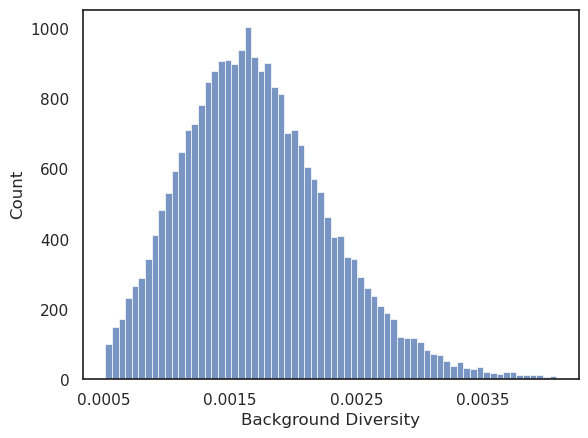

In [72]:
g = sns.histplot(filter_qcut.loc[filter_qcut.Origin.isin(gog)], x="diversity")
g.set(xlabel = "Background Diversity")
g.set(xticks=np.arange(0.0005, 0.004, 0.001))

[Text(0.5, 0, 'Background Diversity')]

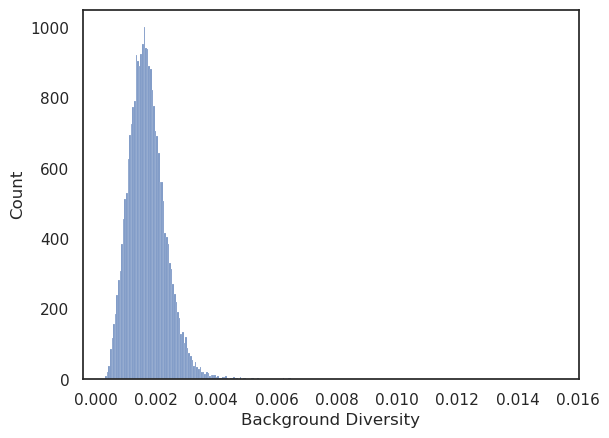

In [73]:
g = sns.histplot(filter_callable.loc[filter_callable.Origin.isin(gog)], x="diversity")
g.set(xlabel = "Background Diversity")
#g.set(xticks=np.arange(0.0005, 0.014, 0.001))

In [74]:
filter_qcut.loc[filter_qcut.Origin.isin(gog)]["diversity"].mean(), filter_qcut.loc[filter_qcut.Origin.isin(gog)]["diversity"].median()

(0.0017118524695634901, 0.0016583672626279916)

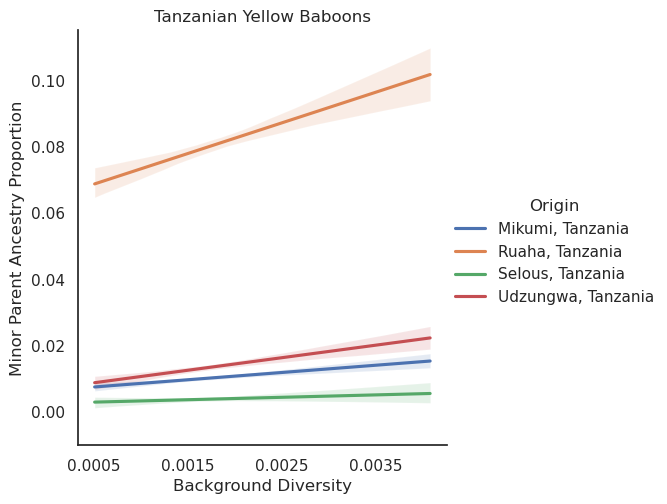

In [89]:
g = lmplot(filter_qcut.loc[filter_qcut.Origin.isin(yellows)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Yellow Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=np.arange(0.0005, 0.004, 0.001))

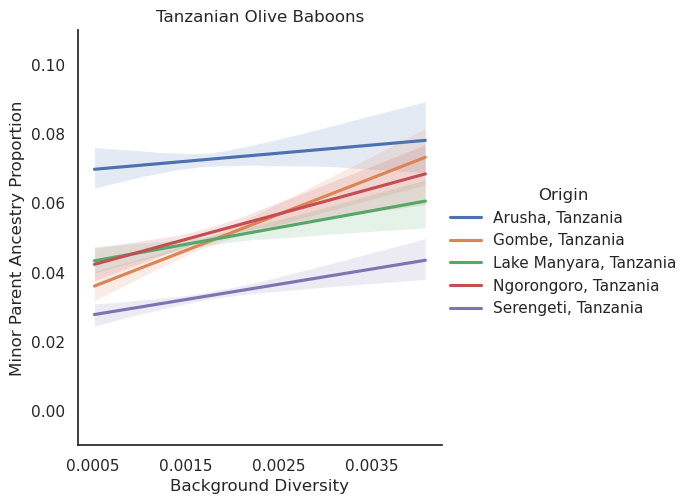

In [90]:
g = lmplot(filter_qcut.loc[filter_qcut.Origin.isin(olives)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Olive Baboons")
g.set(ylim=(-0.01, 0.11))
g.set(xticks=np.arange(0.0005, 0.004, 0.001))

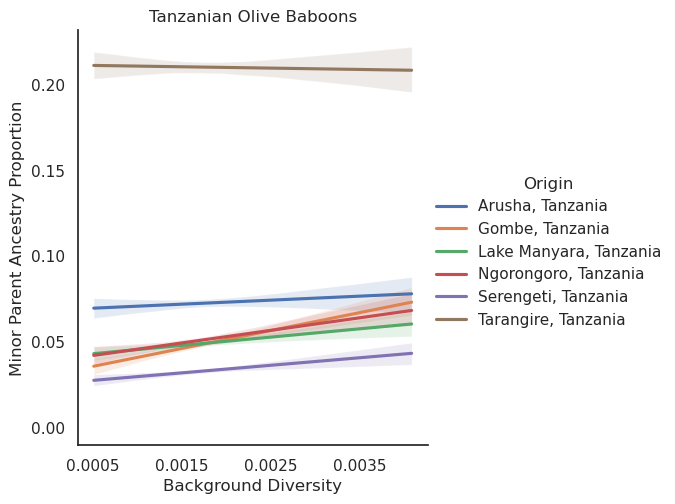

In [76]:
g = lmplot(filter_qcut.loc[filter_qcut.Origin.isin(olives_with_tarangire)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Olive Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=np.arange(0.0005, 0.004, 0.001))

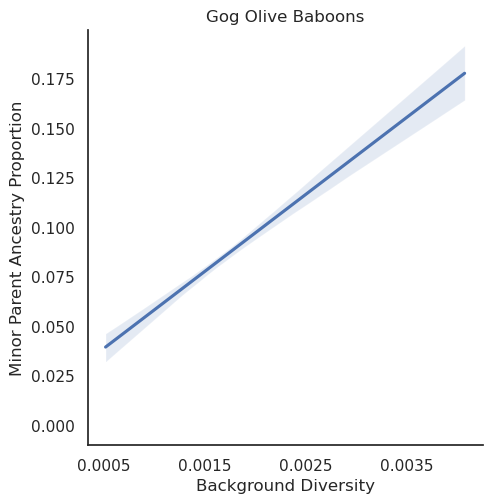

In [91]:
g = lmplot(filter_qcut.loc[filter_qcut.Origin.isin(gog)], x="diversity", y="minor_parent_percentage",
                            scatter=False, weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Gog Olive Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=np.arange(0.0005, 0.004, 0.001))

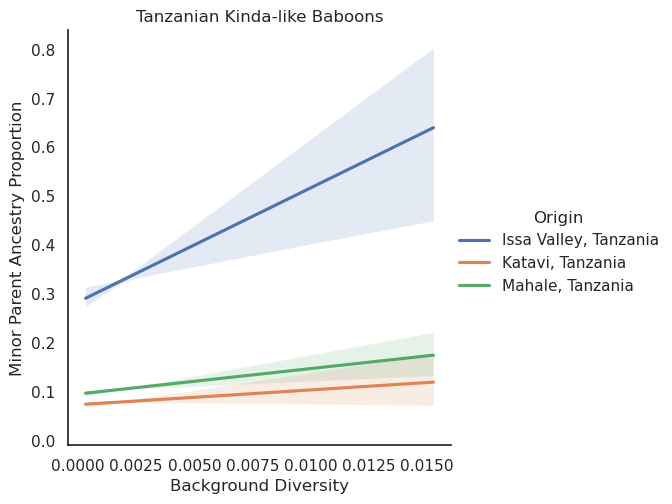

In [92]:
g = lmplot(filter_callable.loc[filter_callable.Origin.isin(["Mahale, Tanzania",
                                                           "Katavi, Tanzania",
                                                           "Issa Valley, Tanzania"])], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Kinda-like Baboons")
g.set(ylim=(-0.01, None))

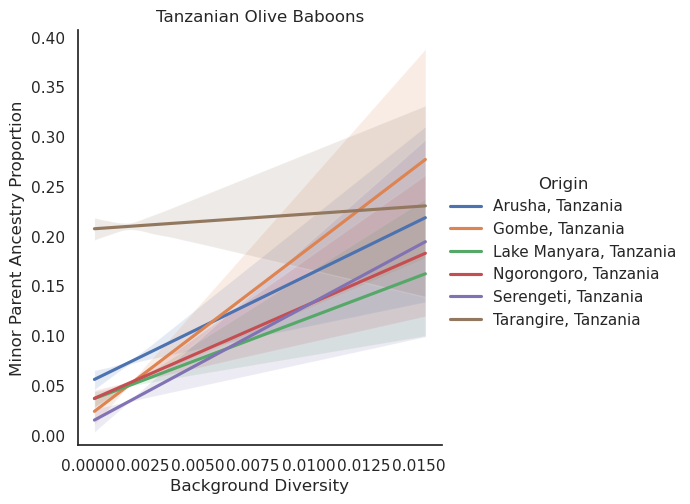

In [93]:
g = lmplot(filter_callable.loc[filter_callable.Origin.isin(olives_with_tarangire)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Olive Baboons")
g.set(ylim=(-0.01, None))

In [94]:
o_l, stat_l, pval_l = [], [], []
for o in result_order:
    o_div = filter_qcut.loc[filter_qcut.Origin == o]
    #o_div = o_div.loc[(o_div.minor_parent_percentage < 0.5)]
    st, pval = stats.pearsonr(o_div.diversity, o_div["minor_parent_percentage"])
    print(o, stats.pearsonr(o_div.diversity, o_div["minor_parent_percentage"]))
    o_l.append(o), stat_l.append(st), pval_l.append(pval)
pd.DataFrame({"Origin": o_l, "Statistic": stat_l, "P-Value": pval_l})

Selous, Tanzania PearsonRResult(statistic=0.002966084552418164, pvalue=0.6433234587598462)
Mikumi, Tanzania PearsonRResult(statistic=0.0363547545277126, pvalue=2.192855670021528e-08)
Udzungwa, Tanzania PearsonRResult(statistic=0.045679856978153174, pvalue=3.229249678206659e-13)
Ruaha, Tanzania PearsonRResult(statistic=0.044168371798420314, pvalue=1.8787139594992885e-12)
Tarangire, Tanzania PearsonRResult(statistic=-0.020032010676045243, pvalue=0.0014074567352394248)
Arusha, Tanzania PearsonRResult(statistic=0.006436875935346947, pvalue=0.3049149082148988)
Ngorongoro, Tanzania PearsonRResult(statistic=0.030391586392365215, pvalue=1.2656409455363885e-06)
Gombe, Tanzania PearsonRResult(statistic=0.05910353576665632, pvalue=4.16213724332686e-21)
Lake Manyara, Tanzania PearsonRResult(statistic=0.025270437321606554, pvalue=5.6165930958867885e-05)
Serengeti, Tanzania PearsonRResult(statistic=0.030343990574748136, pvalue=1.3149340752984797e-06)
Gog Woreda, Ethiopia PearsonRResult(statistic=0.1

Origin  Statistic    P-Value
0         Selous, Tanzania    0.00297      0.643
1         Mikumi, Tanzania     0.0364   2.19e-08
2       Udzungwa, Tanzania     0.0457   3.23e-13
3          Ruaha, Tanzania     0.0442   1.88e-12
4      Tarangire, Tanzania      -0.02    0.00141
5         Arusha, Tanzania    0.00644      0.305
6     Ngorongoro, Tanzania     0.0304   1.27e-06
7          Gombe, Tanzania     0.0591   4.16e-21
8   Lake Manyara, Tanzania     0.0253   5.62e-05
9      Serengeti, Tanzania     0.0303   1.31e-06
10    Gog Woreda, Ethiopia      0.135  3.69e-103

Recomb investigation for autosomes

In [86]:
filter_callable = admix_div_mean.loc[admix_div_mean.callable_frac > 0.75]
filter_callable.loc[filter_callable['Origin'] == 'Gog Woreda, Gambella region, Ethiopia_eth_case', ['Origin']] = 'Gog Woreda, Ethiopia'
filter_callable["average_cM_window"].quantile([0.005, 0.995])

0.005     1.13e-07
0.995     4.08e-06
Name: average_cM_window, dtype: float64

In [87]:
len(filter_callable)

378641

In [88]:
len(filter_callable)/len(admix_div_mean)

0.9890009716548431

In [89]:
filter_qcut_recomb = filter_callable.loc[(filter_callable.average_cM_window >= 1.13e-07) &
                                 (filter_callable.average_cM_window <=  4.08e-06)]
filter_callable["window_cM"] = filter_callable["average_cM_window"]*100000
filter_qcut_recomb["window_cM"] = filter_qcut_recomb["average_cM_window"]*100000

/tmp/3137777/ipykernel_1554377/436718125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_callable["window_cM"] = filter_callable["average_cM_window"]*100000
/tmp/3137777/ipykernel_1554377/436718125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_recomb["window_cM"] = filter_qcut_recomb["average_cM_window"]*100000


In [90]:
import statsmodels.api as sm
import numpy as np

df_l = []
for o in result_order:
    o_div = filter_qcut_recomb.loc[filter_qcut_recomb.Origin == o]
    Y = o_div["minor_parent_percentage"]
    X = o_div.window_cM
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print(o)
    #print(results.t_test([1, 0]))
    het_test = sm.stats.het_breuschpagan(resid=results.resid, exog_het=X)
    print(het_test)
    #print(sm.stats.diagnostic.linear_harvey_collier(results))
    df_l.append(list(het_test))
bp_df = pd.DataFrame(df_l, columns=["Lagrange Multiplier", "Lagrange Multiplier P-value", "F-statistic", "F-statistic P-value"])
bp_df["Origin"] = result_order
bp_df

Selous, Tanzania
(12.381735783908054, 0.0004335539149232067, 12.387013793525393, 0.0004331184807310295)
Mikumi, Tanzania
(6.562486413748457, 0.01041507417386672, 6.56375122879245, 0.010413806615145378)
Udzungwa, Tanzania
(0.4369492651379413, 0.508598602429722, 0.4369223769985095, 0.5086176410033991)
Ruaha, Tanzania
(0.047026904622970656, 0.8283198858899072, 0.04702328892139506, 0.8283281247539878)
Tarangire, Tanzania
(2.3045357256969146, 0.12899681937606777, 2.3045633575676217, 0.12900697160176883)
Arusha, Tanzania
(5.599264064498459, 0.017968023676056325, 5.600057642445025, 0.01796734594522226)
Ngorongoro, Tanzania
(0.22330274575776587, 0.6365348330608686, 0.22328712649723295, 0.6365506866615125)
Gombe, Tanzania
(1.7276041884799942, 0.18871715422099172, 1.7275856607001943, 0.18873139395493088)
Lake Manyara, Tanzania
(1.5950036497577411, 0.20661270604764423, 1.5949782172463762, 0.20662791868534194)
Serengeti, Tanzania
(14.456716005401539, 0.00014341754966819574, 14.463809653544178, 0.0

Lagrange Multiplier  Lagrange Multiplier P-value  F-statistic  \
0                  12.4                     0.000434         12.4   
1                  6.56                       0.0104         6.56   
2                 0.437                        0.509        0.437   
3                 0.047                        0.828        0.047   
4                   2.3                        0.129          2.3   
5                   5.6                        0.018          5.6   
6                 0.223                        0.637        0.223   
7                  1.73                        0.189         1.73   
8                   1.6                        0.207         1.59   
9                  14.5                     0.000143         14.5   
10                  120                     7.32e-28          120   

    F-statistic P-value                  Origin  
0              0.000433        Selous, Tanzania  
1                0.0104        Mikumi, Tanzania  
2                 0.509      Udzungwa, Tanzania  
3                 0.828         Ruaha, Tanzania  
4                 0.129     Tarangire, Tanzania  
5                 0.018        Arusha, Tanzania  
6                 0.637    Ngorongoro, Tanzania  
7                 0.189         Gombe, Tanzania  
8                 0.207  Lake Manyara, Tanzania  
9              0.000143     Serengeti, Tanzania  
10             6.38e-28    Gog Woreda, Ethiopia

/tmp/3137777/ipykernel_1554377/3329632309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_recomb["Recombination Quantile"] = pd.qcut(filter_qcut_recomb.window_cM, 5,


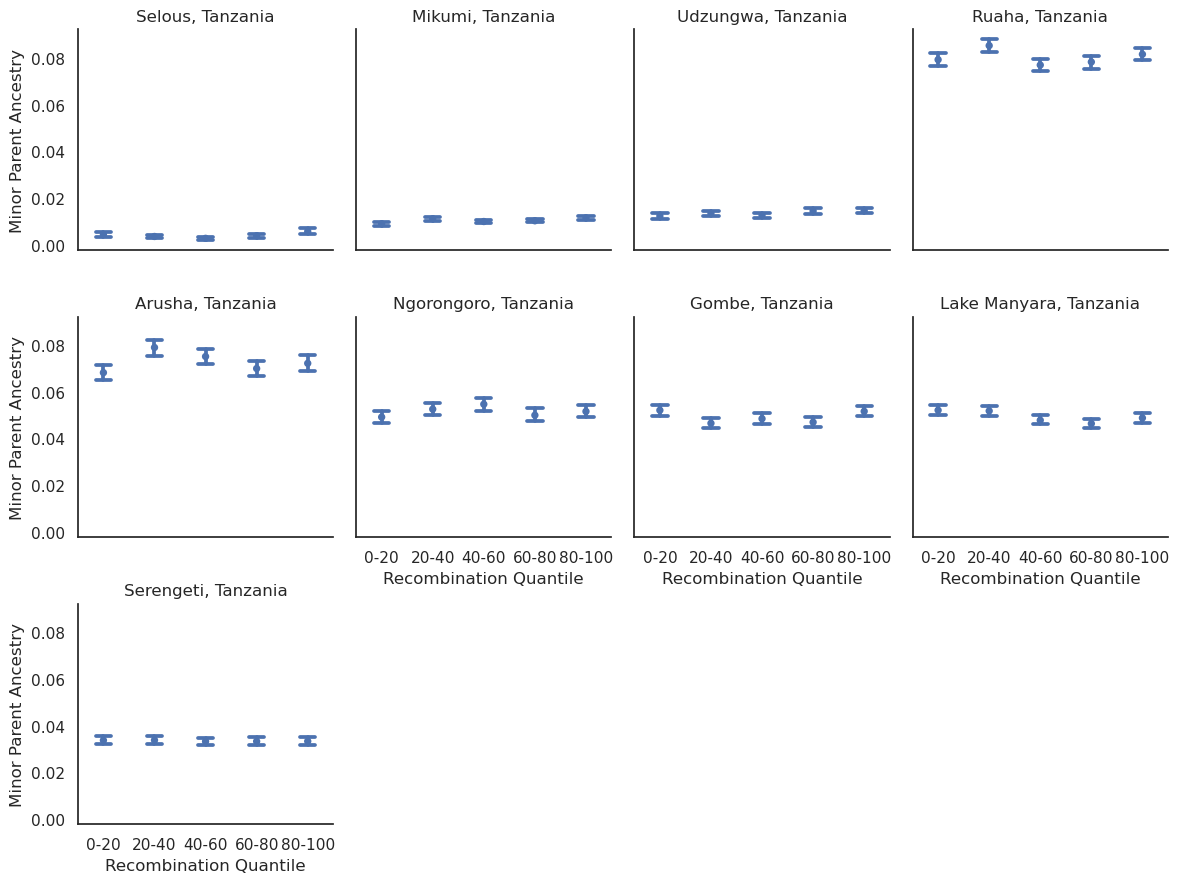

In [91]:
filter_qcut_recomb["Recombination Quantile"] = pd.qcut(filter_qcut_recomb.window_cM, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
g = sns.FacetGrid(filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(result_order_no_gog)], col="Origin",
                  col_wrap = 4, col_order=result_order_no_gog)
g.map_dataframe(sns.pointplot, y="minor_parent_percentage", x="Recombination Quantile", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
#g.set(xlim=(0, 0.25))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Recombination Quantile", ylabel="Minor Parent Ancestry")

In [92]:
o_l, low_l, high_l, effect_l, effect_hl_l = [], [], [], [], []
filter_qcut_recomb["Recombination Quantile"] = pd.qcut(filter_qcut_recomb.window_cM, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
for o in result_order:
    s_df = filter_qcut_recomb.loc[filter_qcut_recomb.Origin == o]
    #print(o, s_df.groupby(["Recombination Quantile"])[["minor_parent_percentage"]].mean())
    low_mean = s_df.loc[s_df["Recombination Quantile"] == "0-20"][["minor_parent_percentage"]].mean()[0]*100
    high_mean = s_df.loc[s_df["Recombination Quantile"] == "80-100"][["minor_parent_percentage"]].mean()[0]*100
    o_l.append(o)
    low_l.append(low_mean)
    high_l.append(high_mean)
    effect_l.append(high_mean/low_mean-1)

/tmp/3137777/ipykernel_1554377/3586050451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_recomb["Recombination Quantile"] = pd.qcut(filter_qcut_recomb.window_cM, 5,


In [93]:
mean_quantile_df = pd.DataFrame({"Origin": o_l, "0-20 Minor Parent Percentage": low_l, 
                        "80-100 Minor Parent Percentage": high_l, "Relative Increase": effect_l})
mean_quantile_df["Absolute Increase"] = mean_quantile_df["80-100 Minor Parent Percentage"]-mean_quantile_df["0-20 Minor Parent Percentage"]
mean_quantile_df

Origin  0-20 Minor Parent Percentage  \
0         Selous, Tanzania                         0.442   
1         Mikumi, Tanzania                         0.896   
2       Udzungwa, Tanzania                          1.23   
3          Ruaha, Tanzania                          7.92   
4      Tarangire, Tanzania                          21.8   
5         Arusha, Tanzania                          6.82   
6     Ngorongoro, Tanzania                          4.92   
7          Gombe, Tanzania                          5.21   
8   Lake Manyara, Tanzania                          5.21   
9      Serengeti, Tanzania                          3.38   
10    Gog Woreda, Ethiopia                           7.5   

    80-100 Minor Parent Percentage  Relative Increase  Absolute Increase  
0                            0.569              0.288              0.127  
1                             1.15              0.283              0.254  
2                             1.46              0.189              0.232  
3                             8.15             0.0292              0.231  
4                             20.2            -0.0725              -1.58  
5                             7.22             0.0585              0.399  
6                             5.16             0.0491              0.242  
7                             5.16           -0.00878            -0.0457  
8                             4.88            -0.0633              -0.33  
9                             3.34            -0.0117            -0.0395  
10                            10.6               0.41               3.07

In [94]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_callable.loc[filter_callable.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ window_cM", data=o_div,
                         var_weights=np.asarray(o_div["window_cM"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24618
Model:                                 GLM   Df Residuals:                    24616
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      0.00011589
Method:                               IRLS   Log-Likelihood:                 43578.
Date:                     Fri, 22 Aug 2025   Deviance:                       2.8529
Time:                             10:31:00   Pearson chi2:                     2.85
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001286
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

Gog Woreda, Ethiopia                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25651
Model:                                 GLM   Df Residuals:                    25649
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                       0.0021873
Method:                               IRLS   Log-Likelihood:                 7754.0
Date:                     Fri, 22 Aug 2025   Deviance:                       56.102
Time:                             10:31:00   Pearson chi2:                     56.1
No. Iterations:                          3   Pseudo R-squ. (CS):            0.01622
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [95]:
glm_recomb_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_recomb_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania     0.0032     0.0112           2.39e-19   
1         Mikumi, Tanzania    0.00885     0.0185          1.19e-213   
2       Udzungwa, Tanzania     0.0132    0.00792          6.55e-231   
3          Ruaha, Tanzania     0.0736     0.0598                  0   
4      Tarangire, Tanzania      0.205      0.033                  0   
5         Arusha, Tanzania     0.0694     0.0323                  0   
6     Ngorongoro, Tanzania     0.0438     0.0733                  0   
7          Gombe, Tanzania     0.0423     0.0681                  0   
8   Lake Manyara, Tanzania     0.0452     0.0354                  0   
9      Serengeti, Tanzania     0.0315     0.0199                  0   
10    Gog Woreda, Ethiopia     0.0746      0.176                  0   

    Slope P-value  Intercept stderr  Slope stderr  
0        1.82e-08          0.000355       0.00199  
1        1.59e-31          0.000284       0.00159  
2        0.000554          0.000407       0.00229  
3        5.46e-30          0.000933       0.00526  
4        0.000329           0.00163        0.0092  
5        3.51e-07           0.00113       0.00634  
6        4.33e-44          0.000934       0.00527  
7        4.14e-51          0.000803       0.00453  
8         8.6e-18          0.000732       0.00412  
9        1.18e-08           0.00062       0.00349  
10       3.24e-93           0.00152       0.00857

In [96]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut_recomb.loc[filter_qcut_recomb.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ window_cM", data=o_div,
                         var_weights=np.asarray(o_div["window_cM"])
                         ).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24367
Model:                                 GLM   Df Residuals:                    24365
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      0.00011478
Method:                               IRLS   Log-Likelihood:                 43248.
Date:                     Fri, 22 Aug 2025   Deviance:                       2.7967
Time:                             10:31:00   Pearson chi2:                     2.80
No. Iterations:                          3   Pseudo R-squ. (CS):           0.003038
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

Lake Manyara, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25401
Model:                                 GLM   Df Residuals:                    25399
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      0.00048087
Method:                               IRLS   Log-Likelihood:                 26924.
Date:                     Fri, 22 Aug 2025   Deviance:                       12.214
Time:                             10:31:01   Pearson chi2:                     12.2
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0001841
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

In [97]:
glm_recomb_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_recomb_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania    0.00137     0.0281            0.00229   
1         Mikumi, Tanzania    0.00728     0.0325           1.27e-94   
2       Udzungwa, Tanzania     0.0107     0.0309           1.28e-97   
3          Ruaha, Tanzania     0.0759     0.0414                  0   
4      Tarangire, Tanzania      0.212    -0.0327                  0   
5         Arusha, Tanzania     0.0717    0.00994                  0   
6     Ngorongoro, Tanzania     0.0491     0.0261                  0   
7          Gombe, Tanzania     0.0428     0.0633                  0   
8   Lake Manyara, Tanzania     0.0474     0.0142                  0   
9      Serengeti, Tanzania     0.0306     0.0279                  0   
10    Gog Woreda, Ethiopia     0.0658      0.251          9.72e-272   

    Slope P-value  Intercept stderr  Slope stderr  
0         7.3e-18           0.00045       0.00327  
1        1.07e-37          0.000353       0.00253  
2        6.38e-17          0.000509       0.00369  
3        8.29e-07           0.00116       0.00841  
4           0.027           0.00204        0.0148  
5           0.327            0.0014        0.0102  
6         0.00177           0.00115       0.00836  
7         5.6e-19          0.000981       0.00711  
8          0.0306          0.000903       0.00655  
9        4.07e-07           0.00076       0.00551  
10       1.03e-76           0.00187        0.0136

In [98]:
filter_callable.loc[filter_callable['Origin'] == 'Gog Woreda, Gambella region, Ethiopia_eth_case', ['Origin']] = 'Gog Woreda, Ethiopia'
filter_callable["average_cM_window"].quantile([0.000, 0.99])

   0     7.12e-09
0.99     3.26e-06
Name: average_cM_window, dtype: float64

[Text(0.5, 0, 'Recombination across window (cM)')]

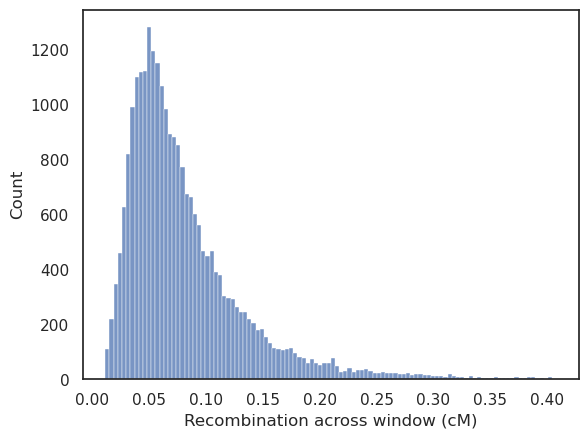

In [99]:
g = sns.histplot(filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(gog)], x="window_cM")
g.set(xlabel="Recombination across window (cM)")

In [100]:
filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(gog)]["window_cM"].mean(), filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(gog)]["window_cM"].median()

(0.08147665195026459, 0.06682527339771838)

[Text(0.5, 0, 'Recombination across window (cM)')]

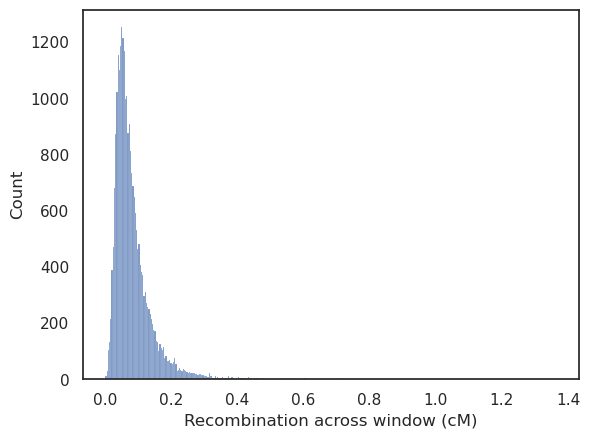

In [101]:
g = sns.histplot(filter_callable.loc[filter_callable.Origin.isin(gog)], x="window_cM")
g.set(xlabel="Recombination across window (cM)")

In [102]:
filter_callable.loc[filter_callable.Origin.isin(gog)]["window_cM"].mean(), filter_callable.loc[filter_callable.Origin.isin(gog)]["window_cM"].median()

(0.08348644026964483, 0.06682536781364945)

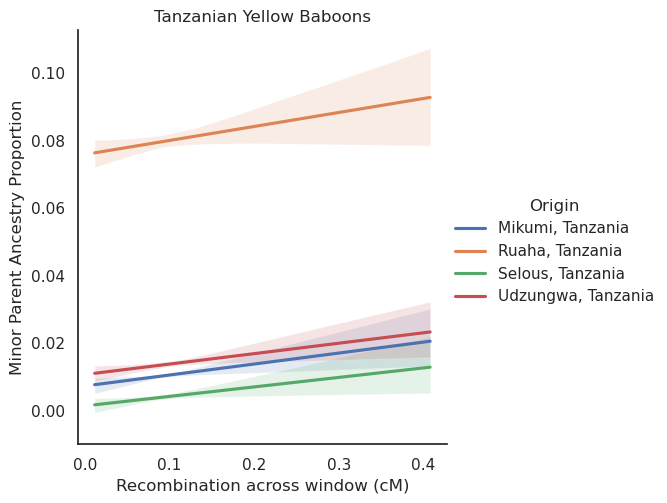

In [103]:
g = lmplot(filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(yellows)], x="window_cM", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5)
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Recombination across window (cM)", title="Tanzanian Yellow Baboons")
g.set(ylim=(-0.01, None))

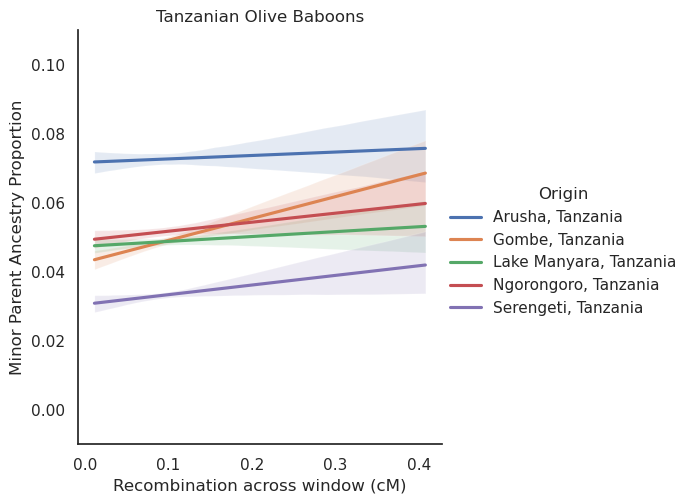

In [104]:
g = lmplot(filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(olives)], x="window_cM", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=95)
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Recombination across window (cM)", title="Tanzanian Olive Baboons")
g.set(ylim=(-0.01, 0.11))

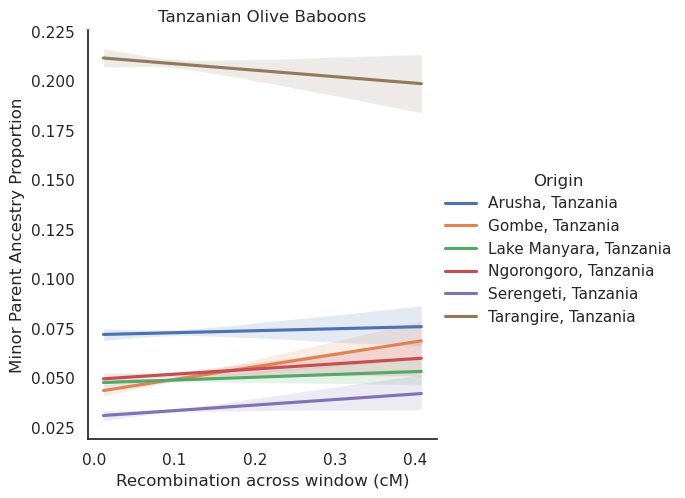

In [149]:
g = lmplot(filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(olives_with_tarangire)], x="window_cM", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=95)
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Recombination across window (cM)", title="Tanzanian Olive Baboons")
#g.set(ylim=(-0.01, 0.11))

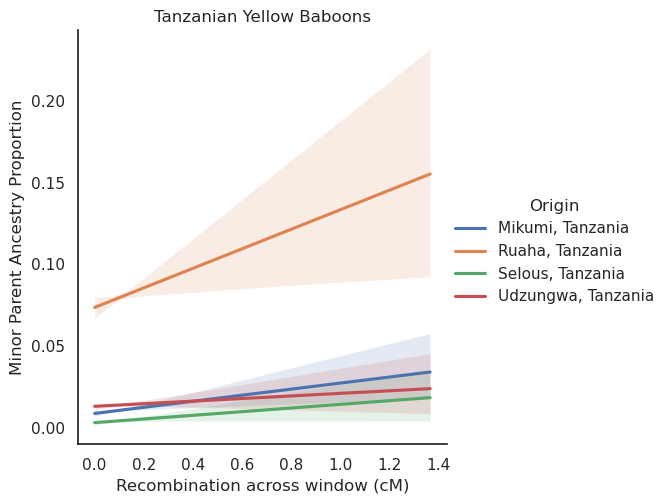

In [105]:
g = lmplot(filter_callable.loc[filter_callable.Origin.isin(yellows)], x="window_cM", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5)
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Recombination across window (cM)", title="Tanzanian Yellow Baboons")
g.set(ylim=(-0.01, None))

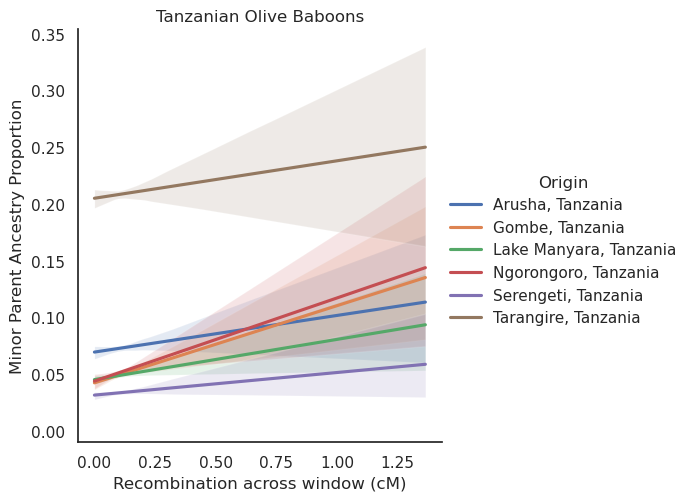

In [106]:
g = lmplot(filter_callable.loc[filter_callable.Origin.isin(olives_with_tarangire)], x="window_cM", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5)
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Recombination across window (cM)", title="Tanzanian Olive Baboons")
g.set(ylim=(-0.01, None))

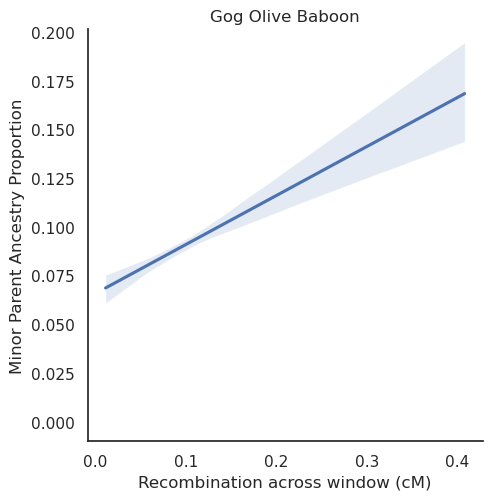

In [107]:
g = lmplot(filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(gog)], x="window_cM", y="minor_parent_percentage",
                            scatter=False, weighted=True, n_boot=1000, ci=99.5)
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Recombination across window (cM)", title="Gog Olive Baboon")
g.set(ylim=(-0.01, None))

[Text(0.5, 0, 'Recombination across window (cM)'),
 Text(0, 0.5, 'Background Diversity')]

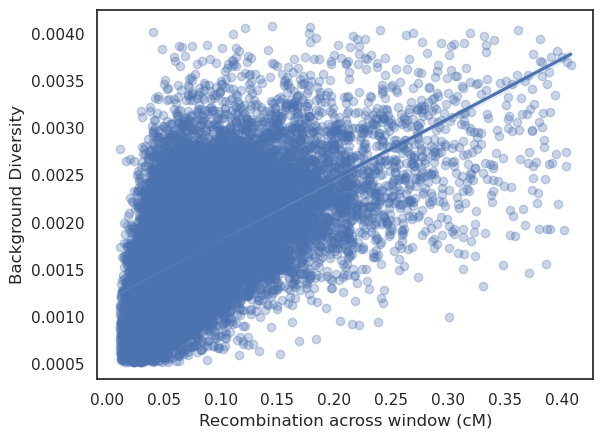

In [108]:
norm_filter = filter_qcut_recomb.loc[(filter_qcut_recomb.diversity >= 0.000513) &
                                 (filter_qcut_recomb.diversity <= 0.00408)]
g = sns.regplot(norm_filter.loc[(norm_filter.Origin == "Serengeti, Tanzania") &
                              #(admix_div_mean["minor_parent_percentage"] < 0.5) &
                              (norm_filter.callable_frac > 0.75)], x="window_cM", y="diversity",
                            ci=95, scatter_kws={'alpha':0.3})
g.set(xlabel="Recombination across window (cM)", ylabel = "Background Diversity")

In [109]:
stats.pearsonr(norm_filter.window_cM, norm_filter.diversity)

PearsonRResult(statistic=0.5740288198109088, pvalue=0.0)

In [110]:
norm_filter["norm_diversity"] = (norm_filter.diversity-norm_filter.diversity.mean())/(norm_filter.diversity.std())
norm_filter["norm_recomb"] = (norm_filter.window_cM-norm_filter.window_cM.mean())/(norm_filter.window_cM.std())

/tmp/3137777/ipykernel_1554377/1414838712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_filter["norm_diversity"] = (norm_filter.diversity-norm_filter.diversity.mean())/(norm_filter.diversity.std())
/tmp/3137777/ipykernel_1554377/1414838712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_filter["norm_recomb"] = (norm_filter.window_cM-norm_filter.window_cM.mean())/(norm_filter.window_cM.std())


In [111]:
o_l, cd_l, cr_l, nd_l, rd_l = [], [], [], [], []
for o in result_order:
    o_div = norm_filter.loc[norm_filter.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ norm_diversity", data=o_div
                         ).fit()
    print(o, glm_results.summary2(), glm_results.pvalues, glm_results.f_test(np.identity(len(glm_results.params))[1:,:]))
    #o_l.append(o), cd_l.append(glm_results.params[1]), cr_l.append(glm_results.params[2])
    #nd_l.append(glm_results.pvalues[1]), rd_l.append(glm_results.pvalues[2])

Selous, Tanzania                    Results: Generalized linear model
Model:              GLM                     AIC:            -95041.8962 
Link Function:      Identity                BIC:            -243985.3871
Dependent Variable: minor_parent_percentage Log-Likelihood: 47523.      
Date:               2025-08-22 10:34        LL-Null:        47523.      
No. Observations:   24178                   Deviance:       27.778      
Df Model:           1                       Pearson chi2:   27.8        
Df Residuals:       24176                   Scale:          0.0011490   
Method:             IRLS                                                
--------------------------------------------------------------------------
                   Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
--------------------------------------------------------------------------
Intercept          0.0040     0.0002   18.4336   0.0000    0.0036   0.0044
norm_diversity     0.0001     0.0002    0.3792

Lake Manyara, Tanzania                    Results: Generalized linear model
Model:              GLM                     AIC:            -57531.2475 
Link Function:      Identity                BIC:            -255276.7656
Dependent Variable: minor_parent_percentage Log-Likelihood: 28768.      
Date:               2025-08-22 10:34        LL-Null:        28760.      
No. Observations:   25205                   Deviance:       150.54      
Df Model:           1                       Pearson chi2:   151.        
Df Residuals:       25203                   Scale:          0.0059731   
Method:             IRLS                                                
--------------------------------------------------------------------------
                   Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------------
Intercept          0.0493     0.0005   101.2385   0.0000   0.0483   0.0502
norm_diversity     0.0019     0.0005    

In [112]:
o_l, cd_l, cr_l, nd_l, rd_l = [], [], [], [], []
for o in result_order:
    o_div = norm_filter.loc[norm_filter.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity + window_cM", data=o_div
                         ).fit()
    print(o, glm_results.summary2(), glm_results.pvalues, glm_results.f_test(np.identity(len(glm_results.params))[1:,:]))
    o_l.append(o), cd_l.append(glm_results.params[1]), cr_l.append(glm_results.params[2])
    nd_l.append(glm_results.pvalues[1]), rd_l.append(glm_results.pvalues[2])

Selous, Tanzania                    Results: Generalized linear model
Model:              GLM                     AIC:            -95052.7062 
Link Function:      Identity                BIC:            -243975.3086
Dependent Variable: minor_parent_percentage Log-Likelihood: 47529.      
Date:               2025-08-22 10:34        LL-Null:        47523.      
No. Observations:   24178                   Deviance:       27.763      
Df Model:           2                       Pearson chi2:   27.8        
Df Residuals:       24175                   Scale:          0.0011484   
Method:             IRLS                                                
---------------------------------------------------------------------------
               Coef.     Std.Err.       z       P>|z|      [0.025    0.975]
---------------------------------------------------------------------------
Intercept      0.0039      0.0007     5.7228    0.0000     0.0026    0.0052
diversity     -0.7945      0.4595    -1.72

Ngorongoro, Tanzania                    Results: Generalized linear model
Model:              GLM                     AIC:            -45763.9086 
Link Function:      Identity                BIC:            -255177.0806
Dependent Variable: minor_parent_percentage Log-Likelihood: 22885.      
Date:               2025-08-22 10:34        LL-Null:        22873.      
No. Observations:   25205                   Deviance:       240.09      
Df Model:           2                       Pearson chi2:   240.        
Df Residuals:       25202                   Scale:          0.0095266   
Method:             IRLS                                                
---------------------------------------------------------------------------
               Coef.     Std.Err.       z       P>|z|      [0.025    0.975]
---------------------------------------------------------------------------
Intercept      0.0433      0.0019    22.5399    0.0000     0.0395    0.0470
diversity      6.0985      1.2949     

In [113]:
pd.DataFrame({"Origin": o_l, "Recombination Slope": cr_l, "Diversity Slope": cd_l,
              "Recombination p-val": rd_l, "Diversity p-val": nd_l})

Origin  Recombination Slope  Diversity Slope  \
0         Selous, Tanzania               0.0182           -0.794   
1         Mikumi, Tanzania              0.00743             1.12   
2       Udzungwa, Tanzania             -0.00319             3.56   
3          Ruaha, Tanzania              -0.0559             10.5   
4      Tarangire, Tanzania              -0.0618            -3.15   
5         Arusha, Tanzania              -0.0215             2.56   
6     Ngorongoro, Tanzania              -0.0277              6.1   
7          Gombe, Tanzania              -0.0619             11.5   
8   Lake Manyara, Tanzania              -0.0582             6.27   
9      Serengeti, Tanzania              -0.0449             5.69   
10    Gog Woreda, Ethiopia               0.0186             33.6   

    Recombination p-val  Diversity p-val  
0              0.000344           0.0838  
1                0.0592          0.00181  
2                 0.612          3.4e-10  
3              0.000113          1.4e-15  
4                0.0157            0.173  
5                 0.223             0.11  
6                0.0528         2.48e-06  
7              2.43e-07         4.45e-26  
8              2.78e-07         9.22e-10  
9              6.86e-07         3.43e-12  
10                0.393         1.41e-65

In [114]:
o_l, cd_l, cr_l, nd_l, rd_l, i_l, id_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = norm_filter.loc[norm_filter.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ norm_diversity * norm_recomb", data=o_div
                         ).fit()
    print(o, glm_results.summary2(), glm_results.pvalues, glm_results.f_test(np.identity(len(glm_results.params))[1:,:]))
    o_l.append(o), cd_l.append(glm_results.params[1]), cr_l.append(glm_results.params[2])
    nd_l.append(glm_results.pvalues[1]), rd_l.append(glm_results.pvalues[2])
    i_l.append(glm_results.params[3]), id_l.append(glm_results.pvalues[3])

Selous, Tanzania                     Results: Generalized linear model
Model:               GLM                     AIC:            -95054.3431 
Link Function:       Identity                BIC:            -243965.2196
Dependent Variable:  minor_parent_percentage Log-Likelihood: 47531.      
Date:                2025-08-22 10:34        LL-Null:        47523.      
No. Observations:    24178                   Deviance:       27.759      
Df Model:            3                       Pearson chi2:   27.8        
Df Residuals:        24174                   Scale:          0.0011483   
Method:              IRLS                                                
-------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------
Intercept                   0.0038   0.0002 15.8642 0.0000  0.0034 0.0043
norm_diversity             -0.0004   0.00

Gombe, Tanzania                     Results: Generalized linear model
Model:                GLM                     AIC:            -54725.5805 
Link Function:        Identity                BIC:            -255238.7973
Dependent Variable:   minor_parent_percentage Log-Likelihood: 27367.      
Date:                 2025-08-22 10:34        LL-Null:        27302.      
No. Observations:     25205                   Deviance:       168.24      
Df Model:             3                       Pearson chi2:   168.        
Df Residuals:         25201                   Scale:          0.0066759   
Method:               IRLS                                                
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.0479   0.0006 84.0264 0.0000  0.0468  0.0490
norm_diversity              0.

In [115]:
pd.DataFrame({"Origin": o_l, "Recombination Slope": cr_l, "Diversity Slope": cd_l, "Interaction Slope": i_l,
              "Recombination p-val": rd_l, "Diversity p-val": nd_l, "Interaction p-val": id_l})

Origin  Recombination Slope  Diversity Slope  \
0         Selous, Tanzania             0.000657        -0.000425   
1         Mikumi, Tanzania             0.000156         0.000671   
2       Udzungwa, Tanzania            -0.000542          0.00211   
3          Ruaha, Tanzania             -0.00467          0.00625   
4      Tarangire, Tanzania             -0.00676         -0.00143   
5         Arusha, Tanzania             -0.00152          0.00153   
6     Ngorongoro, Tanzania             -0.00233          0.00363   
7          Gombe, Tanzania             -0.00478          0.00681   
8   Lake Manyara, Tanzania             -0.00435          0.00378   
9      Serengeti, Tanzania             -0.00301          0.00337   
10    Gog Woreda, Ethiopia             -0.00097           0.0197   

    Interaction Slope  Recombination p-val  Diversity p-val  Interaction p-val  
0            0.000345                0.033            0.111             0.0565  
1            0.000268                0.513          0.00129             0.0529  
2            0.000437                0.154         1.62e-10             0.0497  
3             0.00203             1.03e-07         1.92e-16            7.9e-05  
4              0.0041             1.33e-05            0.286           6.38e-06  
5             0.00046                0.156              0.1              0.464  
6             0.00102               0.0073         1.36e-06             0.0447  
7             0.00179             4.84e-11         2.88e-27           2.66e-05  
8              0.0015              2.6e-10         2.11e-10           0.000186  
9            0.000759             4.23e-08         1.26e-12             0.0181  
10            0.00226                0.462         9.05e-67             0.0034

In [116]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = norm_filter.loc[norm_filter.Origin == o]
    glm_results = smf.ols(formula = "minor_parent_percentage ~ norm_diversity", data=o_div
                         ).fit()
    print(o, glm_results.summary2())

Selous, Tanzania                       Results: Ordinary least squares
Model:              OLS                     Adj. R-squared:     -0.000     
Dependent Variable: minor_parent_percentage AIC:                -95041.8962
Date:               2025-08-22 10:34        BIC:                -95025.7098
No. Observations:   24178                   Log-Likelihood:     47523.     
Df Model:           1                       F-statistic:        0.1438     
Df Residuals:       24176                   Prob (F-statistic): 0.705      
R-squared:          0.000                   Scale:              0.0011490  
------------------------------------------------------------------------------
                  Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
------------------------------------------------------------------------------
Intercept         0.0040      0.0002    18.4336    0.0000     0.0036    0.0044
norm_diversity    0.0001      0.0002     0.3792    0.7045    -0.0003    0.0005
--

Serengeti, Tanzania                       Results: Ordinary least squares
Model:              OLS                     Adj. R-squared:     0.001      
Dependent Variable: minor_parent_percentage AIC:                -68901.3182
Date:               2025-08-22 10:34        BIC:                -68885.0486
No. Observations:   25205                   Log-Likelihood:     34453.     
Df Model:           1                       F-statistic:        25.17      
Df Residuals:       25203                   Prob (F-statistic): 5.28e-07   
R-squared:          0.001                   Scale:              0.0038044  
------------------------------------------------------------------------------
                   Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
------------------------------------------------------------------------------
Intercept          0.0333      0.0004    85.5897    0.0000    0.0325    0.0340
norm_diversity     0.0019      0.0004     5.0170    0.0000    0.0012    0.0027

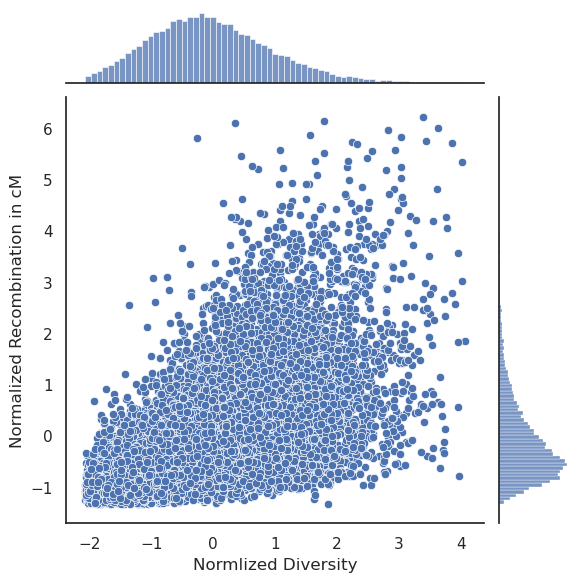

In [117]:
g = sns.jointplot(norm_filter.loc[(norm_filter.Origin == "Serengeti, Tanzania") &
                              #(admix_div_mean["minor_parent_percentage"] < 0.5) &
                              (norm_filter.callable_frac > 0.9)], x="norm_diversity", y="norm_recomb")
g.set_axis_labels(xlabel="Normlized Diversity", ylabel="Normalized Recombination in cM")

In [118]:
ser_div = admix_div_mean.loc[admix_div_mean.Origin == "Serengeti, Tanzania"].reset_index()
ser_div["tarangire_diff"] = (admix_div_mean.loc[admix_div_mean.Origin == "Serengeti, Tanzania"].minor_parent_percentage.reset_index()-admix_div_mean.loc[admix_div_mean.Origin == "Tarangire, Tanzania"].minor_parent_percentage.reset_index()).minor_parent_percentage
ser_div = ser_div.loc[(ser_div.callable_frac > 0.9)]
glm_results = smf.glm(formula = "tarangire_diff ~ diversity", data=ser_div,
                         var_weights=np.asarray(ser_div.diversity)
                         ).fit()
print(glm_results.summary(), glm_results.pvalues[1])

                 Generalized Linear Model Regression Results                  
Dep. Variable:         tarangire_diff   No. Observations:                22963
Model:                            GLM   Df Residuals:                    22961
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      5.3574e-05
Method:                          IRLS   Log-Likelihood:                 6290.3
Date:                Fri, 22 Aug 2025   Deviance:                       1.2301
Time:                        10:34:32   Pearson chi2:                     1.23
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001118
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1929      0.003    -56.818      0.0

In [119]:
yellow_pops = filter_qcut_recomb.loc[filter_qcut_recomb.Origin.isin(["Mikumi, Tanzania", "Ruaha, Tanzania"])]
glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity*Origin", data=yellow_pops,
                         var_weights=np.asarray(yellow_pops.diversity)
                         ).fit()
print(glm_results.summary(), glm_results.pvalues[0], glm_results.pvalues[3])

                    Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                49080
Model:                                 GLM   Df Residuals:                    49076
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      9.4645e-06
Method:                               IRLS   Log-Likelihood:                 56404.
Date:                     Fri, 22 Aug 2025   Deviance:                      0.46448
Time:                             10:34:33   Pearson chi2:                    0.464
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2074
Covariance Type:                 nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

ChrX case

In [120]:
chrX_mean = mean_window_df_tanz_eth.loc[mean_window_df_tanz_eth.chrom == "all_chrX"]
chrX_mean["chrom"] = "chrX"
admix_div_chrX_all = mean_diversity.merge(chrX_mean, on=["chrom", "start"])
admix_div_chrX_all["North Percentage"] = admix_div_chrX_all.north_sum/100000
admix_div_chrX_all = admix_div_chrX_all.merge(c_r_g_df, on=["chrom", "start"])
admix_div_chrX_all["Species"] = admix_div_chrX_all.Origin.map(dict(zip(meta_data_samples_sci.Origin, meta_data_samples_sci.Species)))


/tmp/3137777/ipykernel_1554377/4154381476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrX_mean["chrom"] = "chrX"


In [121]:
#Selecting the cases of interest and setting Minor Parent Ancestry
origins_interest = ['Arusha, Tanzania',
       'Gog Woreda, Gambella region, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia_eth_case',
       'Gombe, Tanzania', 'Issa Valley, Tanzania',
       'Katavi, Tanzania','Lake Manyara, Tanzania',
       'Mahale, Tanzania',
       'Mikumi, Tanzania', 'Ngorongoro, Tanzania', 'Ruaha, Tanzania',
       'Selous, Tanzania', 'Serengeti, Tanzania', 'Tarangire, Tanzania',
       'Udzungwa, Tanzania']
admix_div_chrX_all = admix_div_chrX_all.loc[admix_div_chrX_all.Origin.isin(origins_interest)]
admix_div_chrX_all["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Gambella region, Ethiopia_eth_case"
                                             else 1-x for x, y, z in zip(admix_div_chrX_all["North Percentage"],
                                                                         admix_div_chrX_all["Species"],
                                                                        admix_div_chrX_all["Origin"])]
admix_div_chrX_all["local_minor_ancestry"] = [min(x, 1-x) for x in admix_div_chrX_all["North Percentage"]]
filter_callable_chrX = admix_div_chrX_all.loc[admix_div_chrX_all.callable_frac > 0.9]
filter_callable_chrX.loc[filter_callable_chrX['Origin'] == 'Gog Woreda, Gambella region, Ethiopia_eth_case', ['Origin']] = 'Gog Woreda, Ethiopia'
filter_callable_chrX["diversity"].quantile([0.005, 0.995])

0.005     0.000147
0.995      0.00156
Name: diversity, dtype: float64

Plot of difference in frequencies across the autosome and ChrX.

In [122]:
filter_callable_all = pd.concat([filter_callable_chrX, filter_callable])
filter_callable_all["chrom_type"] = ["autosome" if x != "chrX" else "chrX" for x in filter_callable_all.chrom]

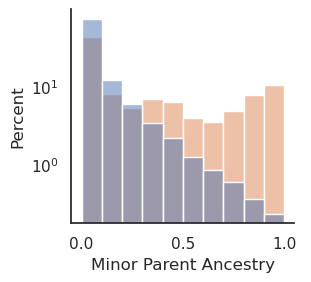

In [123]:
g = sns.FacetGrid(filter_callable_all.loc[filter_callable_all.Origin.isin(["Gog Woreda, Ethiopia"])])
g.map_dataframe(sns.histplot, x="minor_parent_percentage", hue="chrom_type", hue_order=["autosome", "chrX"],
                 common_norm = False, bins=10, stat="percent") 
g.add_legend()
g.set(yscale="log")
#g.set_titles(col_template="{col_name}")
g.set(xlabel="Minor Parent Ancestry")

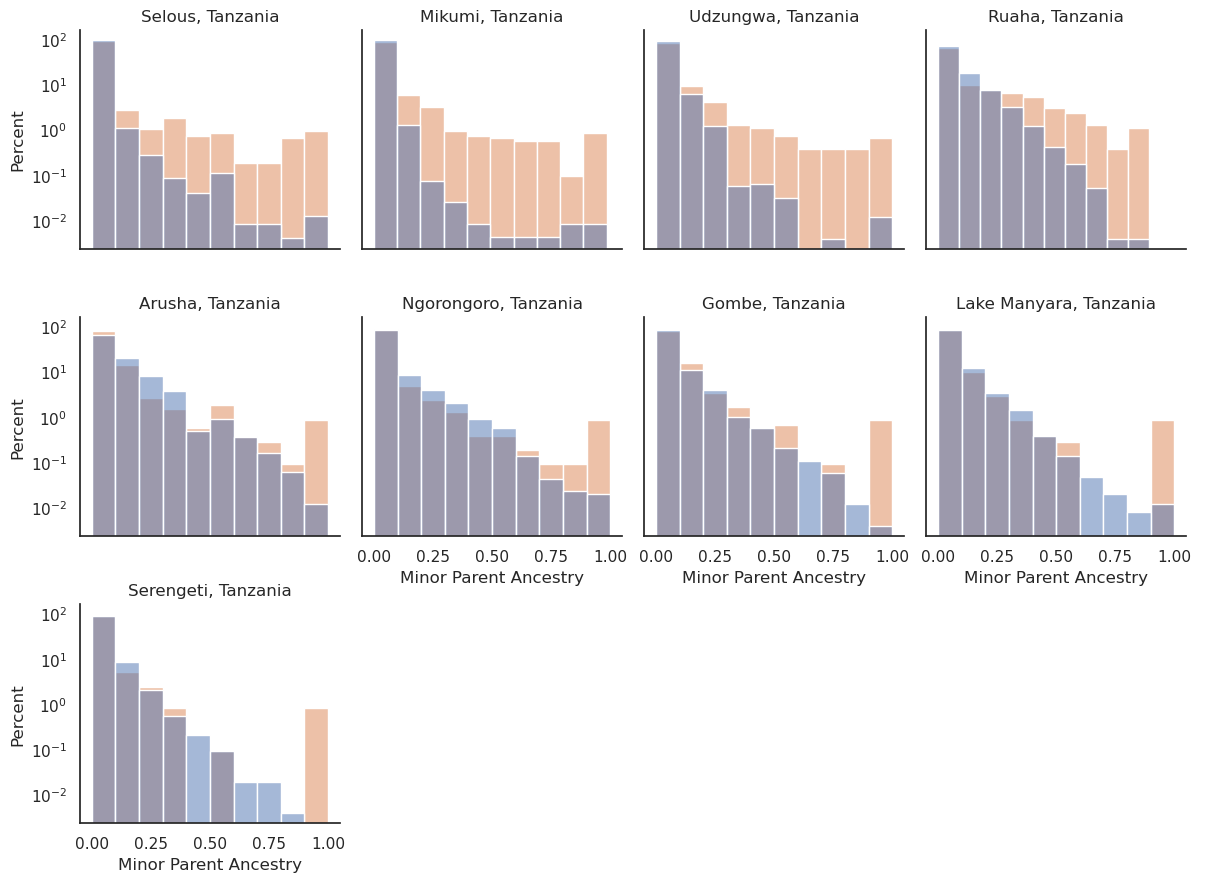

In [124]:
g = sns.FacetGrid(filter_callable_all.loc[filter_callable_all.Origin.isin(result_order_no_gog)], col="Origin",
                  col_wrap = 4, col_order=result_order_no_gog,legend_out=True)
g.map_dataframe(sns.histplot, x="minor_parent_percentage", hue="chrom_type", hue_order=["autosome", "chrX"],
                 common_norm = False, bins=10, stat="percent") 
g.add_legend()
g.set(yscale="log")
g.set_titles(col_template="{col_name}")
g.set(xlabel="Minor Parent Ancestry")


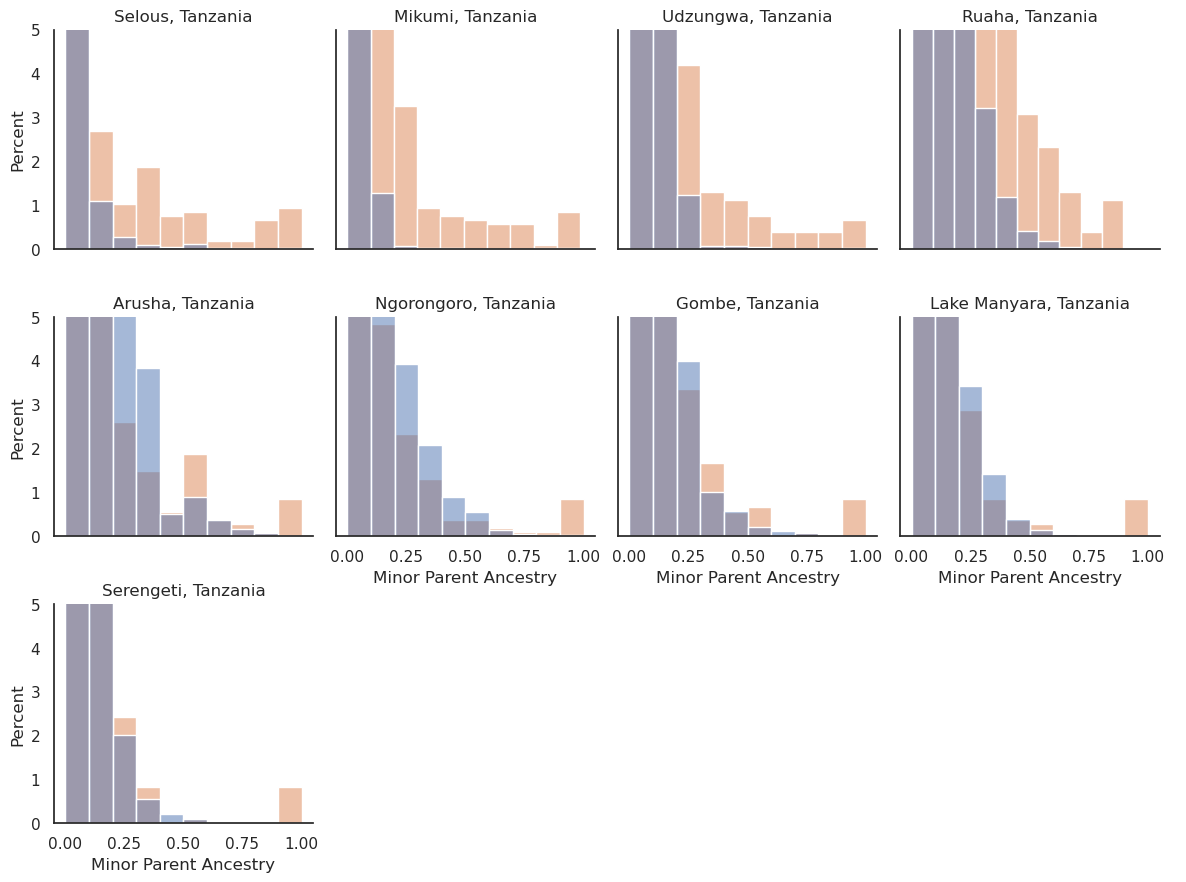

In [125]:
g = sns.FacetGrid(filter_callable_all.loc[filter_callable_all.Origin.isin(result_order_no_gog)], col="Origin",
                  col_wrap = 4, col_order=result_order_no_gog,legend_out=True)
g.map_dataframe(sns.histplot, x="minor_parent_percentage", hue="chrom_type", hue_order=["autosome", "chrX"],
                 common_norm = False, bins=10, stat="percent") 
g.add_legend()
g.set(ylim=(0, 5))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Minor Parent Ancestry")

In [126]:
result_order_no_gog_tarangire = ['Selous, Tanzania',
 'Mikumi, Tanzania',
 'Udzungwa, Tanzania',
 'Ruaha, Tanzania',
"Tarangire, Tanzania",
 'Arusha, Tanzania',
 'Ngorongoro, Tanzania',
 'Gombe, Tanzania',
 'Lake Manyara, Tanzania',
 'Serengeti, Tanzania']

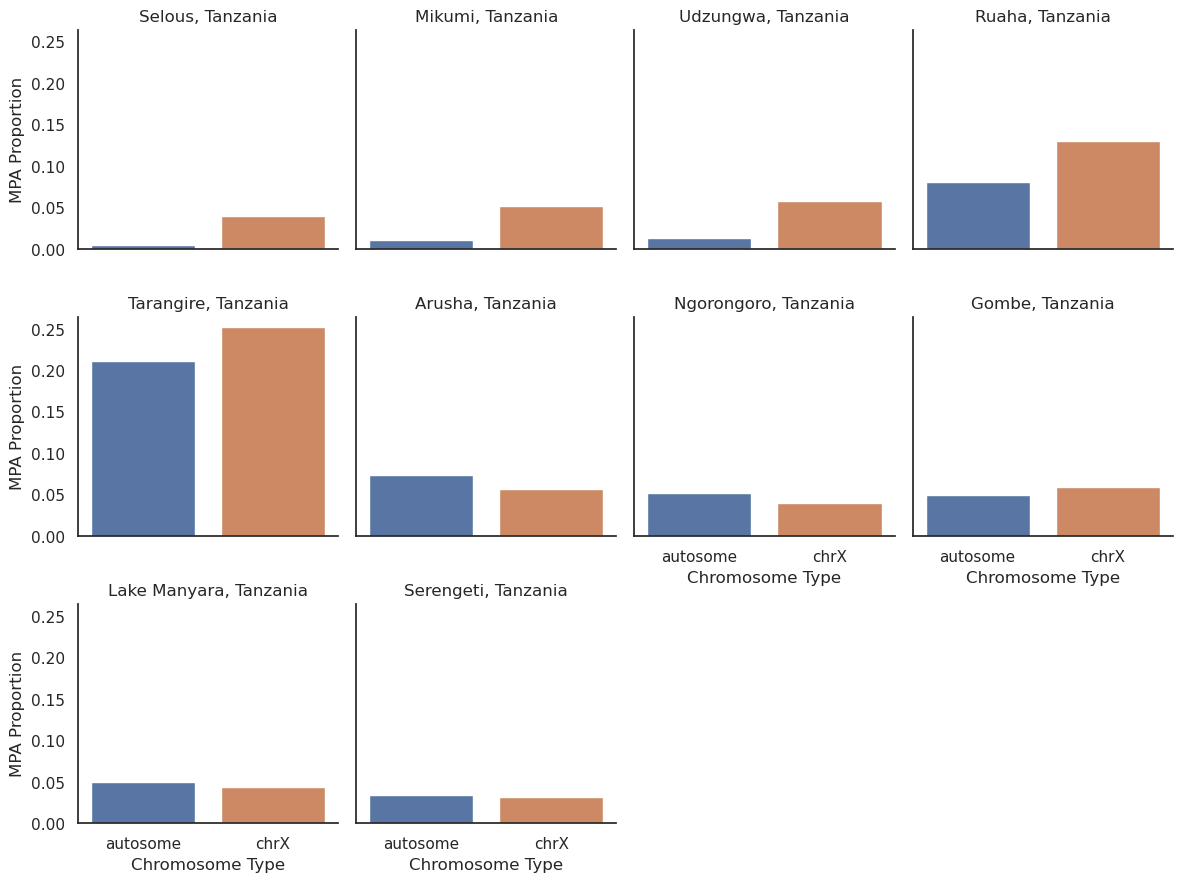

In [148]:
g = sns.FacetGrid(filter_callable_all.loc[filter_callable_all.Origin.isin(result_order_no_gog_tarangire)].sort_values(by=["chrom"]), col="Origin",
                  col_wrap = 4, col_order=result_order_no_gog_tarangire)
g.map_dataframe(sns.barplot, y="minor_parent_percentage", x="chrom_type", palette=sns.color_palette(), errorbar=None) 
g.set_titles(col_template="{col_name}")
g.set(xlabel="Chromosome Type", ylabel="MPA Proportion")

In [128]:
filter_callable_all.loc[filter_callable_all.Origin.isin(gog)].chrom.unique()

array(['chrX', 'chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14',
       'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20',
       'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
      dtype=object)

In [129]:
filter_qcut_chrX = filter_callable_chrX.loc[(filter_callable_chrX.diversity >= 0.000147) & 
                                           (filter_callable_chrX.diversity <= 0.00156)]

In [130]:
filter_qcut.loc[filter_qcut.Origin.isin(gog)].diversity.mean(), filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)].diversity.mean()

(0.0017118524695634901, 0.0006392304305855299)

In [131]:
filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)].diversity.mean()/filter_qcut.loc[filter_qcut.Origin.isin(gog)].diversity.mean()

0.3734144395915899

In [132]:
from scipy.stats import mannwhitneyu
res = mannwhitneyu(filter_qcut.loc[filter_qcut.Origin.isin(gog)].diversity*0.75,
                   filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)].diversity, alternative="greater")
print(res)

MannwhitneyuResult(statistic=24084280.0, pvalue=0.0)


In [133]:
import statsmodels.api as sm
df_l = []
for o in result_order:
    o_div = filter_qcut_chrX.loc[filter_qcut_chrX.Origin == o]
    Y = o_div["minor_parent_percentage"]
    X = o_div.diversity
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print(o)
    #print(results.t_test([1, 0]))
    het_test = sm.stats.het_breuschpagan(resid=results.resid, exog_het=X)
    print(het_test)
    #print(sm.stats.diagnostic.linear_harvey_collier(results))
    df_l.append(list(het_test))
bp_df = pd.DataFrame(df_l, columns=["Lagrange Multiplier", "Lagrange Multiplier P-value", "F-statistic", "F-statistic P-value"])
bp_df["Origin"] = result_order
bp_df

Selous, Tanzania
(8.53660644255287, 0.0034807398432332706, 8.589524767656314, 0.0034534871951767228)
Mikumi, Tanzania
(7.2021339210137825, 0.0072816944956485595, 7.237620320804808, 0.007251264067962557)
Udzungwa, Tanzania
(6.816892720289332, 0.009029954694005844, 6.847982254569008, 0.009000320514934499)
Ruaha, Tanzania
(4.049160296961743, 0.044193322274407365, 4.056995767887763, 0.04424069346176127)
Tarangire, Tanzania
(1.7621305095065893, 0.18435899673549105, 1.761735539539376, 0.18469371949128613)
Arusha, Tanzania
(12.052930497583995, 0.0005171102365125881, 12.168223908737176, 0.0005060383519356125)
Ngorongoro, Tanzania
(17.768781848984688, 2.494427316039503e-05, 18.036848894661418, 2.356720135878932e-05)
Gombe, Tanzania
(10.261710290251443, 0.0013581970865274337, 10.342242439912251, 0.001339477679058115)
Lake Manyara, Tanzania
(10.497393338518512, 0.0011954306936787003, 10.582144178717845, 0.0011778546813384875)
Serengeti, Tanzania
(9.538638825880486, 0.0020119089505422154, 9.606897

Lagrange Multiplier  Lagrange Multiplier P-value  F-statistic  \
0                  8.54                      0.00348         8.59   
1                   7.2                      0.00728         7.24   
2                  6.82                      0.00903         6.85   
3                  4.05                       0.0442         4.06   
4                  1.76                        0.184         1.76   
5                  12.1                     0.000517         12.2   
6                  17.8                     2.49e-05           18   
7                  10.3                      0.00136         10.3   
8                  10.5                       0.0012         10.6   
9                  9.54                      0.00201         9.61   
10                 9.67                      0.00187         9.74   

    F-statistic P-value                  Origin  
0               0.00345        Selous, Tanzania  
1               0.00725        Mikumi, Tanzania  
2                 0.009      Udzungwa, Tanzania  
3                0.0442         Ruaha, Tanzania  
4                 0.185     Tarangire, Tanzania  
5              0.000506        Arusha, Tanzania  
6              2.36e-05    Ngorongoro, Tanzania  
7               0.00134         Gombe, Tanzania  
8               0.00118  Lake Manyara, Tanzania  
9               0.00199     Serengeti, Tanzania  
10              0.00185    Gog Woreda, Ethiopia

/tmp/3137777/ipykernel_1554377/515002999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Diversity Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,


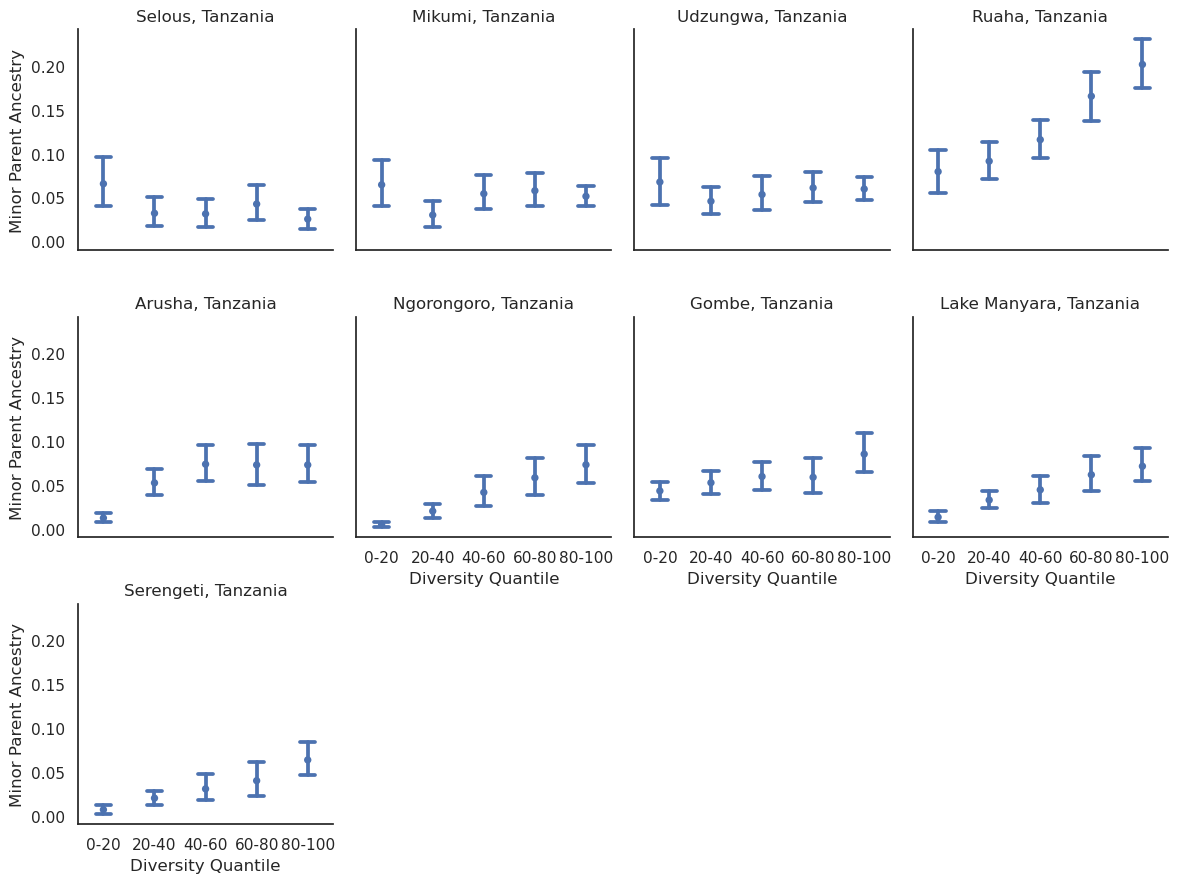

In [134]:
filter_qcut_chrX["Diversity Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
g = sns.FacetGrid(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(result_order_no_gog)], col="Origin",
                  col_wrap = 4, col_order=result_order_no_gog)
g.map_dataframe(sns.pointplot, y="minor_parent_percentage", x="Diversity Quantile", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
#g.set(xlim=(0, 0.25))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Diversity Quantile", ylabel="Minor Parent Ancestry")

/tmp/3137777/ipykernel_1554377/3625251695.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Diversity Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
/tmp/3137777/ipykernel_1554377/3625251695.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["chrom_type"] = "chrX"


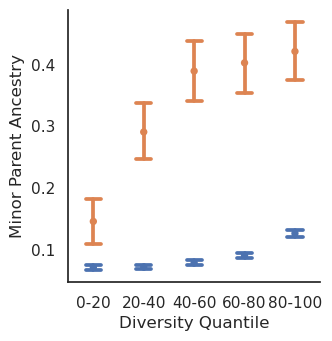

In [135]:
filter_qcut["Diversity Quantile"] = pd.qcut(filter_qcut.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
filter_qcut["chrom_type"] = "autosome"

filter_qcut_chrX["Diversity Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
filter_qcut_chrX["chrom_type"] = "chrX"
concat_df = pd.concat([filter_qcut, filter_qcut_chrX])

g = sns.FacetGrid(concat_df.loc[concat_df.Origin.isin(["Gog Woreda, Ethiopia"])], hue="chrom_type")
g.map_dataframe(sns.pointplot, y="minor_parent_percentage", x="Diversity Quantile", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
#g.set(xlim=(0, 0.25))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Diversity Quantile", ylabel="Minor Parent Ancestry")
g.fig.set_figwidth(3.8)
g.fig.set_figheight(3.8)

In [136]:
o_l, low_l, high_l, effect_l, effect_hl_l = [], [], [], [], []
filter_qcut_chrX["Recombination Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
for o in result_order:
    s_df = filter_qcut_chrX.loc[filter_qcut_chrX.Origin == o]
    #print(o, s_df.groupby(["Recombination Quantile"])[["minor_parent_percentage"]].mean())
    low_mean = s_df.loc[s_df["Recombination Quantile"] == "0-20"][["minor_parent_percentage"]].mean()[0]*100
    high_mean = s_df.loc[s_df["Recombination Quantile"] == "80-100"][["minor_parent_percentage"]].mean()[0]*100
    o_l.append(o)
    low_l.append(low_mean)
    high_l.append(high_mean)
    effect_l.append(high_mean/low_mean-1)

mean_quantile_df = pd.DataFrame({"Origin": o_l, "0-20 Minor Parent Percentage": low_l, 
                        "80-100 Minor Parent Percentage": high_l, "Relative Increase": effect_l})
mean_quantile_df["Absolute Increase"] = mean_quantile_df["80-100 Minor Parent Percentage"]-mean_quantile_df["0-20 Minor Parent Percentage"]
mean_quantile_df

/tmp/3137777/ipykernel_1554377/3187102455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Recombination Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,


Origin  0-20 Minor Parent Percentage  \
0         Selous, Tanzania                          6.56   
1         Mikumi, Tanzania                          6.45   
2       Udzungwa, Tanzania                          6.76   
3          Ruaha, Tanzania                          7.94   
4      Tarangire, Tanzania                          25.7   
5         Arusha, Tanzania                          1.21   
6     Ngorongoro, Tanzania                         0.471   
7          Gombe, Tanzania                           4.3   
8   Lake Manyara, Tanzania                          1.31   
9      Serengeti, Tanzania                         0.704   
10    Gog Woreda, Ethiopia                          14.5   

    80-100 Minor Parent Percentage  Relative Increase  Absolute Increase  
0                             2.54             -0.613              -4.02  
1                             5.14             -0.203              -1.31  
2                             5.97             -0.118             -0.797  
3                             20.1               1.54               12.2  
4                             23.6            -0.0806              -2.07  
5                             7.25               4.98               6.04  
6                             7.27               14.4                6.8  
7                             8.49              0.975               4.19  
8                              7.1               4.44                5.8  
9                             6.37               8.04               5.66  
10                            42.1                1.9               27.6

In [137]:
o_l, low_l, high_l, effect_l, effect_hl_l = [], [], [], [], []
filter_qcut_chrX["Diversity Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
for o in result_order:
    s_df = filter_qcut_chrX.loc[filter_qcut_chrX.Origin == o]
    #print(o, s_df.groupby(["Diversity Quantile"])[["minor_parent_percentage"]].mean())
    low_mean = s_df.loc[s_df["Diversity Quantile"] == "0-20"][["minor_parent_percentage"]].mean()[0]*100
    high_mean = s_df.loc[s_df["Diversity Quantile"] == "80-100"][["minor_parent_percentage"]].mean()[0]*100
    o_l.append(o)
    low_l.append(low_mean)
    high_l.append(high_mean)
    effect_l.append(high_mean/low_mean)

/tmp/3137777/ipykernel_1554377/2844885158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Diversity Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,


In [138]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

In [139]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut_chrX.loc[filter_qcut_chrX.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                 1063
Model:                                 GLM   Df Residuals:                     1061
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.0851e-05
Method:                               IRLS   Log-Likelihood:                 596.21
Date:                     Fri, 22 Aug 2025   Deviance:                     0.011513
Time:                             10:34:49   Pearson chi2:                   0.0115
No. Iterations:                          3   Pseudo R-squ. (CS):           0.006131
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [140]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut_chrX.loc[filter_qcut_chrX.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                 1063
Model:                                 GLM   Df Residuals:                     1061
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.0851e-05
Method:                               IRLS   Log-Likelihood:                 596.21
Date:                     Fri, 22 Aug 2025   Deviance:                     0.011513
Time:                             10:34:49   Pearson chi2:                   0.0115
No. Iterations:                          3   Pseudo R-squ. (CS):           0.006131
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [141]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_diversity_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania     0.0605      -33.1           2.57e-08   
1         Mikumi, Tanzania     0.0505       1.64           1.14e-06   
2       Udzungwa, Tanzania     0.0489       11.9           8.84e-06   
3          Ruaha, Tanzania      0.031        156             0.0502   
4      Tarangire, Tanzania       0.28      -40.3           4.35e-53   
5         Arusha, Tanzania     0.0399       32.1            0.00236   
6     Ngorongoro, Tanzania     -0.012       81.1              0.308   
7          Gombe, Tanzania     0.0188       61.7              0.108   
8   Lake Manyara, Tanzania    0.00314       65.6              0.772   
9      Serengeti, Tanzania    -0.0112         68              0.273   
10    Gog Woreda, Ethiopia      0.205        214           1.85e-12   

    Slope P-value  Intercept stderr  Slope stderr  
0          0.0106            0.0109            13  
1           0.895            0.0104          12.4  
2           0.366             0.011          13.1  
3        1.79e-16            0.0158          18.9  
4          0.0643            0.0183          21.8  
5          0.0403            0.0131          15.7  
6        8.19e-09            0.0118          14.1  
7        9.83e-06            0.0117            14  
8        3.69e-07            0.0108          12.9  
9        2.47e-08            0.0102          12.2  
10       7.18e-10            0.0291          34.7

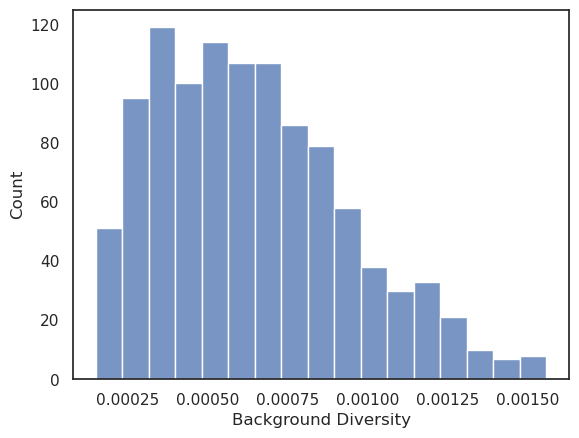

In [142]:
import matplotlib.ticker as ticker
g = sns.histplot(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)], x="diversity", )
g.set(xlabel = "Background Diversity")
g.xaxis.set_major_locator(ticker.MultipleLocator(0.00025))

In [143]:
filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)].diversity.mean(), filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)].diversity.median()

(0.0006392304305855299, 0.0006023039215686274)

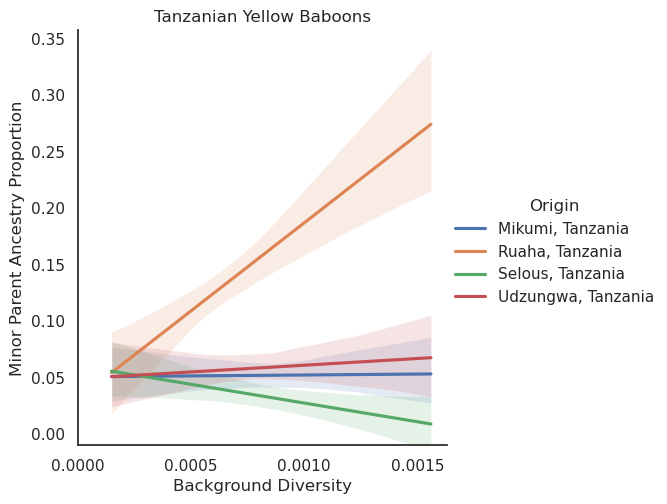

In [144]:
g = lmplot(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(yellows)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Yellow Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=[0, 0.0005, 0.001, 0.0015])

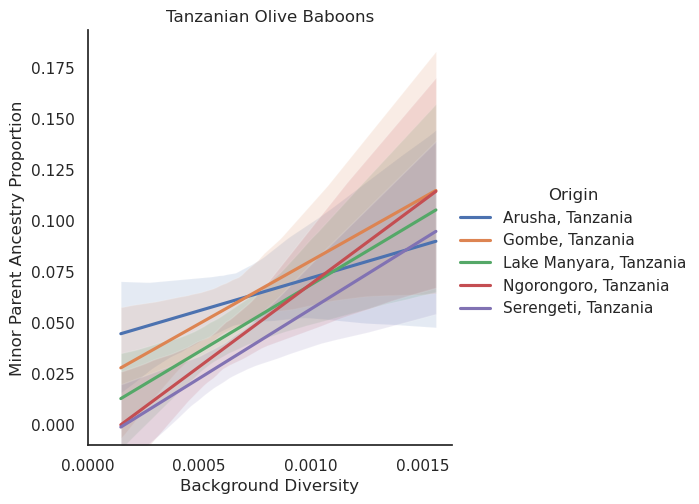

In [145]:
g = lmplot(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(olives)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Olive Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=[0, 0.0005, 0.001, 0.0015])

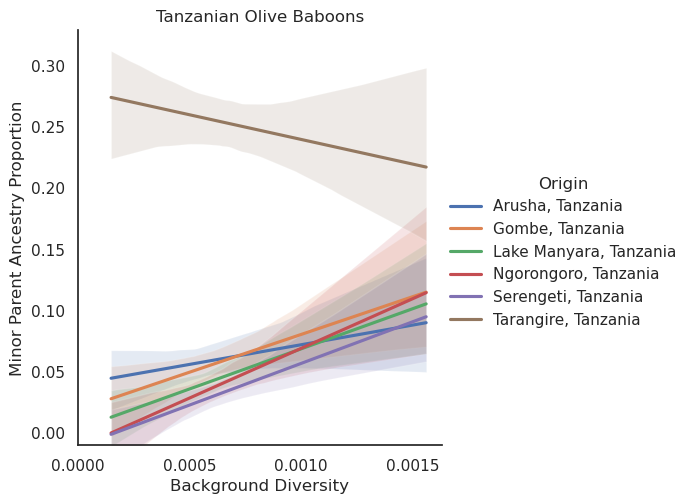

In [150]:
g = lmplot(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(olives_with_tarangire)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Olive Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=[0, 0.0005, 0.001, 0.0015])

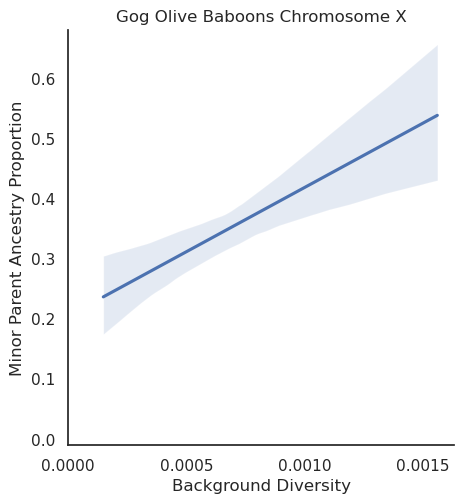

In [146]:
g = lmplot(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)], x="diversity", y="minor_parent_percentage",
                            scatter=False, weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Gog Olive Baboons Chromosome X")
g.set(ylim=(-0.01, None))
g.set(xticks=[0, 0.0005, 0.001, 0.0015])

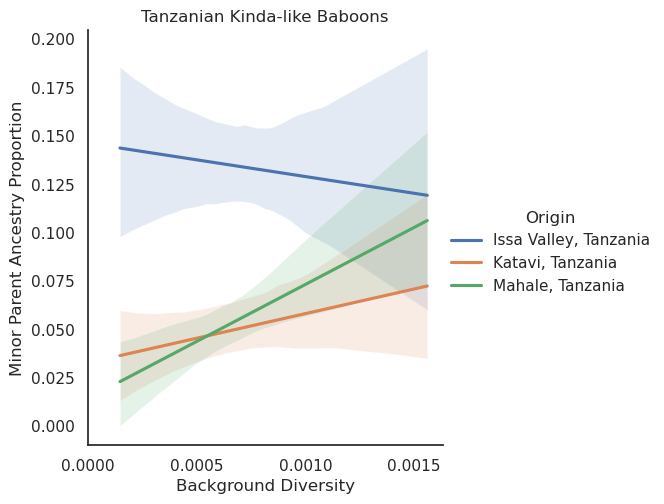

In [156]:
g = lmplot(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(["Mahale, Tanzania",
                                                           "Katavi, Tanzania",
                                                           "Issa Valley, Tanzania"])], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Kinda-like Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=[0, 0.0005, 0.001, 0.0015])

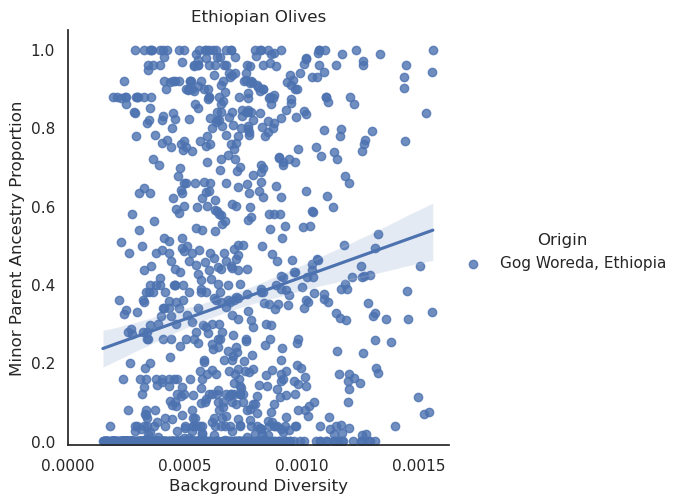

In [157]:
g = lmplot(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(gog)], x="diversity", y="minor_parent_percentage",
                             hue="Origin", weighted=True, n_boot=1000) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Ethiopian Olives")
g.set(ylim=(-0.01, None))
g.set(xticks=[0, 0.0005, 0.001, 0.0015])

In [161]:
filter_callable_chrX["average_cM_window"].quantile([0.005, 0.995])

0.005     1.96e-08
0.995     4.15e-06
Name: average_cM_window, dtype: float64

In [162]:
filter_qcut_recomb_chrX = filter_callable_chrX.loc[(filter_callable_chrX.average_cM_window >=1.96e-08) &
                                                      (filter_callable_chrX.average_cM_window <=4.15e-06)]
filter_qcut_recomb_chrX["window_cM"] = filter_qcut_recomb_chrX.average_cM_window*100000

/tmp/53630012/ipykernel_3995122/1395215121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_recomb_chrX["window_cM"] = filter_qcut_recomb_chrX.average_cM_window*100000


In [163]:
o_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut_recomb_chrX.loc[filter_qcut_recomb_chrX.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ window_cM", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
    pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
    stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                 1063
Model:                                 GLM   Df Residuals:                     1061
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.0927e-05
Method:                               IRLS   Log-Likelihood:                 591.58
Date:                     Tue, 04 Feb 2025   Deviance:                     0.011594
Time:                             12:58:52   Pearson chi2:                   0.0116
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001204
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [164]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_diversity_df

Origin  Intercept      Slope  Intercept P-value  \
0         Selous, Tanzania     0.0413     -0.075            1.8e-09   
1         Mikumi, Tanzania     0.0457     0.0751           2.91e-12   
2       Udzungwa, Tanzania     0.0479      0.122           4.06e-12   
3          Ruaha, Tanzania     0.0961      0.658           5.88e-22   
4      Tarangire, Tanzania      0.255    -0.0716          1.99e-109   
5         Arusha, Tanzania     0.0479      0.201           6.34e-09   
6     Ngorongoro, Tanzania     0.0235      0.337            0.00164   
7          Gombe, Tanzania     0.0495      0.197           1.93e-11   
8   Lake Manyara, Tanzania     0.0439      0.126            1.7e-10   
9      Serengeti, Tanzania     0.0174       0.29            0.00695   
10    Gog Woreda, Ethiopia      0.279       1.07           1.45e-52   

    Slope P-value  Intercept stderr  Slope stderr  
0           0.258           0.00686        0.0664  
1           0.235           0.00654        0.0633  
2          0.0672            0.0069        0.0668  
3        9.23e-12           0.00997        0.0965  
4           0.519            0.0115         0.111  
5          0.0118           0.00826        0.0798  
6        3.04e-06           0.00746        0.0722  
7         0.00562           0.00737        0.0713  
8          0.0574           0.00687        0.0664  
9        3.57e-06           0.00646        0.0625  
10       1.39e-09            0.0183         0.177

In [165]:
norm_filter_chrX = filter_qcut_chrX.loc[(filter_qcut_chrX.average_cM_window >=1.96e-08) &
                                                      (filter_qcut_chrX.average_cM_window <=4.15e-06)]
norm_filter_chrX["norm_diversity"] = (norm_filter_chrX.diversity-norm_filter_chrX.diversity.mean())/(norm_filter_chrX.diversity.std())
norm_filter_chrX["norm_recomb"] = (norm_filter_chrX.average_cM_window-norm_filter_chrX.average_cM_window.mean())/(norm_filter_chrX.average_cM_window.std())

/tmp/53630012/ipykernel_3995122/1252545395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_filter_chrX["norm_diversity"] = (norm_filter_chrX.diversity-norm_filter_chrX.diversity.mean())/(norm_filter_chrX.diversity.std())
/tmp/53630012/ipykernel_3995122/1252545395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_filter_chrX["norm_recomb"] = (norm_filter_chrX.average_cM_window-norm_filter_chrX.average_cM_window.mean())/(norm_filter_chrX.average_cM_window.std())


In [166]:
autosome_chrX_norm = pd.concat([norm_filter, norm_filter_chrX])
autosome_chrX_norm["chrom_type"] = ["autosome" if x != "chrX" else "chrX" for x in autosome_chrX_norm.chrom]

In [167]:
o_l, slope_l, pval_slope_l, slope_multi, stderr_slope_l, div_l, pdiv_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = autosome_chrX_norm.loc[(autosome_chrX_norm.Origin == o)]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ norm_diversity * chrom_type", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[3])
    pval_slope_l.append(glm_results.pvalues[3])
    slope_multi.append(glm_results.params[3]/glm_results.params[2])
    div_l.append(glm_results.params[2]), pdiv_l.append(glm_results.pvalues[2])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25230
Model:                                 GLM   Df Residuals:                    25226
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      2.3379e-06
Method:                               IRLS   Log-Likelihood:                 46108.
Date:                     Tue, 04 Feb 2025   Deviance:                     0.058976
Time:                             12:58:53   Pearson chi2:                   0.0590
No. Iterations:                          3   Pseudo R-squ. (CS):            0.01200
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Ngorongoro, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                26257
Model:                                 GLM   Df Residuals:                    26253
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      1.6272e-05
Method:                               IRLS   Log-Likelihood:                 22528.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.42718
Time:                             12:58:53   Pearson chi2:                    0.427
No. Iterations:                          3   Pseudo R-squ. (CS):           0.002783
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [168]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Autosome Slope": div_l, "Interaction Slope": slope_l,
                                 "Relative Increase": slope_multi, "Autosome P-value": pdiv_l,
                                 "Interaction Slope P-value": pval_slope_l
                               })
glm_diversity_df

Origin  Autosome Slope  Interaction Slope  \
0         Selous, Tanzania        0.000429            -0.0102   
1         Mikumi, Tanzania         0.00123          -0.000699   
2       Udzungwa, Tanzania         0.00225            0.00165   
3          Ruaha, Tanzania         0.00536             0.0382   
4      Tarangire, Tanzania        -0.00101           -0.00849   
5         Arusha, Tanzania          0.0013            0.00952   
6     Ngorongoro, Tanzania         0.00395             0.0218   
7          Gombe, Tanzania         0.00604             0.0125   
8   Lake Manyara, Tanzania         0.00272             0.0182   
9      Serengeti, Tanzania         0.00265             0.0189   
10    Gog Woreda, Ethiopia          0.0223             0.0343   

    Relative Increase  Autosome P-value  Interaction Slope P-value  
0               -23.7            0.0626                   2.72e-08  
1              -0.568          1.35e-11                      0.626  
2               0.733          1.65e-16                      0.458  
3                7.12          1.41e-18                   1.42e-14  
4                8.41             0.337                      0.322  
5                7.32            0.0742                      0.109  
6                5.53          2.86e-11                   6.29e-06  
7                2.08          7.84e-33                    0.00235  
8                6.68          9.95e-09                   2.53e-06  
9                7.13          4.83e-12                   1.42e-09  
10               1.54         1.04e-122                   8.88e-06

In [169]:
selected_pops = ["Mahale, Tanzania","Katavi, Tanzania","Issa Valley, Tanzania"]

o_l, slope_l, pval_slope_l, slope_multi, stderr_slope_l, div_l, pdiv_l = [], [], [], [], [], [], []
for o in selected_pops:
    o_div = autosome_chrX_norm.loc[(autosome_chrX_norm.Origin == o)]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ norm_diversity * chrom_type", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[3])
    pval_slope_l.append(glm_results.pvalues[3])
    slope_multi.append(glm_results.params[3]/glm_results.params[2])
    div_l.append(glm_results.params[2]), pdiv_l.append(glm_results.pvalues[2])

Mahale, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                26257
Model:                                 GLM   Df Residuals:                    26253
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      2.1106e-05
Method:                               IRLS   Log-Likelihood:                 19113.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.55411
Time:                             12:58:54   Pearson chi2:                    0.554
No. Iterations:                          3   Pseudo R-squ. (CS):           0.005159
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [170]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Autosome Slope": div_l, "Interaction Slope": slope_l,
                                 "Relative Increase": slope_multi, "Autosome P-value": pdiv_l,
                                 "Interaction Slope P-value": pval_slope_l
                               })
glm_diversity_df

Origin  Autosome Slope  Interaction Slope  \
0       Mahale, Tanzania         0.00533             0.0105   
1       Katavi, Tanzania         0.00608           0.000208   
2  Issa Valley, Tanzania          0.0142            -0.0247   

   Relative Increase  Autosome P-value  Interaction Slope P-value  
0               1.98          2.97e-15                     0.0552  
1             0.0343          5.84e-14                      0.975  
2              -1.74           6.7e-12                       0.13

[None]

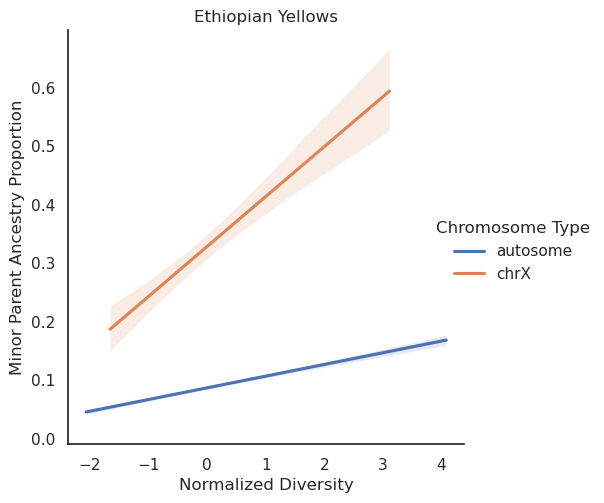

In [171]:
g = lmplot(autosome_chrX_norm.loc[autosome_chrX_norm.Origin.isin(gog)], x="norm_diversity", y="minor_parent_percentage",
                            scatter=False, hue="chrom_type", n_boot=1000) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Normalized Diversity", title="Ethiopian Yellows")
g.set(ylim=(-0.01, None))
g._legend.set(title="Chromosome Type")
#g.set(xticks=[0, 0.0005, 0.001, 0.0015])

In [172]:
o_l, slope_l, pval_slope_l, slope_multi, stderr_slope_l = [], [], [], [], []
for o in result_order:
    o_div = autosome_chrX_norm.loc[autosome_chrX_norm.Origin == o]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ norm_diversity * chrom_type", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[3])
    pval_slope_l.append(glm_results.pvalues[3]), stderr_slope_l.append(glm_results.bse[3])
    slope_multi.append(glm_results.params[3]/glm_results.params[2])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25230
Model:                                 GLM   Df Residuals:                    25226
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      2.3379e-06
Method:                               IRLS   Log-Likelihood:                 46108.
Date:                     Tue, 04 Feb 2025   Deviance:                     0.058976
Time:                             12:58:56   Pearson chi2:                   0.0590
No. Iterations:                          3   Pseudo R-squ. (CS):            0.01200
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Ngorongoro, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                26257
Model:                                 GLM   Df Residuals:                    26253
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      1.6272e-05
Method:                               IRLS   Log-Likelihood:                 22528.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.42718
Time:                             12:58:56   Pearson chi2:                    0.427
No. Iterations:                          3   Pseudo R-squ. (CS):           0.002783
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [173]:
o_l, slope_l, pval_slope_l, slope_multi, stderr_slope_l = [], [], [], [], []
for o in range(1):
    o_div = autosome_chrX_norm.loc[autosome_chrX_norm.Origin.isin(["Mahale, Tanzania", "Katavi, Tanzania"])]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ norm_diversity * chrom_type", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())

0                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                52514
Model:                                 GLM   Df Residuals:                    52510
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      2.5980e-05
Method:                               IRLS   Log-Likelihood:                 32769.
Date:                     Tue, 04 Feb 2025   Deviance:                       1.3642
Time:                             12:58:57   Pearson chi2:                     1.36
No. Iterations:                          3   Pseudo R-squ. (CS):           0.003640
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

[None]

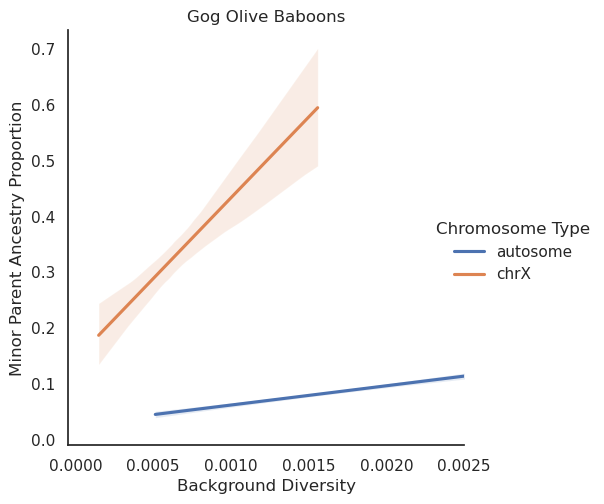

In [174]:
g = lmplot(autosome_chrX_norm.loc[autosome_chrX_norm.Origin.isin(gog)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="chrom_type", n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Gog Olive Baboons")
g.set(ylim=(-0.01, None), xlim=(None, 0.0025))
g._legend.set(title="Chromosome Type")

[None, None]

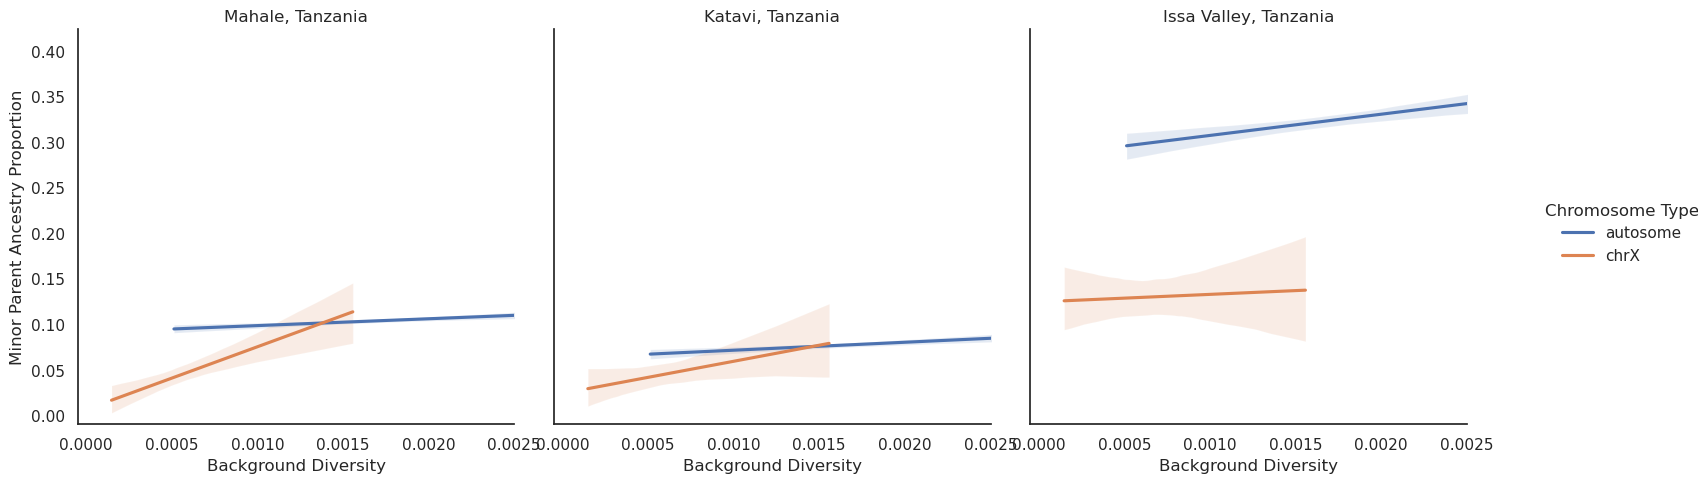

In [175]:
selected_pops = ["Mahale, Tanzania","Katavi, Tanzania","Issa Valley, Tanzania"]
g = lmplot(autosome_chrX_norm.loc[autosome_chrX_norm.Origin.isin(selected_pops)],
           x="diversity", y="minor_parent_percentage",
            scatter=False, hue="chrom_type", n_boot=1000, col="Origin", col_wrap=3,
          col_order=selected_pops, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity")
g.set(ylim=(-0.01, None), xlim=(None, 0.0025))
g.set_titles(col_template="{col_name}")
g._legend.set(title="Chromosome Type", bbox_to_anchor=(1.05, 0.5))

[None]

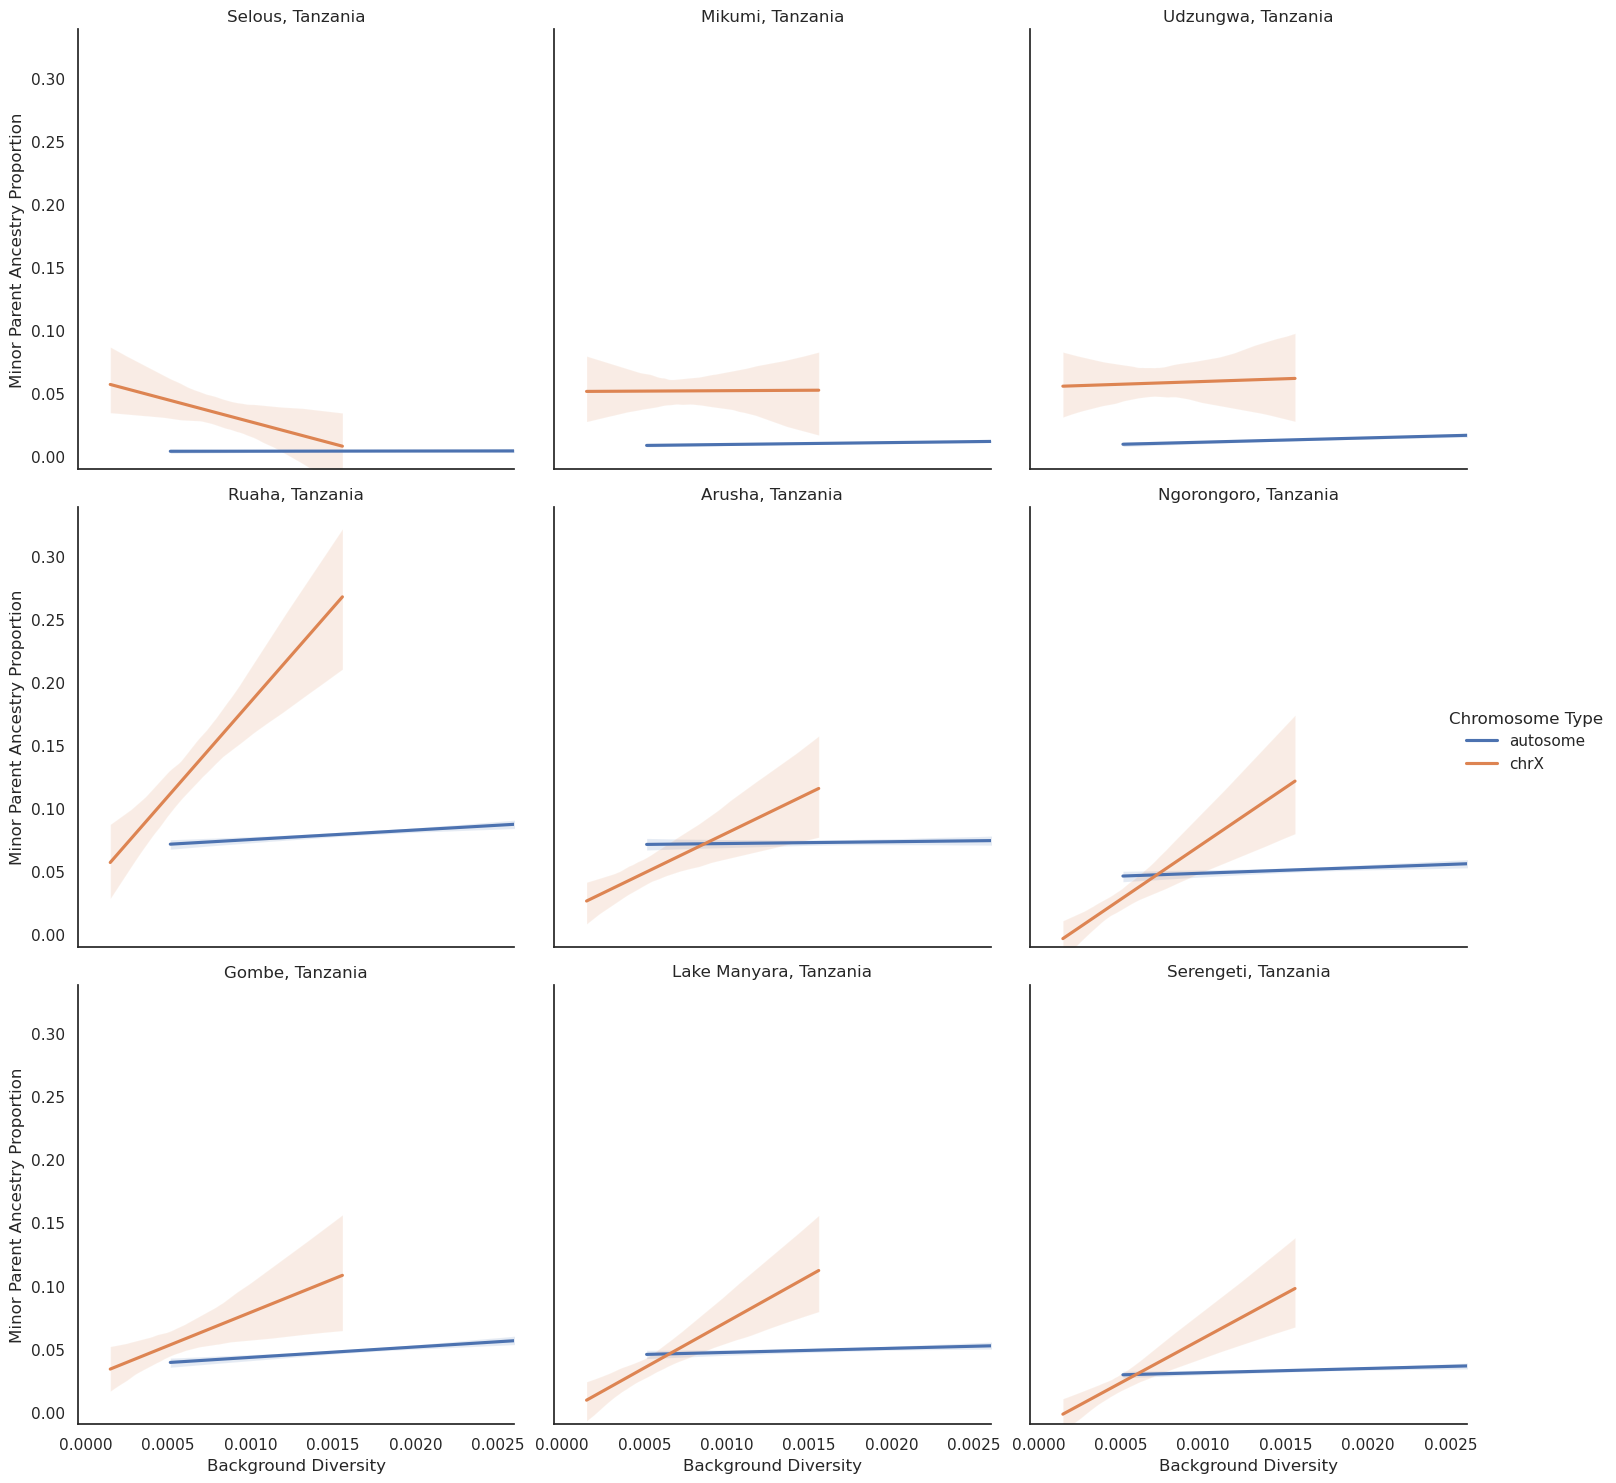

In [176]:
g = lmplot(autosome_chrX_norm.loc[autosome_chrX_norm.Origin.isin(result_order_no_gog)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="chrom_type", n_boot=1000, col="Origin", col_wrap=3, col_order=result_order_no_gog, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity")
g.set(ylim=(-0.01, None), xlim=(None, 0.0026))
g.set_titles(col_template="{col_name}")
g._legend.set(title="Chromosome Type")

In [177]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Interaction Slope": slope_l, "Relative Increase": slope_multi, "Slope P-value": pval_slope_l,
                               "Slope stderr": stderr_slope_l})
glm_diversity_df

Empty DataFrame
Columns: [Origin, Interaction Slope, Relative Increase, Slope P-value, Slope stderr]
Index: []

Removing high freq regions.

In [178]:
o_l, slope_l, pval_slope_l, slope_multi, stderr_slope_l, div_l, pdiv_l = [], [], [], [], [], [], []
for o in result_order:
    o_div = autosome_chrX_norm.loc[(autosome_chrX_norm.Origin == o) & (autosome_chrX_norm.minor_parent_percentage <= 0.25)]
    glm_results = smf.glm(formula = "minor_parent_percentage ~ norm_diversity * chrom_type", data=o_div,
                         var_weights=np.asarray(o_div["diversity"])).fit()
    print(o, glm_results.summary())
    o_l.append(o), slope_l.append(glm_results.params[3])
    pval_slope_l.append(glm_results.pvalues[3])
    slope_multi.append(glm_results.params[3]/glm_results.params[2])
    div_l.append(glm_results.params[2]), pdiv_l.append(glm_results.pvalues[2])

Selous, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25092
Model:                                 GLM   Df Residuals:                    25088
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      7.1968e-07
Method:                               IRLS   Log-Likelihood:                 60672.
Date:                     Tue, 04 Feb 2025   Deviance:                     0.018055
Time:                             12:59:13   Pearson chi2:                   0.0181
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001153
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Arusha, Tanzania                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                24366
Model:                                 GLM   Df Residuals:                    24362
Model Family:                     Gaussian   Df Model:                            3
Link Function:                    Identity   Scale:                      9.5367e-06
Method:                               IRLS   Log-Likelihood:                 27393.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.23233
Time:                             12:59:13   Pearson chi2:                    0.232
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001190
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [179]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "Autosome Slope": div_l, "Interaction Slope": slope_l,
                                 "Relative Increase": slope_multi, "Autosome P-value": pdiv_l,
                                 "Interaction Slope P-value": pval_slope_l
                               })
glm_diversity_df

Origin  Autosome Slope  Interaction Slope  \
0         Selous, Tanzania        8.82e-05            0.00176   
1         Mikumi, Tanzania         0.00137            0.00893   
2       Udzungwa, Tanzania         0.00216            0.00791   
3          Ruaha, Tanzania         0.00277             0.0174   
4      Tarangire, Tanzania        -0.00144             0.0025   
5         Arusha, Tanzania        0.000176            0.00121   
6     Ngorongoro, Tanzania         0.00173            0.00252   
7          Gombe, Tanzania         0.00331            0.00243   
8   Lake Manyara, Tanzania         0.00131             0.0101   
9      Serengeti, Tanzania          0.0015            0.00715   
10    Gog Woreda, Ethiopia         0.00848             0.0085   

    Relative Increase  Autosome P-value  Interaction Slope P-value  
0                  20             0.491                      0.091  
1                6.51          6.63e-22                   7.26e-15  
2                3.66          1.63e-22                   2.35e-05  
3                 6.3          7.91e-10                   1.98e-05  
4               -1.74            0.0175                      0.622  
5                6.92             0.711                       0.75  
6                1.46          5.99e-06                      0.426  
7               0.733          4.85e-21                      0.402  
8                7.67          0.000117                   0.000309  
9                4.77          2.82e-07                    0.00316  
10                  1          3.96e-97                     0.0502

[None]

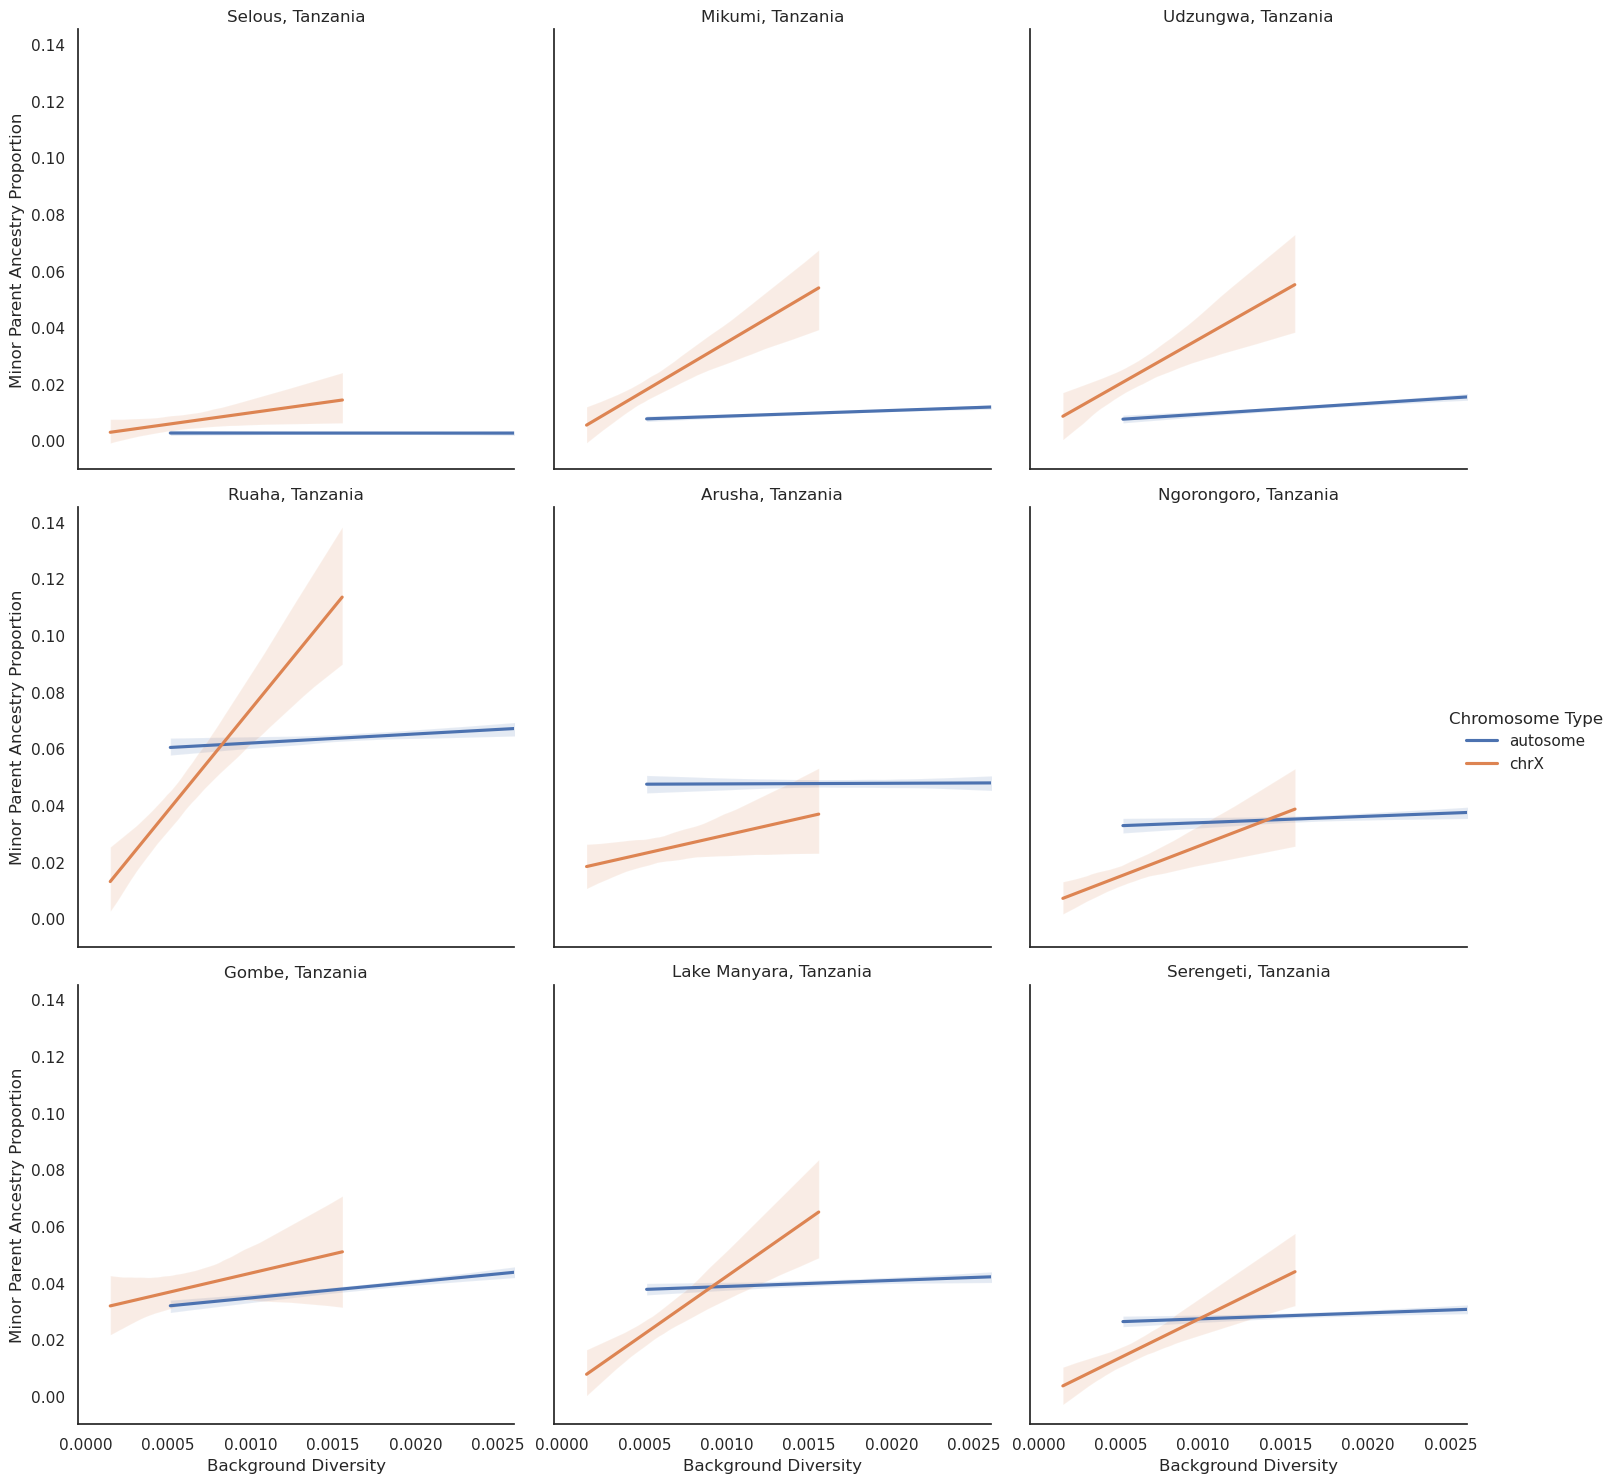

In [180]:
g = lmplot(autosome_chrX_norm.loc[autosome_chrX_norm.Origin.isin(result_order_no_gog) &
                                  (autosome_chrX_norm.minor_parent_percentage <= 0.25)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="chrom_type", n_boot=1000, col="Origin", col_wrap=3, col_order=result_order_no_gog, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity")
g.set(ylim=(-0.01, None), xlim=(None, 0.0026))
g.set_titles(col_template="{col_name}")
g._legend.set(title="Chromosome Type")

Quantiles of Admixture/Diversity

/tmp/53630012/ipykernel_3995122/3063631219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["ancestry"] = ["Pure Major" if x <= 0.1 else "Pure Minor" if x >= 0.9


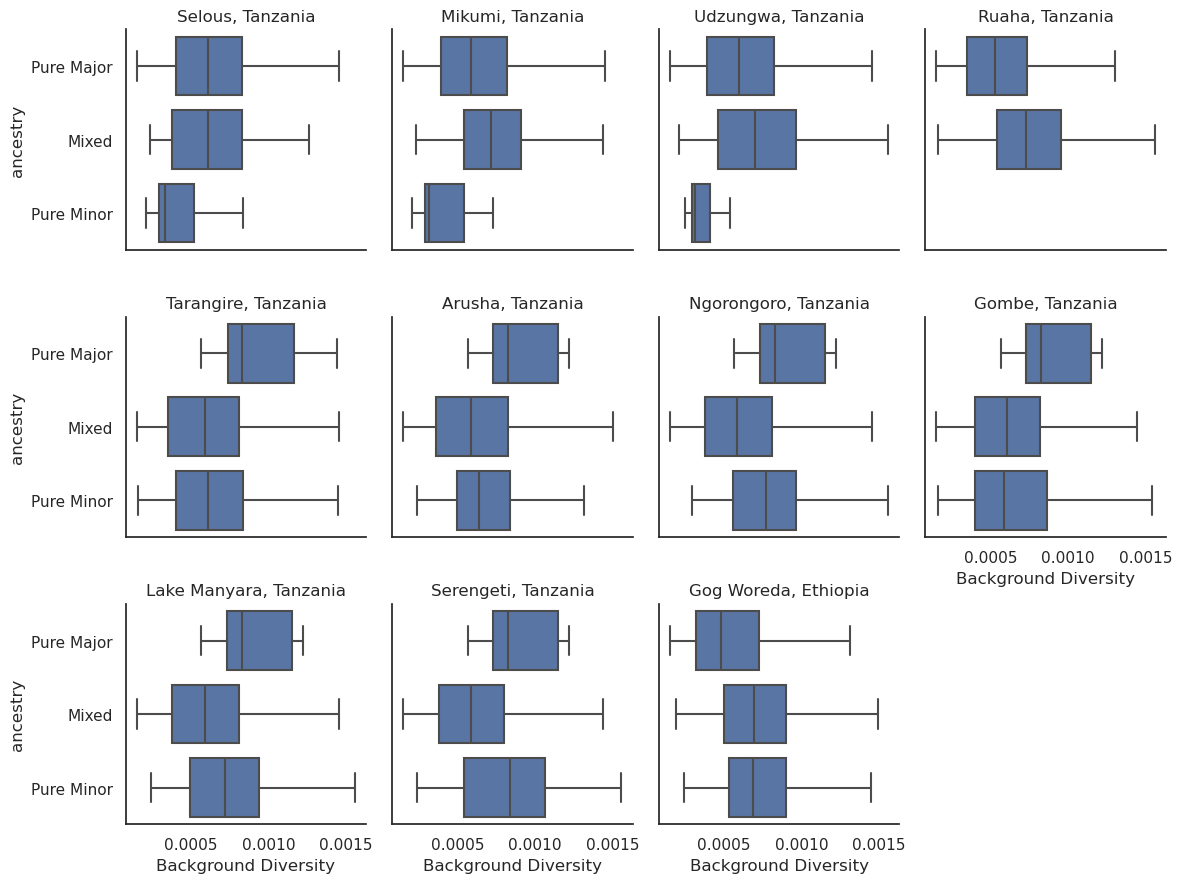

In [181]:
filter_qcut_chrX["ancestry"] = ["Pure Major" if x <= 0.1 else "Pure Minor" if x >= 0.9
                        else "Mixed" for x in filter_qcut_chrX["minor_parent_percentage"]]
g = sns.FacetGrid(filter_qcut_chrX.loc[filter_qcut_chrX.Origin.isin(result_order)], col="Origin",
                  col_wrap = 4, col_order=result_order)
g.map_dataframe(sns.boxplot, x="diversity", y="ancestry", fliersize=0)
g.set_titles(col_template="{col_name}")
g.set(xlabel="Background Diversity")

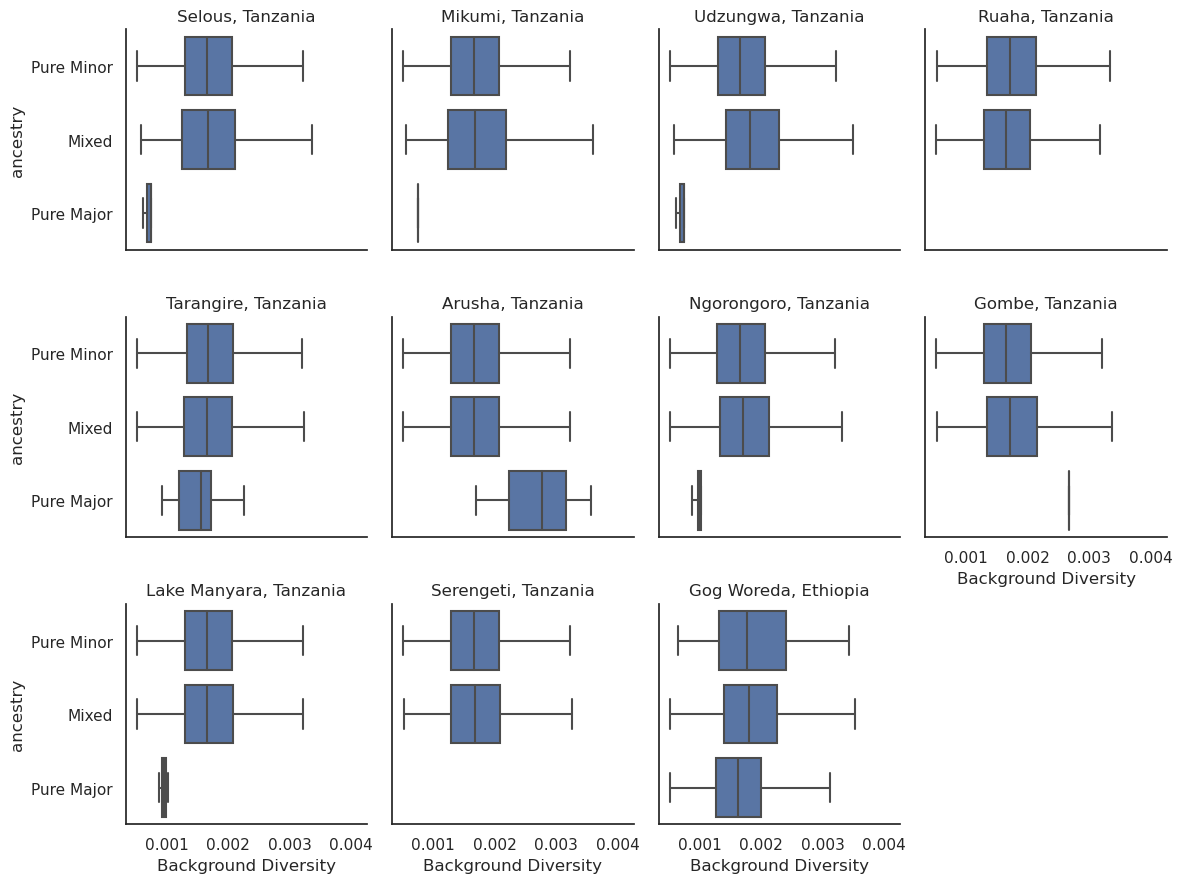

In [182]:
filter_qcut["ancestry"] = ["Pure Major" if x <= 0.1 else "Pure Minor" if x >= 0.9
                        else "Mixed" for x in filter_qcut["minor_parent_percentage"]]
g = sns.FacetGrid(filter_qcut.loc[filter_qcut.Origin.isin(result_order)], col="Origin",
                  col_wrap = 4, col_order=result_order)
g.map_dataframe(sns.boxplot, x="diversity", y="ancestry", fliersize=0)
g.set_titles(col_template="{col_name}")
g.set(xlabel="Background Diversity")

In [183]:
hama_df = filter_qcut.loc[(filter_qcut.Origin == "Gog Woreda, Ethiopia")][["chrom", "start", "ancestry"]]
hama_df_add = filter_qcut.merge(hama_df, on=["chrom", "start"])
hama_df_chrX = filter_qcut_chrX.loc[(filter_qcut_chrX.Origin == "Gog Woreda, Ethiopia")][["chrom", "start", "ancestry"]]
hama_df_add_chrX = filter_qcut_chrX.merge(hama_df_chrX, on=["chrom", "start"])

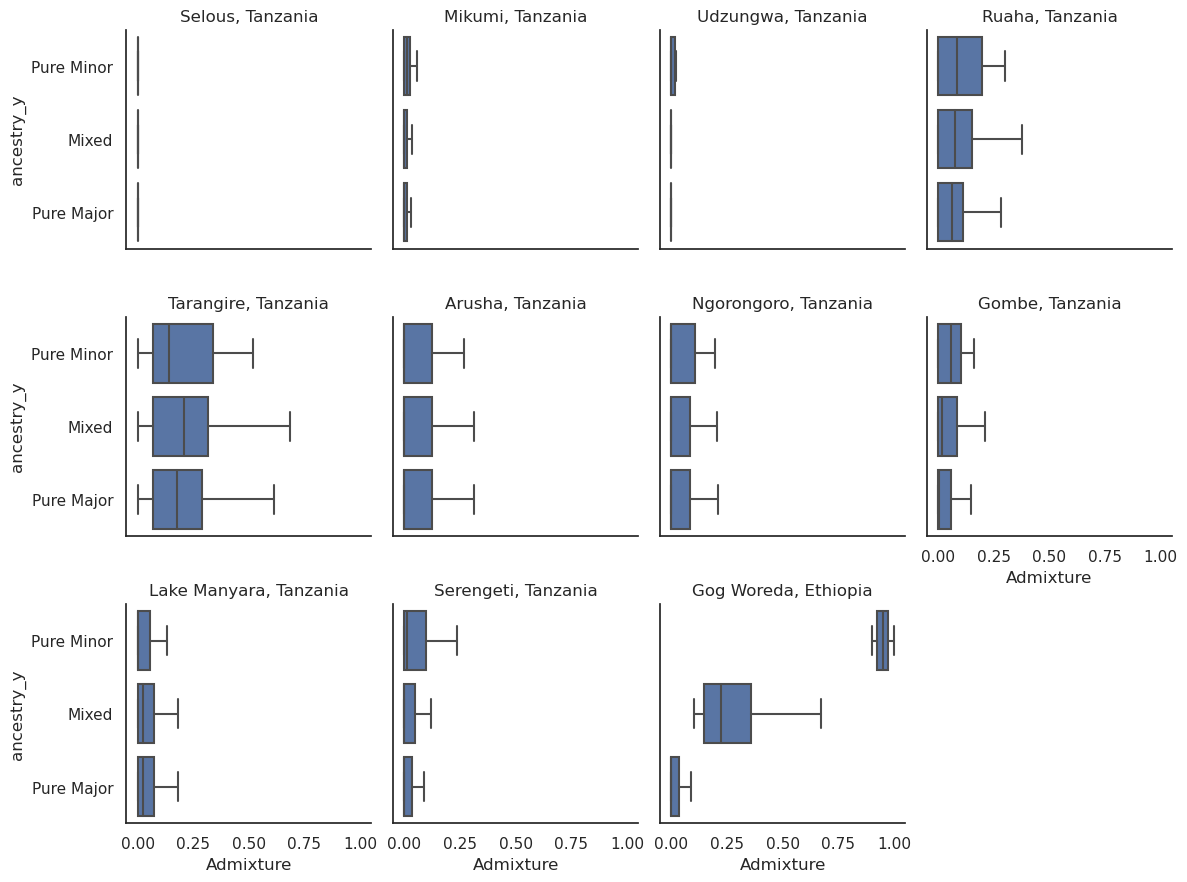

In [184]:
g = sns.FacetGrid(hama_df_add.loc[hama_df_add.Origin.isin(result_order)], col="Origin",
                  col_wrap = 4, col_order=result_order)
g.map_dataframe(sns.boxplot, x="minor_parent_percentage", y="ancestry_y", fliersize=0)
g.set_titles(col_template="{col_name}")
g.set(xlabel="Admixture")

In [185]:
for o in result_order:
    o_df = hama_df_add.loc[hama_df_add.Origin == o]
    print(o, o_df.groupby(["ancestry_y"])["minor_parent_percentage"].mean(),
         o_df.value_counts(["ancestry_y"]))
    print(mannwhitneyu(o_df.loc[o_df.ancestry_y == "Pure Minor"].minor_parent_percentage,
                   o_df.loc[o_df.ancestry_y == "Mixed"].minor_parent_percentage))

Selous, Tanzania ancestry_y
Mixed           0.00391
Pure Major      0.00389
Pure Minor       0.0288
Name: minor_parent_percentage, dtype: float64 ancestry_y
Pure Major    18095
Mixed          6213
Pure Minor       58
Name: count, dtype: int64
MannwhitneyuResult(statistic=191833.0, pvalue=0.0010217662989961927)
Mikumi, Tanzania ancestry_y
Mixed            0.0123
Pure Major      0.00956
Pure Minor       0.0514
Name: minor_parent_percentage, dtype: float64 ancestry_y
Pure Major    17673
Mixed          5957
Pure Minor       42
Name: count, dtype: int64
MannwhitneyuResult(statistic=150205.0, pvalue=0.011869689091504218)
Udzungwa, Tanzania ancestry_y
Mixed            0.0145
Pure Major       0.0131
Pure Minor       0.0428
Name: minor_parent_percentage, dtype: float64 ancestry_y
Pure Major    18927
Mixed          6412
Pure Minor       58
Name: count, dtype: int64
MannwhitneyuResult(statistic=207517.0, pvalue=0.014255019054632216)
Ruaha, Tanzania ancestry_y
Mixed            0.0886
Pure Major   

In [186]:
for o in result_order:
    o_df = hama_df_add_chrX.loc[hama_df_add_chrX.Origin == o]
    print(o, o_df.groupby(["ancestry_y"])["minor_parent_percentage"].mean(),
         o_df.value_counts(["ancestry_y"]))
    print(mannwhitneyu(o_df.loc[o_df.ancestry_y == "Pure Minor"].minor_parent_percentage,
                   o_df.loc[o_df.ancestry_y == "Mixed"].minor_parent_percentage))

Selous, Tanzania ancestry_y
Mixed            0.0432
Pure Major       0.0412
Pure Minor       0.0153
Name: minor_parent_percentage, dtype: float64 ancestry_y
Mixed         488
Pure Major    464
Pure Minor    111
Name: count, dtype: int64
MannwhitneyuResult(statistic=24550.0, pvalue=0.010375169578285156)
Mikumi, Tanzania ancestry_y
Mixed            0.0653
Pure Major       0.0424
Pure Minor       0.0295
Name: minor_parent_percentage, dtype: float64 ancestry_y
Mixed         488
Pure Major    464
Pure Minor    111
Name: count, dtype: int64
MannwhitneyuResult(statistic=24277.0, pvalue=0.06877729224937655)
Udzungwa, Tanzania ancestry_y
Mixed            0.0693
Pure Major       0.0494
Pure Minor       0.0392
Name: minor_parent_percentage, dtype: float64 ancestry_y
Mixed         488
Pure Major    464
Pure Minor    111
Name: count, dtype: int64
MannwhitneyuResult(statistic=22759.0, pvalue=0.0023240813010451705)
Ruaha, Tanzania ancestry_y
Mixed             0.172
Pure Major       0.0843
Pure Minor 

Merged quintiles

/tmp/53630012/ipykernel_3995122/2948258745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Diversity Quintile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
/tmp/53630012/ipykernel_3995122/2948258745.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Chromosome Type"] = "chrX"


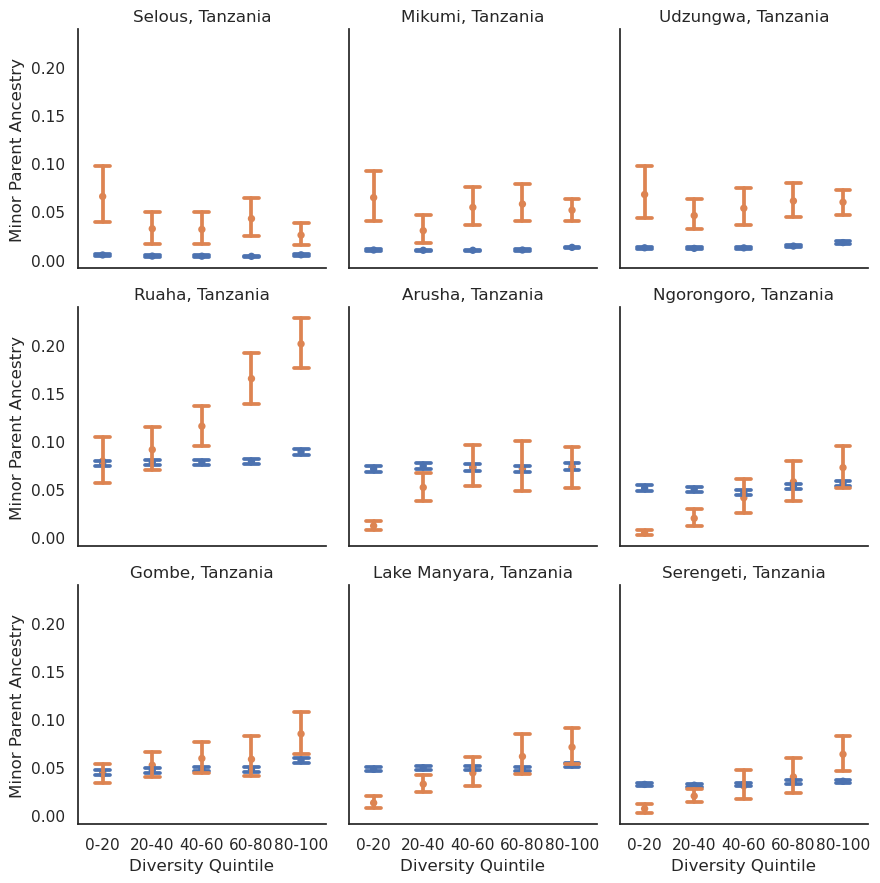

In [187]:
filter_qcut_chrX["Diversity Quintile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
filter_qcut_chrX["Chromosome Type"] = "chrX"

filter_qcut["Diversity Quintile"] = pd.qcut(filter_qcut.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
filter_qcut["Chromosome Type"] = "autosome"
filter_qcut_both = pd.concat([filter_qcut, filter_qcut_chrX])
g = sns.FacetGrid(filter_qcut_both.loc[filter_qcut_both.Origin.isin(result_order_no_gog)], col="Origin",
                  col_wrap = 3, col_order=result_order_no_gog, hue="Chromosome Type")
g.map_dataframe(sns.pointplot, y="minor_parent_percentage", x="Diversity Quantile", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
#g.set(xlim=(0, 0.25))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Diversity Quintile", ylabel="Minor Parent Ancestry")

/tmp/53630012/ipykernel_3995122/3327868747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Diversity Quintile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
/tmp/53630012/ipykernel_3995122/3327868747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_qcut_chrX["Chromosome Type"] = "chrX"


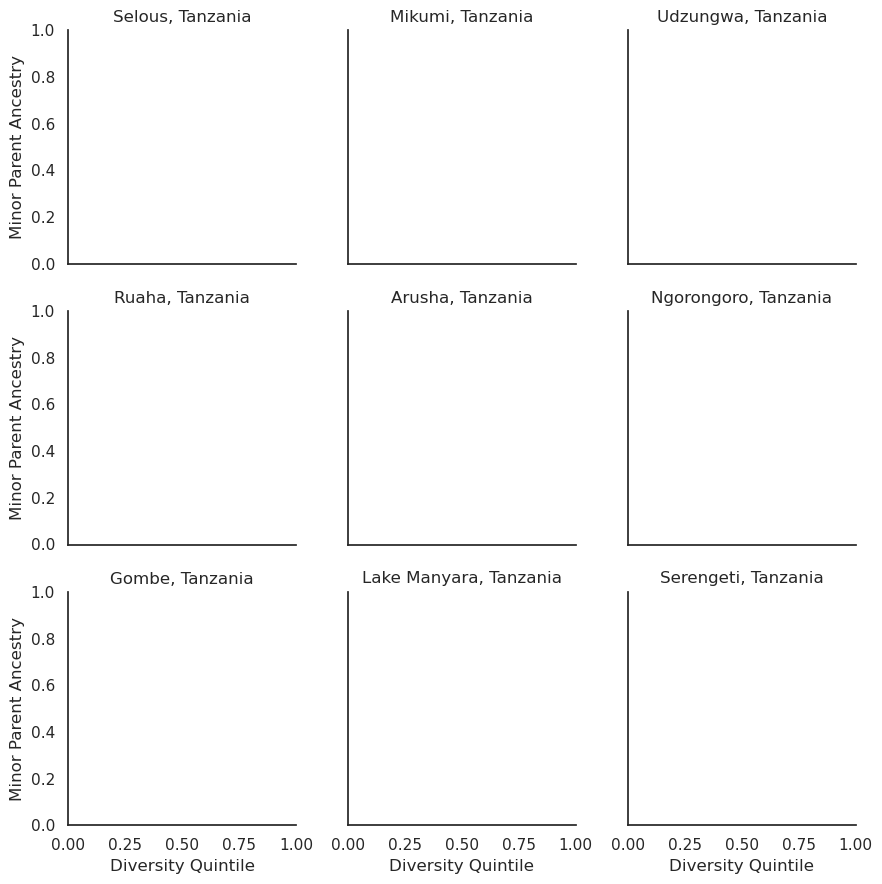

In [188]:
filter_qcut_chrX["Diversity Quintile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
filter_qcut_chrX["Chromosome Type"] = "chrX"

filter_qcut["Diversity Quintile"] = pd.qcut(filter_qcut.diversity, 5,
                                                       labels=["0-20","20-40",
                                                              "40-60","60-80",
                                                              "80-100"])
filter_qcut["Chromosome Type"] = "autosome"
filter_qcut_both = pd.concat([filter_qcut, filter_qcut_chrX])
g = sns.FacetGrid(filter_qcut_both.loc[filter_qcut_both.Origin.isin(["Mahale, Tanzania", "Katavi, Tanzania",
                                                                     "Issa Valley, Tanzania"])], col="Origin",
                  col_wrap = 3, col_order=result_order_no_gog, hue="Chromosome Type")
g.map_dataframe(sns.pointplot, y="minor_parent_percentage", x="Diversity Quantile", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
#g.set(xlim=(0, 0.25))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Diversity Quintile", ylabel="Minor Parent Ancestry")

In [189]:
mean_window_df_tanz_eth = window_df_tanz_eth.groupby(["chrom", "Origin", "individual", "start", "end"])[["north_sum"]].mean().reset_index()
mean_window_df_tanz = window_df_tanz.groupby(["chrom", "Origin", "individual", "start", "end"])[["north_sum"]].mean().reset_index()
admix_div_mean_ind = mean_diversity.merge(mean_window_df_tanz_eth, on=["chrom", "start"])
admix_div_mean_ind["Species"] = admix_div_mean_ind.Origin.map(dict(zip(meta_data_samples_sci.Origin, meta_data_samples_sci.Species)))
admix_div_mean_ind = admix_div_mean_ind.merge(c_r_g_df, on=["chrom", "start"])
admix_div_mean_ind["North Percentage"] = admix_div_mean_ind.north_sum/100000

In [190]:
admix_div_mean_ind = admix_div_mean_ind.loc[admix_div_mean_ind.Origin.isin(origins_interest)]
admix_div_mean_ind["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Gambella region, Ethiopia_eth_case"
                                             else 1-x for x, y, z in zip(admix_div_mean_ind["North Percentage"],
                                                                         admix_div_mean_ind["Species"],
                                                                        admix_div_mean_ind["Origin"])]
admix_div_mean_ind["local_minor_ancestry"] = [min(x, 1-x) for x in admix_div_mean_ind["North Percentage"]]

In [191]:
filter_callable_ind = admix_div_mean_ind.loc[admix_div_mean_ind.callable_frac > 0.75]
filter_qcut_ind = filter_callable_ind.loc[(filter_callable_ind.diversity >= 0.000513) &
                                 (filter_callable_ind.diversity <= 0.00408)]

In [192]:
o_l, id_l, slope_l, intercept_l, pval_slope_l, pval_intercept_l, stderr_slope_l, stderr_intercept_l = [], [], [], [], [], [], [], []
for o in result_order:
    o_div = filter_qcut_ind.loc[(filter_qcut_ind.Origin == o)]
    for i in o_div.individual.unique():
        i_df = o_div.loc[o_div.individual == i]
        glm_results = smf.glm(formula = "minor_parent_percentage ~ diversity", data=i_df,
                         var_weights=np.asarray(i_df["diversity"])).fit()
        print(o, i, glm_results.summary())
        o_l.append(o), id_l.append(i)
        slope_l.append(glm_results.params[1]), intercept_l.append(glm_results.params[0])
        pval_slope_l.append(glm_results.pvalues[1]), pval_intercept_l.append(glm_results.pvalues[0])
        stderr_slope_l.append(glm_results.bse[1]), stderr_intercept_l.append(glm_results.bse[0])

Selous, Tanzania PD_0235                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                19813
Model:                                 GLM   Df Residuals:                    19811
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      1.2323e-06
Method:                               IRLS   Log-Likelihood:                 42914.
Date:                     Tue, 04 Feb 2025   Deviance:                     0.024414
Time:                             12:59:52   Pearson chi2:                   0.0244
No. Iterations:                          3   Pseudo R-squ. (CS):          2.904e-06
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Mikumi, Tanzania PD_0271                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      9.8308e-06
Method:                               IRLS   Log-Likelihood:                 26777.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.23278
Time:                             12:59:53   Pearson chi2:                    0.233
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0007133
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Mikumi, Tanzania PD_0690                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      7.2656e-06
Method:                               IRLS   Log-Likelihood:                 30358.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.17204
Time:                             12:59:53   Pearson chi2:                    0.172
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001101
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Mikumi, Tanzania PD_0752                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      7.1011e-06
Method:                               IRLS   Log-Likelihood:                 30629.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.16815
Time:                             12:59:54   Pearson chi2:                    0.168
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0005364
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Mikumi, Tanzania PD_0761                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      8.1750e-06
Method:                               IRLS   Log-Likelihood:                 28961.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.19357
Time:                             12:59:54   Pearson chi2:                    0.194
No. Iterations:                          3   Pseudo R-squ. (CS):          3.915e-05
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Mikumi, Tanzania PD_0767                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      8.8706e-06
Method:                               IRLS   Log-Likelihood:                 27994.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.21005
Time:                             12:59:55   Pearson chi2:                    0.210
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0004030
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Mikumi, Tanzania PD_0773                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      8.7169e-06
Method:                               IRLS   Log-Likelihood:                 28201.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.20641
Time:                             12:59:55   Pearson chi2:                    0.206
No. Iterations:                          3   Pseudo R-squ. (CS):          9.930e-06
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Ruaha, Tanzania PD_0213                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25406
Model:                                 GLM   Df Residuals:                    25404
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      6.4172e-05
Method:                               IRLS   Log-Likelihood:                 4888.2
Date:                     Tue, 04 Feb 2025   Deviance:                       1.6302
Time:                             12:59:56   Pearson chi2:                     1.63
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001249
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

Tarangire, Tanzania PD_0243                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25406
Model:                                 GLM   Df Residuals:                    25404
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      0.00016726
Method:                               IRLS   Log-Likelihood:                -7280.9
Date:                     Tue, 04 Feb 2025   Deviance:                       4.2490
Time:                             12:59:57   Pearson chi2:                     4.25
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0001055
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

Arusha, Tanzania PD_0204                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25406
Model:                                 GLM   Df Residuals:                    25404
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      6.4272e-05
Method:                               IRLS   Log-Likelihood:                 4868.3
Date:                     Tue, 04 Feb 2025   Deviance:                       1.6328
Time:                             12:59:57   Pearson chi2:                     1.63
No. Iterations:                          3   Pseudo R-squ. (CS):          4.315e-05
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Gombe, Tanzania PD_0218                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                25406
Model:                                 GLM   Df Residuals:                    25404
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      3.9986e-05
Method:                               IRLS   Log-Likelihood:                 10897.
Date:                     Tue, 04 Feb 2025   Deviance:                       1.0158
Time:                             12:59:58   Pearson chi2:                     1.02
No. Iterations:                          3   Pseudo R-squ. (CS):           0.003464
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

Gombe, Tanzania PD_0507                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      4.5980e-05
Method:                               IRLS   Log-Likelihood:                 8511.1
Date:                     Tue, 04 Feb 2025   Deviance:                       1.0888
Time:                             12:59:59   Pearson chi2:                     1.09
No. Iterations:                          3   Pseudo R-squ. (CS):           0.002658
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

Gombe, Tanzania PD_0654                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      4.7030e-05
Method:                               IRLS   Log-Likelihood:                 8243.8
Date:                     Tue, 04 Feb 2025   Deviance:                       1.1136
Time:                             12:59:59   Pearson chi2:                     1.11
No. Iterations:                          3   Pseudo R-squ. (CS):           0.001128
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

Lake Manyara, Tanzania PD_0676                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      3.8042e-05
Method:                               IRLS   Log-Likelihood:                 10755.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.90080
Time:                             13:00:00   Pearson chi2:                    0.901
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0005931
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

Lake Manyara, Tanzania PD_0684                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      5.3052e-05
Method:                               IRLS   Log-Likelihood:                 6817.2
Date:                     Tue, 04 Feb 2025   Deviance:                       1.2562
Time:                             13:00:00   Pearson chi2:                     1.26
No. Iterations:                          3   Pseudo R-squ. (CS):          4.828e-05
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

Serengeti, Tanzania PD_0493                     Generalized Linear Model Regression Results                    
Dep. Variable:     minor_parent_percentage   No. Observations:                23681
Model:                                 GLM   Df Residuals:                    23679
Model Family:                     Gaussian   Df Model:                            1
Link Function:                    Identity   Scale:                      2.8332e-05
Method:                               IRLS   Log-Likelihood:                 14245.
Date:                     Tue, 04 Feb 2025   Deviance:                      0.67086
Time:                             13:00:01   Pearson chi2:                    0.671
No. Iterations:                          3   Pseudo R-squ. (CS):          0.0003297
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [193]:
glm_diversity_df = pd.DataFrame({"Origin": o_l, "individual": id_l, "Intercept": intercept_l, "Slope": slope_l, 
                                 "Intercept P-value": pval_intercept_l, "Slope P-value": pval_slope_l,
                                "Intercept stderr": stderr_intercept_l, "Slope stderr": stderr_slope_l})
glm_diversity_df

Origin individual  Intercept      Slope  Intercept P-value  \
0       Selous, Tanzania    PD_0235    0.00175    -0.0747            0.00506   
1       Selous, Tanzania    PD_0236    0.00541      -1.03           2.11e-10   
2       Selous, Tanzania    PD_0237    0.00275       1.18            0.00998   
3       Mikumi, Tanzania    PD_0268    0.00427       4.51            0.00924   
4       Mikumi, Tanzania    PD_0269     0.0133      -1.11           2.98e-17   
..                   ...        ...        ...        ...                ...   
114  Serengeti, Tanzania    PD_0497     0.0317       1.76           9.99e-30   
115  Serengeti, Tanzania    PD_0498     0.0269       5.16           2.82e-21   
116  Serengeti, Tanzania    PD_0499     0.0277       4.54            3.8e-22   
117  Serengeti, Tanzania    PD_0500     0.0261       5.94           3.99e-20   
118  Serengeti, Tanzania    PD_0501     0.0264       7.46           1.55e-17   

     Slope P-value  Intercept stderr  Slope stderr  
0            0.811          0.000624         0.312  
1            0.015          0.000851         0.425  
2           0.0259           0.00107         0.531  
3         3.27e-08           0.00164         0.817  
4            0.155           0.00157         0.782  
..             ...               ...           ...  
114          0.205            0.0028          1.39  
115        0.00026           0.00284          1.41  
116        0.00145           0.00286          1.43  
117        2.6e-05           0.00284          1.41  
118       1.31e-06            0.0031          1.54  

[119 rows x 8 columns]

<Axes: xlabel='Slope', ylabel='Count'>

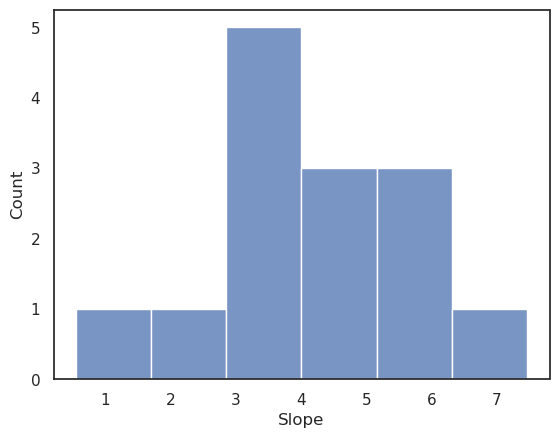

In [194]:
sns.histplot(data=glm_diversity_df.loc[glm_diversity_df.Origin == "Serengeti, Tanzania"], x="Slope")

In [195]:
glm_diversity_df.loc[glm_diversity_df.Origin == "Serengeti, Tanzania"]

Origin individual  Intercept      Slope  Intercept P-value  \
105  Serengeti, Tanzania    PD_0199     0.0256       3.53           3.35e-23   
106  Serengeti, Tanzania    PD_0200     0.0237       6.16           5.97e-18   
107  Serengeti, Tanzania    PD_0201     0.0296        3.9            5.1e-26   
108  Serengeti, Tanzania    PD_0202     0.0228       3.85           1.81e-19   
109  Serengeti, Tanzania    PD_0203     0.0241       4.19           3.24e-21   
110  Serengeti, Tanzania    PD_0493     0.0265       3.83           6.09e-22   
111  Serengeti, Tanzania    PD_0494     0.0238       4.35           9.94e-18   
112  Serengeti, Tanzania    PD_0495     0.0259        3.1           7.48e-22   
113  Serengeti, Tanzania    PD_0496     0.0289      0.551           8.89e-29   
114  Serengeti, Tanzania    PD_0497     0.0317       1.76           9.99e-30   
115  Serengeti, Tanzania    PD_0498     0.0269       5.16           2.82e-21   
116  Serengeti, Tanzania    PD_0499     0.0277       4.54            3.8e-22   
117  Serengeti, Tanzania    PD_0500     0.0261       5.94           3.99e-20   
118  Serengeti, Tanzania    PD_0501     0.0264       7.46           1.55e-17   

     Slope P-value  Intercept stderr  Slope stderr  
105        0.00598           0.00258          1.28  
106       6.59e-06           0.00274          1.37  
107        0.00537           0.00281           1.4  
108         0.0022           0.00253          1.26  
109       0.000965           0.00255          1.27  
110         0.0052           0.00275          1.37  
111        0.00162           0.00277          1.38  
112         0.0207           0.00269          1.34  
113           0.67           0.00259          1.29  
114          0.205            0.0028          1.39  
115        0.00026           0.00284          1.41  
116        0.00145           0.00286          1.43  
117        2.6e-05           0.00284          1.41  
118       1.31e-06            0.0031          1.54

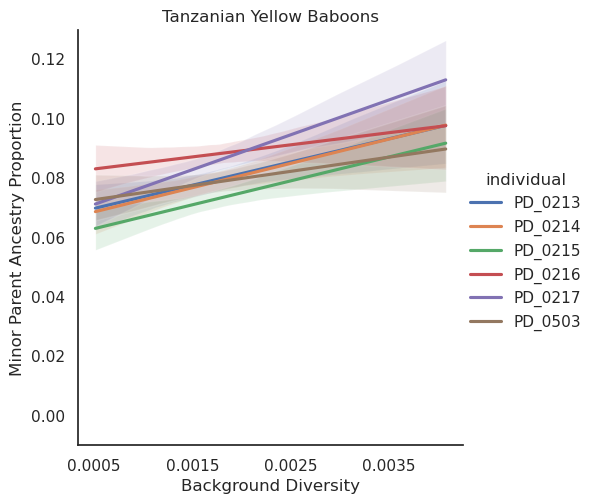

In [196]:
g = lmplot(filter_qcut_ind.loc[filter_qcut_ind.Origin.isin(["Ruaha, Tanzania"])], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="individual", ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Yellow Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=np.arange(0.0005, 0.004, 0.001))

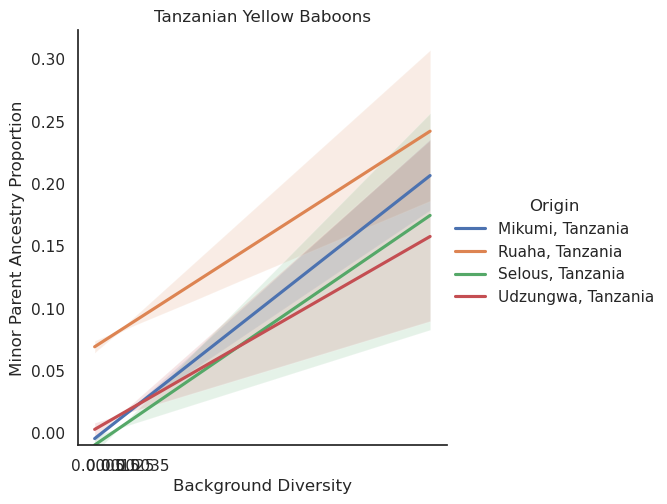

In [197]:
g = lmplot(admix_div_mean_ind.loc[admix_div_mean_ind.Origin.isin(yellows)], x="diversity", y="minor_parent_percentage",
                            scatter=False, hue="Origin", weighted=True, n_boot=1000, ci=99.5) #Additional bootstraps makes it take long
g.set(ylabel="Minor Parent Ancestry Proportion", xlabel="Background Diversity", title="Tanzanian Yellow Baboons")
g.set(ylim=(-0.01, None))
g.set(xticks=np.arange(0.0005, 0.004, 0.001))

Admixture per chromosome investigation

In [198]:
ind_df = window_df_tanz_eth.groupby(["individual", "chrom", "Origin", "start", "end"])[["north_sum"]].mean().reset_index()
ind_df_div = mean_diversity.merge(ind_df, on=["chrom", "start"])
ind_df_div = ind_df_div.merge(c_r_g_df, on=["chrom", "start"])
ind_df_div["North Percentage"] = ind_df_div.north_sum/100000
ind_df_div["Species"] = ind_df_div.Origin.map(dict(zip(meta_data_samples_sci.Origin, meta_data_samples_sci.Species)))

#Selecting the cases of interest and setting Minor Parent Ancestry
origins_interest = ['Arusha, Tanzania',
       'Gog Woreda, Gambella region, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia_eth_case',
       'Gombe, Tanzania', 'Issa Valley, Tanzania',
       'Katavi, Tanzania','Lake Manyara, Tanzania',
       'Mahale, Tanzania',
       'Mikumi, Tanzania', 'Ngorongoro, Tanzania', 'Ruaha, Tanzania',
       'Selous, Tanzania', 'Serengeti, Tanzania', 'Tarangire, Tanzania',
       'Udzungwa, Tanzania']
ind_df_div = ind_df_div.loc[ind_df_div.Origin.isin(origins_interest)]
ind_df_div["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Gambella region, Ethiopia_eth_case"
                                             else 1-x for x, y, z in zip(ind_df_div["North Percentage"],
                                                                         ind_df_div["Species"],
                                                                        ind_df_div["Origin"])]
ind_df_div = ind_df_div.loc[ind_df_div.callable_frac > 0.75]

In [199]:
o_l, low_l, high_l, effect_l, admix_l, chr_l, ind_l = [], [], [], [], [], [], []
#filter_qcut_chrX["Diversity Quantile"] = pd.qcut(filter_qcut_chrX.diversity, 5,
#                                                       labels=["0-20","20-40",
#                                                              "40-60","60-80",
#                                                              "80-100"])

for o in ind_df_div.Origin.unique():
    print(o)
    for c in ind_df_div.chrom.unique():
        print(c)
        for i in ind_df_div.loc[(ind_df_div.Origin == o) & (ind_df_div.chrom == c)].individual.unique():
            i_s_df = ind_df_div.loc[(ind_df_div.individual == i) & (ind_df_div.chrom == c)]
            #print(i)
            o_l.append(o), ind_l.append(i), chr_l.append(c)
            i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
                                                       labels=["0-50", "50-100"])
            low_mean = i_s_df.loc[i_s_df["Diversity Quantile"] == "0-50"][["minor_parent_percentage"]].mean()[0]*100
            high_mean = i_s_df.loc[i_s_df["Diversity Quantile"] == "50-100"][["minor_parent_percentage"]].mean()[0]*100
            low_l.append(low_mean)
            high_l.append(high_mean)
            effect_l.append(high_mean/low_mean)
            admix_l.append(i_s_df.minor_parent_percentage.mean())

Serengeti, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Arusha, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Ngorongoro, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Ruaha, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Gombe, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Udzungwa, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  effect_l.append(high_mean/low_mean)
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: Se

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Mahale, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Katavi, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


Selous, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  effect_l.append(high_mean/low_mean)
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: Ru

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  effect_l.append(high_mean/low_mean)
/tmp/53630012/ipykernel_3995122/1377206513.py:15: Se

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13
chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  effect_l.append(high_mean/low_mean)
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: Se

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  effect_l.append(high_mean/low_mean)
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: Se

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  effect_l.append(high_mean/low_mean)
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: Se

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Lake Manyara, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Tarangire, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Mikumi, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6
chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  effect_l.append(high_mean/low_mean)
/tmp/53630012/ipykernel_3995122/1377206513.py:15: Se

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Issa Valley, Tanzania
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr6
chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,


Gog Woreda, Gambella region, Ethiopia
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6
chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Gog Woreda, Gambella region, Ethiopia_eth_case
chr1


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr10


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr11


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr12


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr13


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr14


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr15


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr16


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr17


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr18


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr19


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr2


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr20


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr3


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr4


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr5


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr6


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr7


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr8


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

chr9


/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_s_df["Diversity Quantile"] = pd.qcut(i_s_df.diversity, 2,
/tmp/53630012/ipykernel_3995122/1377206513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [200]:
admix_df = pd.DataFrame({"Origin": o_l, "individual": ind_l, "chrom": chr_l, "Low Diversity Quantile": low_l,
              "High Diversity Quantile": high_l, "Relative Difference": effect_l, "Mean_Admixture": admix_l})
admix_df["Absolute_Difference"] = admix_df["High Diversity Quantile"]-admix_df["Low Diversity Quantile"]
admix_df["Concentration"] = admix_df["High Diversity Quantile"]/admix_df.Mean_Admixture*0.5

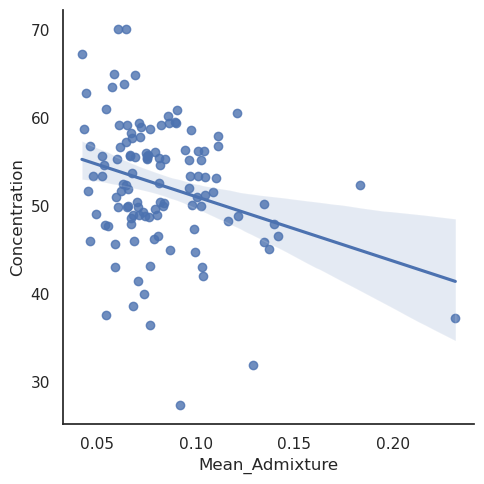

In [201]:
sns.lmplot(admix_df.loc[admix_df.Origin == "Ruaha, Tanzania"],
           x="Mean_Admixture", y="Concentration")

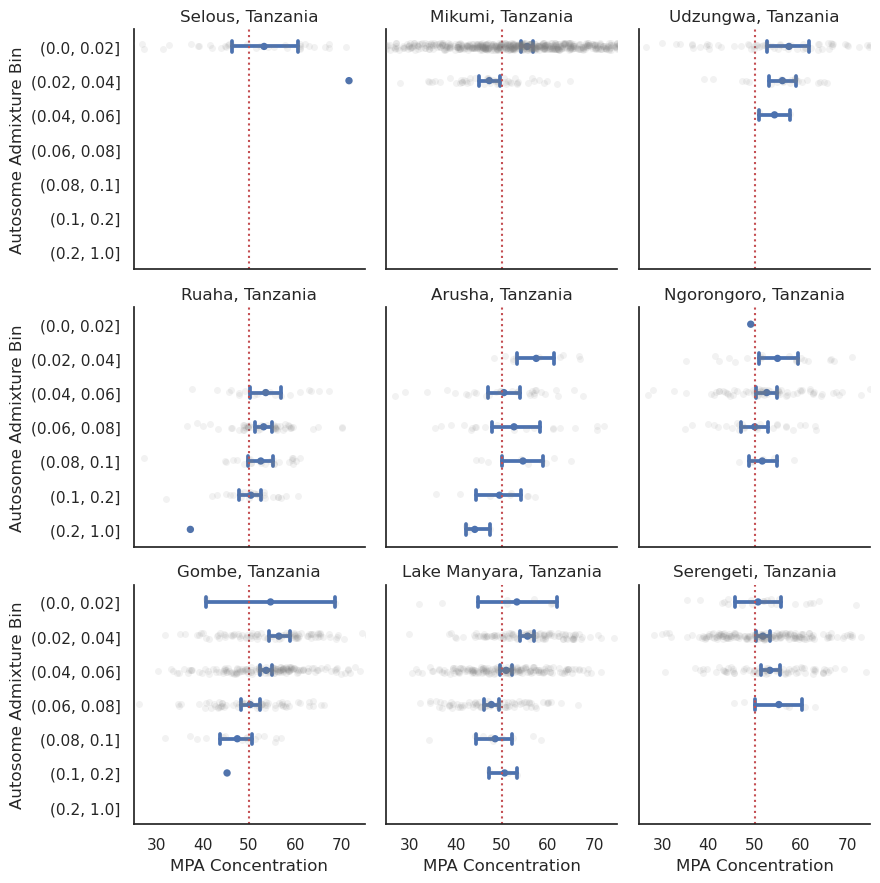

In [202]:
admix_df["Mean Admixture Bin"] = pd.cut(admix_df.Mean_Admixture, [0, 0.02, 0.04, 0.06,
                                                                  0.08, 0.1, 0.2, 1])
g = sns.FacetGrid(admix_df.loc[admix_df.Origin.isin(result_order_no_gog)], col="Origin",
                  col_wrap = 3, col_order=result_order_no_gog)
g.map_dataframe(sns.stripplot, y="Mean Admixture Bin", x="Concentration", alpha=.1, color="grey")
g.map_dataframe(sns.pointplot, y="Mean Admixture Bin", x="Concentration", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
g.set(xlim=(25, 75))
g.set_titles(col_template="{col_name}")
axes = g.axes.flatten()
for ax in g.axes.flat:
    ax.axvline(x=50, color='r', linestyle=':')
g.set(xlabel="MPA Concentration", ylabel="Autosome Admixture Bin")

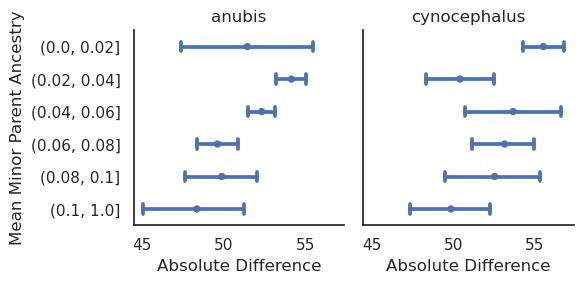

In [203]:
admix_df["Mean Admixture Bin"] = pd.cut(admix_df.Mean_Admixture, [0, 0.02, 0.04, 0.06,
                                                                  0.08, 0.1, 1])
admix_df["Species"] = admix_df.Origin.map(dict(zip(meta_data_samples_sci.Origin, meta_data_samples_sci.Species)))
g = sns.FacetGrid(admix_df.loc[admix_df.Origin.isin(result_order_no_gog)], col="Species",
                  col_wrap = 2)
g.map_dataframe(sns.pointplot, y="Mean Admixture Bin", x="Concentration", 
                linestyles="none", capsize=.3, errorbar=("ci", 95), scale = 0.6)
#g.map_dataframe(sns.stripplot, x="minor_parent_percentage", y="Diversity Quantile", alpha=0.05)
#g.set(xlim=(0, 0.25))
g.set_titles(col_template="{col_name}")
g.set(xlabel="Absolute Difference", ylabel="Mean Minor Parent Ancestry")

In [204]:
glm_results = smf.glm(formula = "Absolute_Difference ~ Mean_Admixture+I(Mean_Admixture**2)",
                      data=admix_df.loc[admix_df.Origin == "Ruaha, Tanzania"]).fit()
print(glm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     Absolute_Difference   No. Observations:                  119
Model:                             GLM   Df Residuals:                      116
Model Family:                 Gaussian   Df Model:                            2
Link Function:                Identity   Scale:                          5.2372
Method:                           IRLS   Log-Likelihood:                -265.85
Date:                 Tue, 04 Feb 2025   Deviance:                       607.51
Time:                         13:44:59   Pearson chi2:                     608.
No. Iterations:                      3   Pseudo R-squ. (CS):             0.2125
Covariance Type:             nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [205]:
glm_results = smf.glm(formula = "Absolute_Difference ~ Mean_Admixture", data=admix_df).fit()
print(glm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     Absolute_Difference   No. Observations:                 3460
Model:                             GLM   Df Residuals:                     3458
Model Family:                 Gaussian   Df Model:                            1
Link Function:                Identity   Scale:                          4.1600
Method:                           IRLS   Log-Likelihood:                -7374.7
Date:                 Tue, 04 Feb 2025   Deviance:                       14385.
Time:                         13:44:59   Pearson chi2:                 1.44e+04
No. Iterations:                      3   Pseudo R-squ. (CS):          0.0006201
Covariance Type:             nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6623      0.0